<a href="https://colab.research.google.com/github/quantority/master-s-degree-projects/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

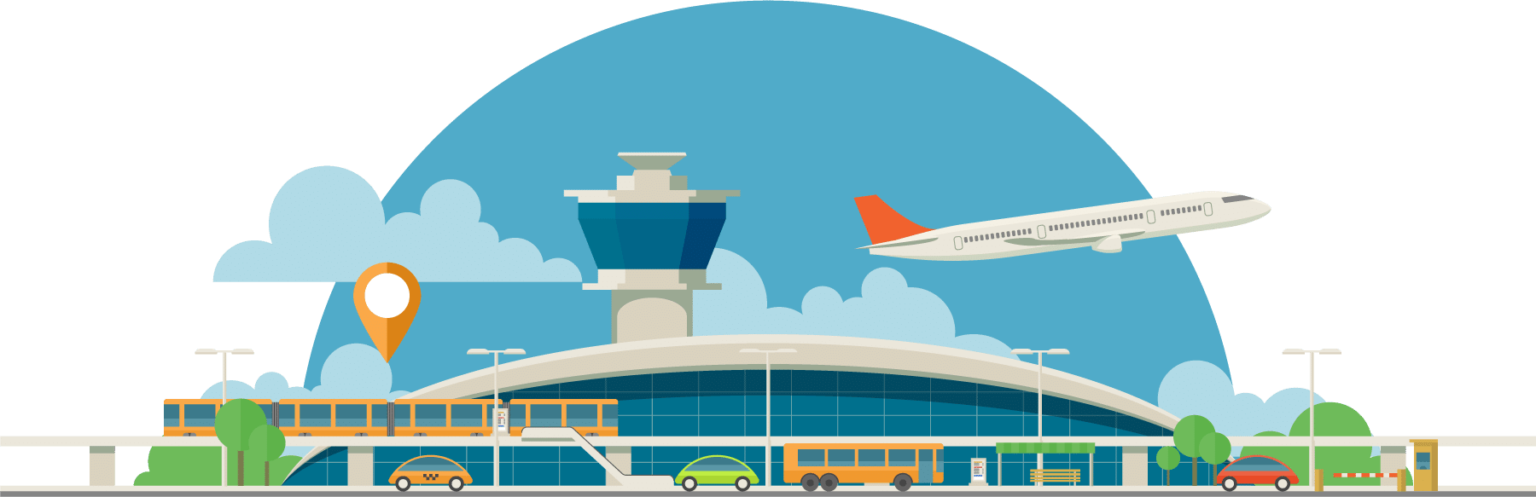

In [4]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [6]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-13 13:00:54--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-13 13:00:55 (1.65 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

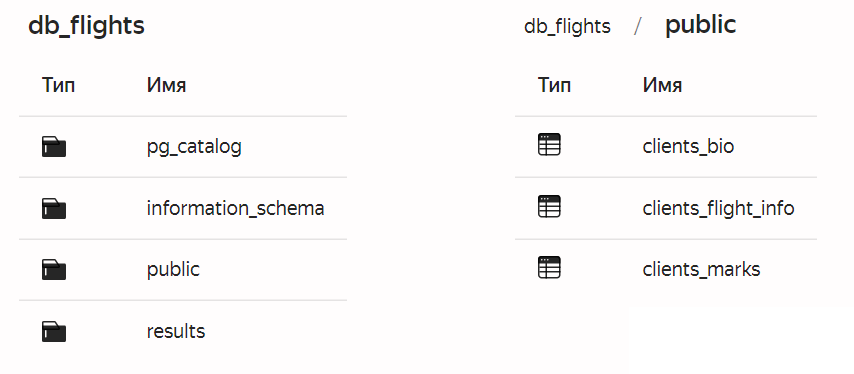



In [7]:
# Ваш код здесь

params = {
    "host":"rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port":"6432",
    "sslmode":"verify-full",
    "dbname":"db_flights",
    "user":"mlhs_student",
    "password":"mlhs_student",
    "target_session_attrs":"read-write"
    }

In [8]:
conn = psycopg2.connect(**params)

In [9]:
cursor = conn.cursor()

In [10]:
cursor.execute('SELECT bio.*, info.*, marks.* FROM public.clients_bio AS bio INNER JOIN public.clients_flight_info AS info ON bio.id = info.id INNER JOIN public.clients_marks AS marks ON bio.id = marks.id')

In [11]:
col_names = [desc[0] for desc in cursor.description]

In [12]:
df = pd.DataFrame(cursor.fetchall(), columns=col_names)

In [13]:
cursor.close()
conn.close()

In [14]:
df = df.loc[:, ~df.columns.duplicated()].set_index('id')

In [15]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [16]:
# Ваш код ниже
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [17]:
df.replace('nan', np.NaN, inplace=True)

In [18]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

<ipython-input-18-d6a3b622c820>:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [19]:
df.isna().sum()

,0
gender,0
age,315
Customer Type,77
Type of Travel,101
class,116
Flight Distance,94
Departure Delay in Minutes,107
Arrival Delay in Minutes,507
Inflight wifi service,44
Departure/Arrival time convenient,49


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


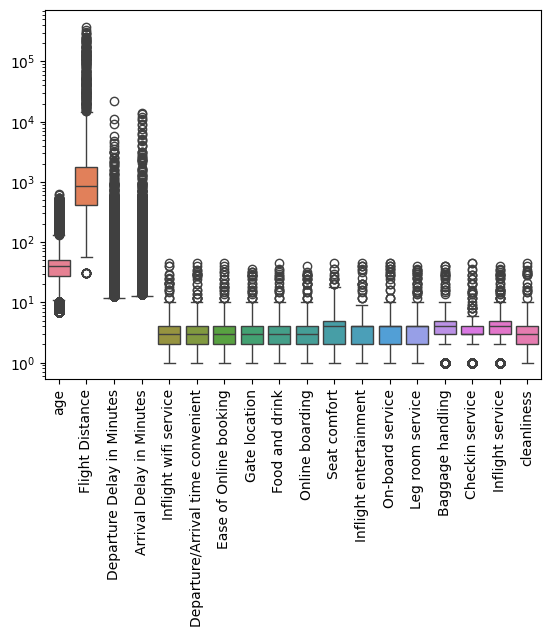

In [20]:
sns.boxplot(df.select_dtypes(include=['number']), log_scale=True)
plt.xticks(rotation=90)
plt.show()

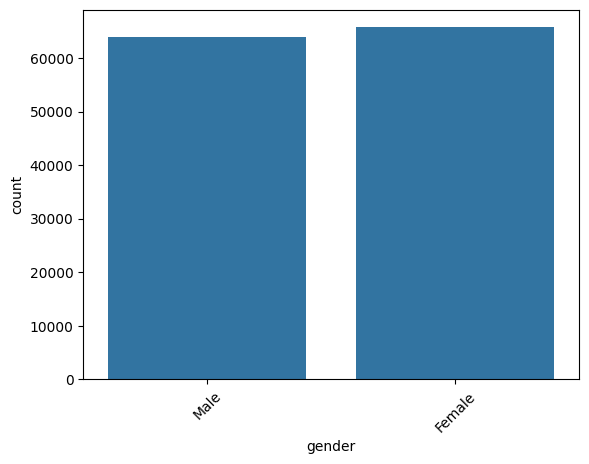

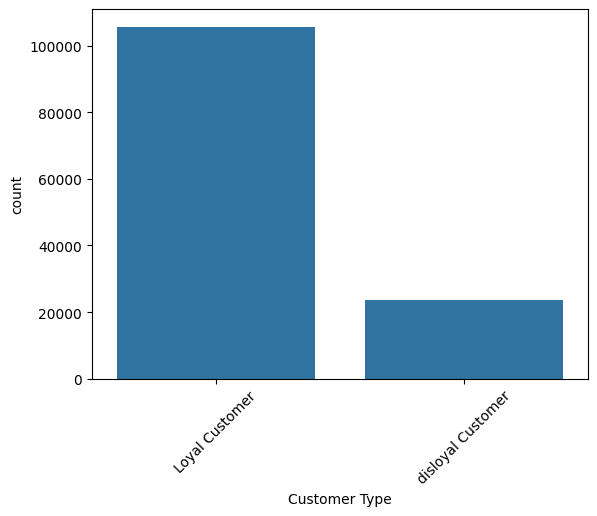

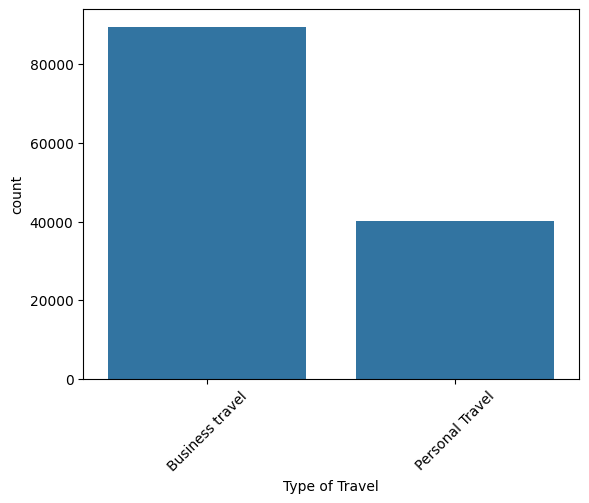

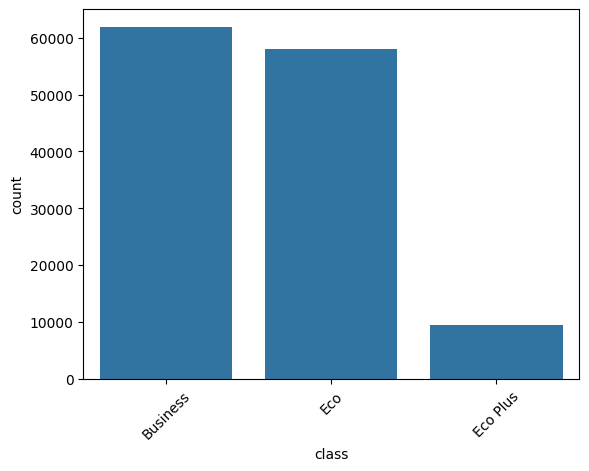

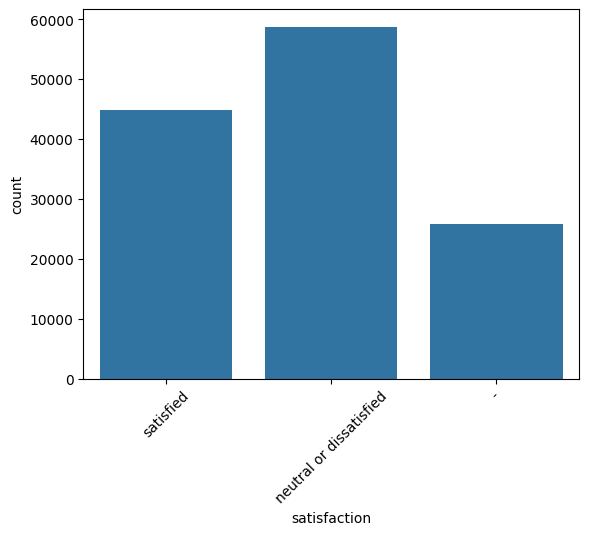

In [21]:
for col in df.select_dtypes(include=['object']).columns:
  sns.countplot(x=df[col])
  plt.xticks(rotation=45)
  plt.show()

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

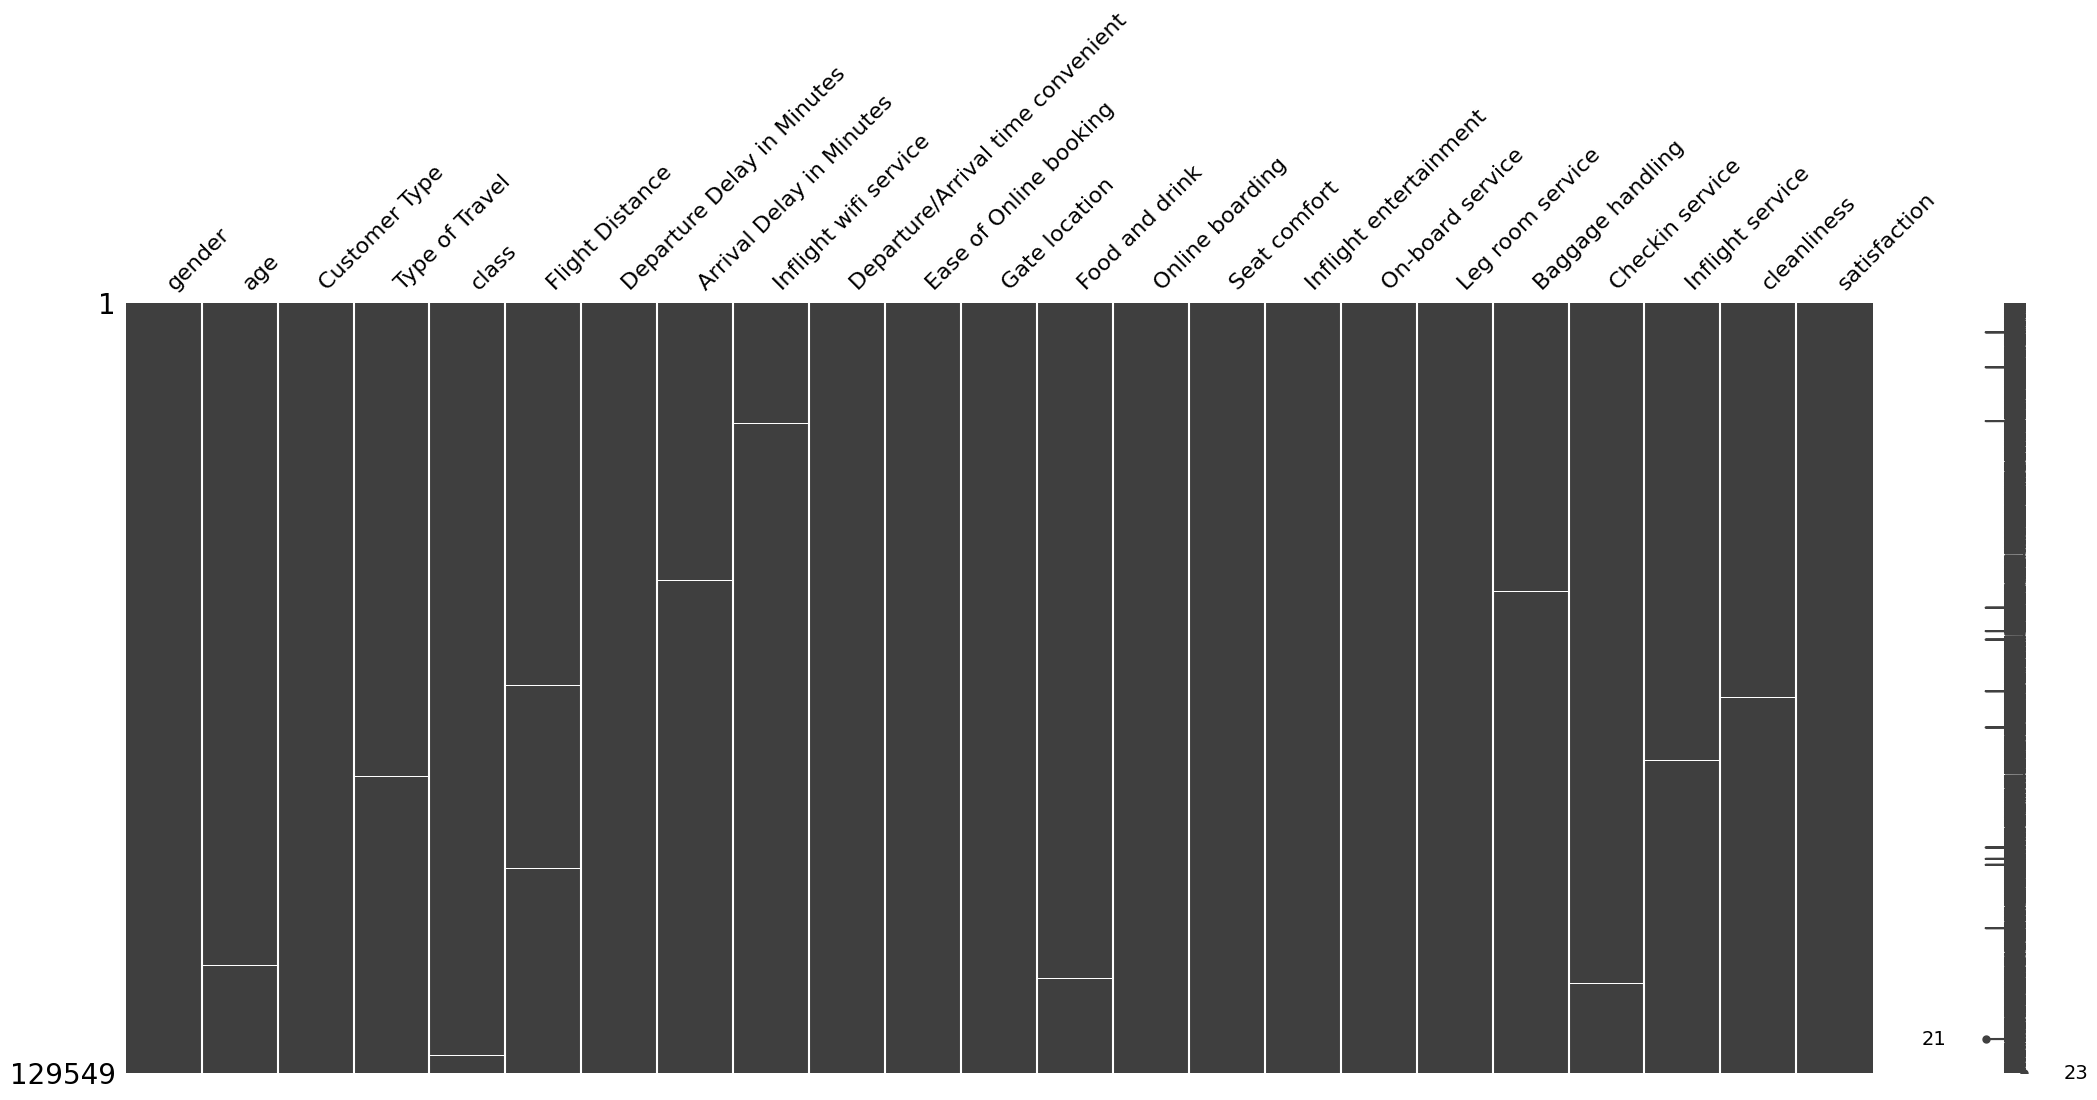

In [22]:
# Ваш код ниже
missingno.matrix(df)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

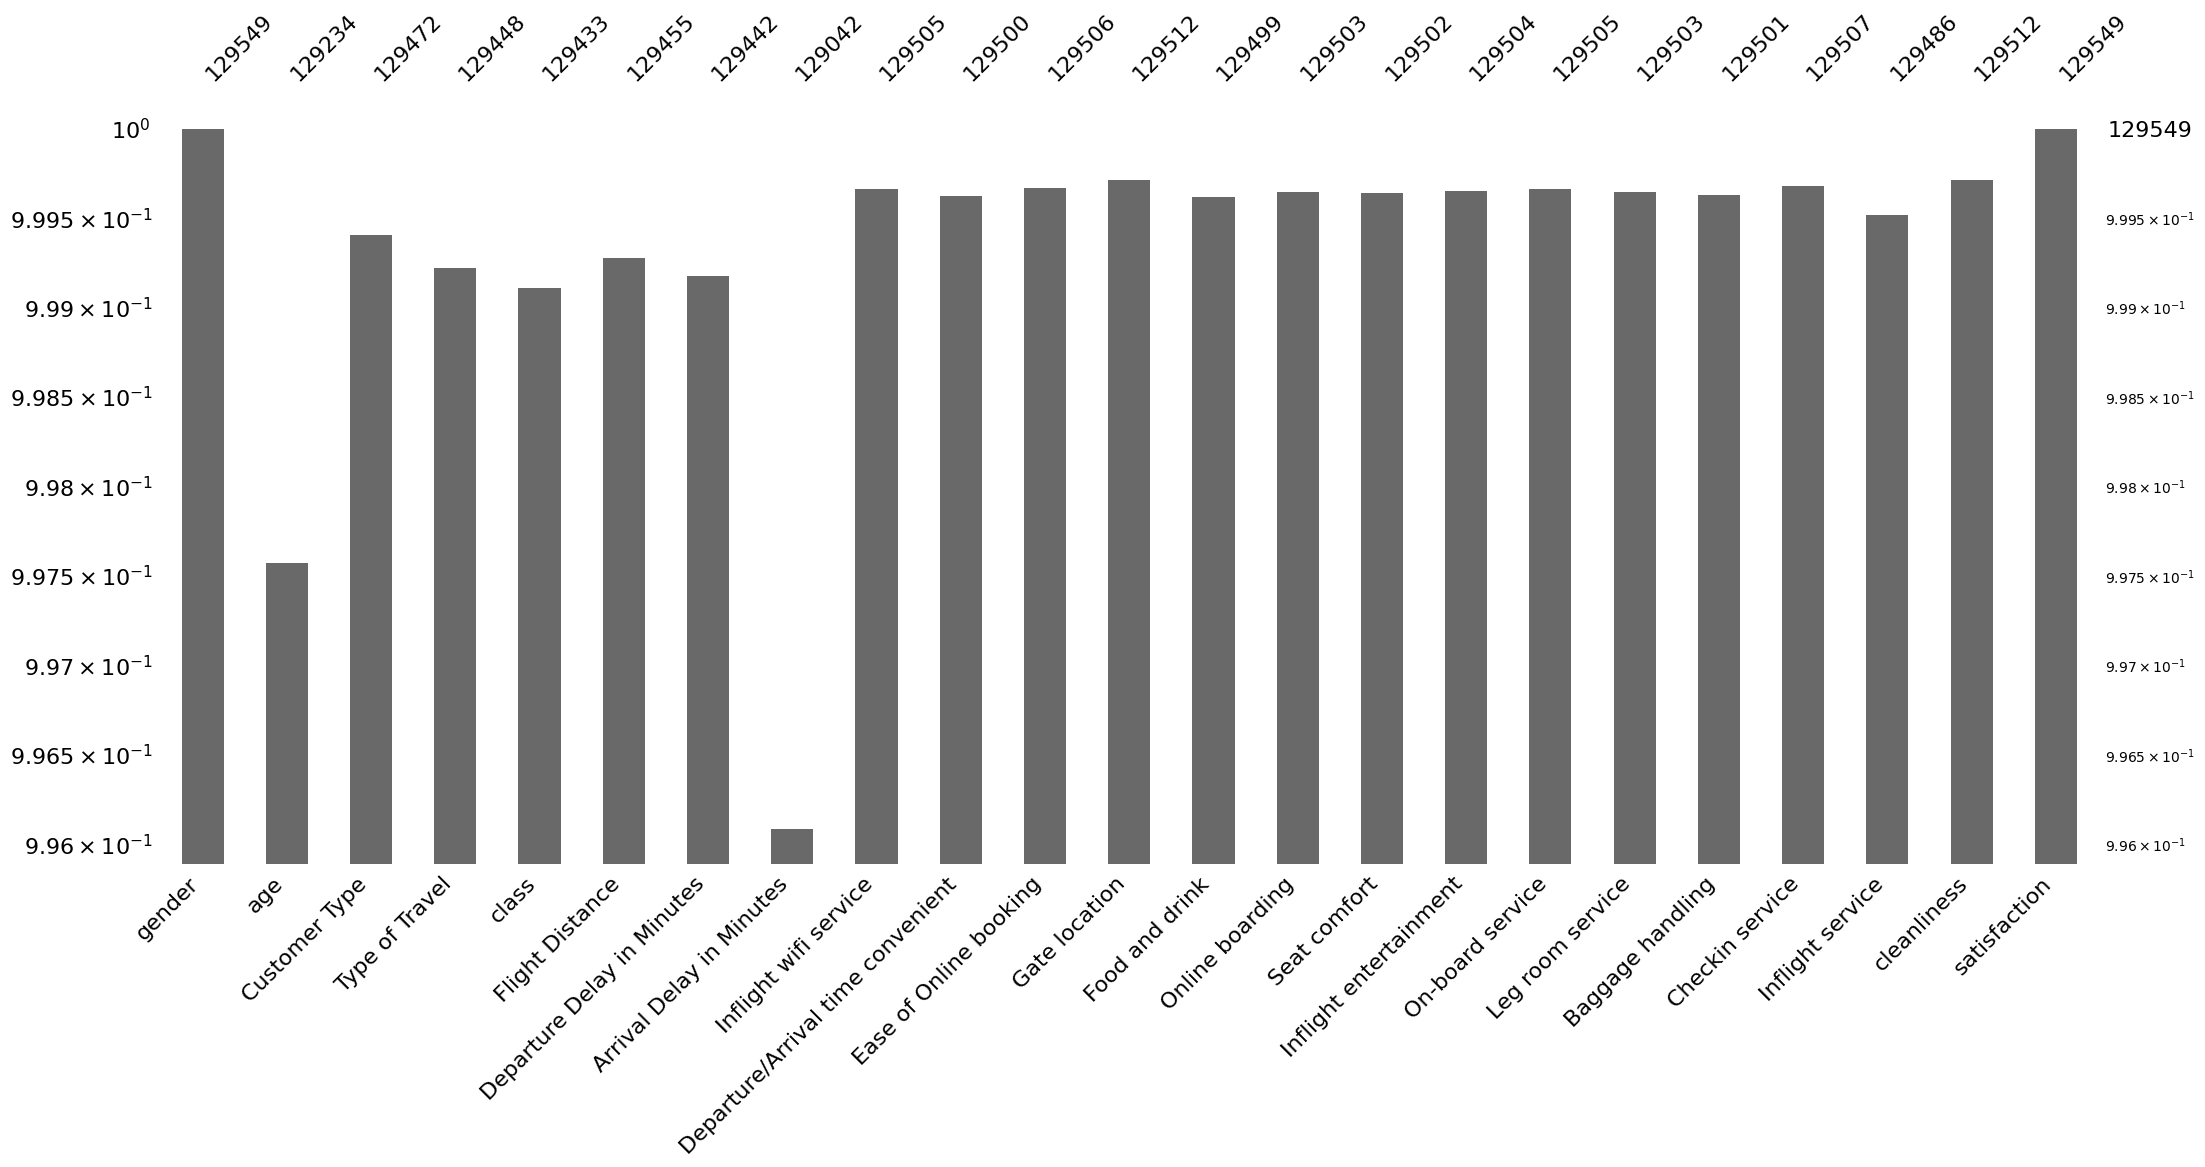

In [23]:
# Ваш код ниже

missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [24]:
df_train = df[df.satisfaction != '-']
df_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Female,28.0,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Male,66.0,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [25]:
assert df_train.shape == (103_644, 23)

In [26]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [72]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [73]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [74]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [75]:
# Ваш код ниже

for frame in [X_train, X_val, df_test]:
  for col in frame.columns:
    frame[col].fillna(X_train[col].mode().values[0], inplace=True)

<ipython-input-75-fdc233a7a1e5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frame[col].fillna(X_train[col].mode().values[0], inplace=True)


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [76]:
# Ваш код ниже
display(df.describe(include='number'))

display(df.select_dtypes(include=['O']).describe())

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,129234.000000,129455.000000,129442.000000,129042.000000,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000
mean,40.116951,1322.922158,15.809026,16.656499,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780
std,20.376129,4517.816532,93.276882,109.285072,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000


,gender,Customer Type,Type of Travel,class,satisfaction
count,129549,129472,129448,129433,129549
unique,2,2,2,3,3
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,65726,105763,89405,61939,58732


`Ваш ответ здесь`

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [77]:
# Ваш код ниже

for tab in [X_train, X_val]:
  for col in tab.select_dtypes(include=['number']):
    tab = tab[tab[col] <= tab[col].quantile(q=.996)]

In [78]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [79]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [80]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [82]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col]).set(title=f'{col} distribution')
      plt.xticks(rotation=45)
      plt.show()
    pass


In [83]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
      fig, axes = plt.subplots(1, 2)
      sns.histplot(df[col], ax=axes[0])
      sns.boxplot(x=df[col], ax=axes[1])
      fig.suptitle(f'{col} distribution')
      plt.show()
    pass

In [84]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col]).set(title=f'{col} distribution')
      plt.show()
    pass

Отрисовка.

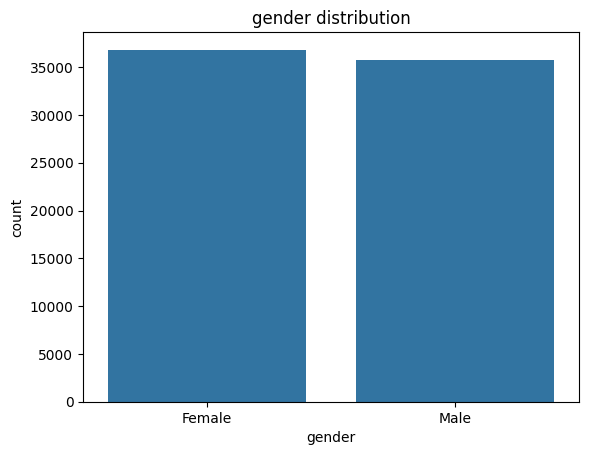

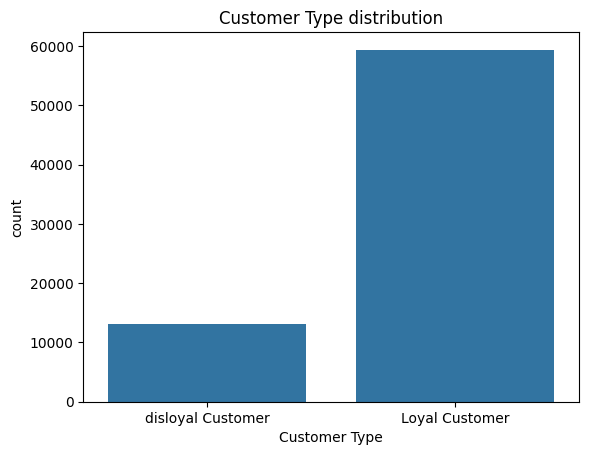

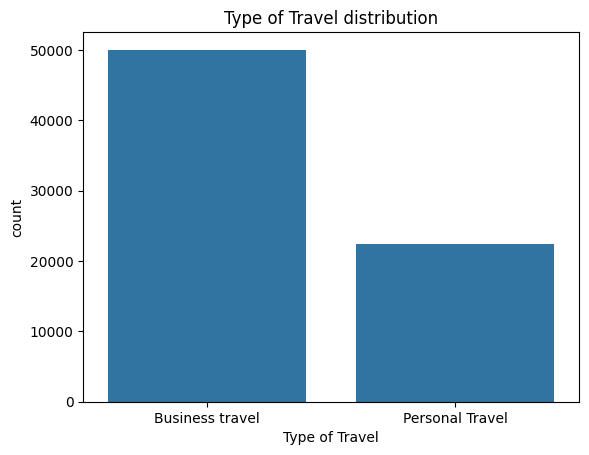

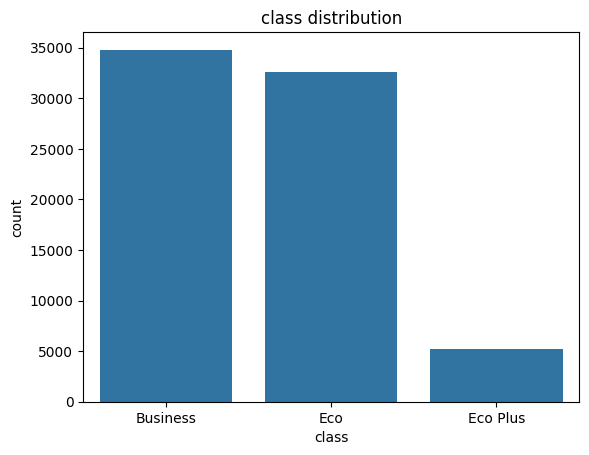

In [85]:
plot_categorical(categorical_cols, X_train, y_train)

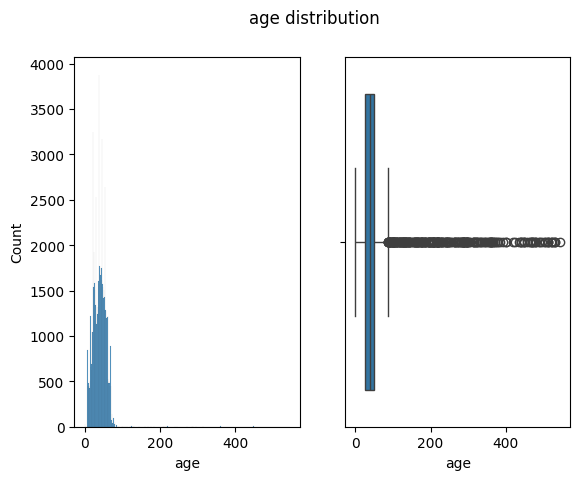

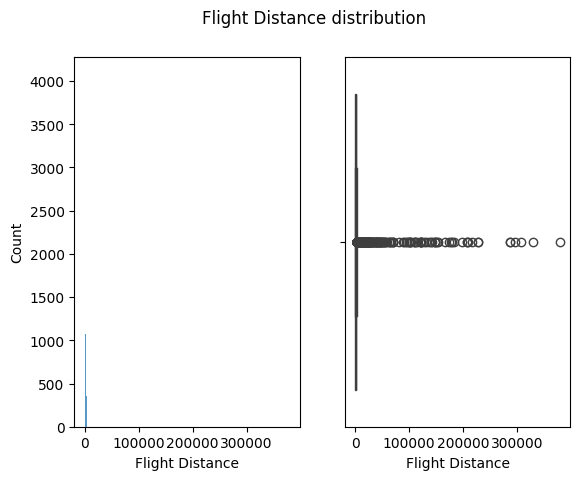

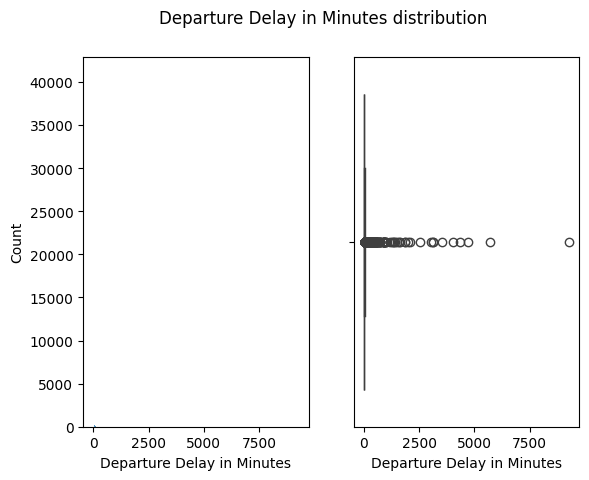

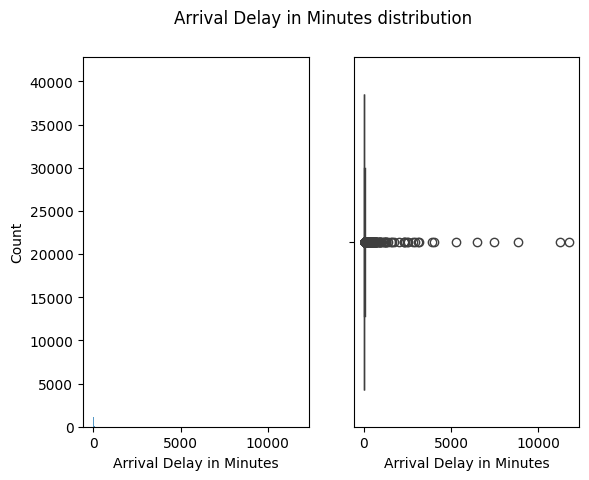

In [86]:
plot_continuous(continuous_cols, X_train, y_train)

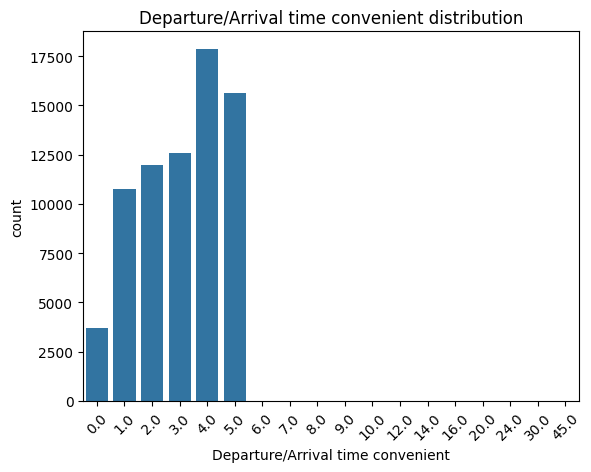

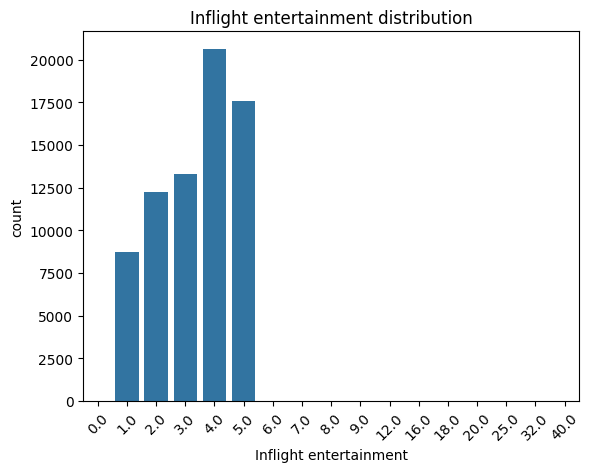

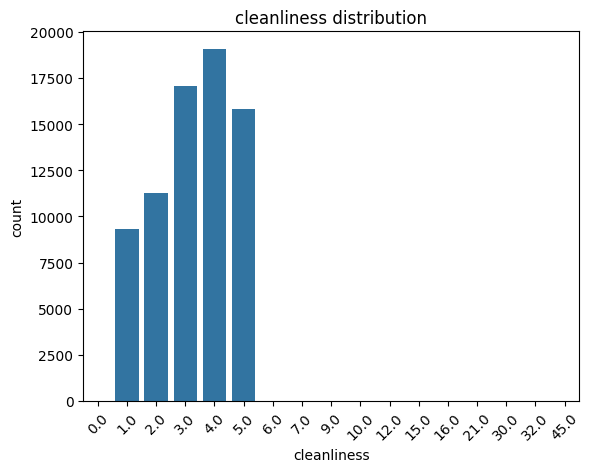

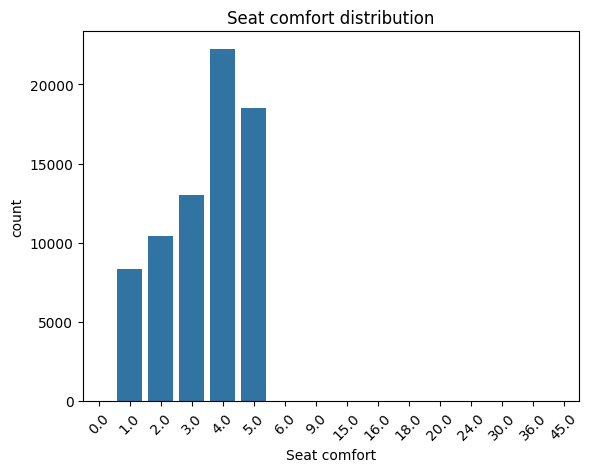

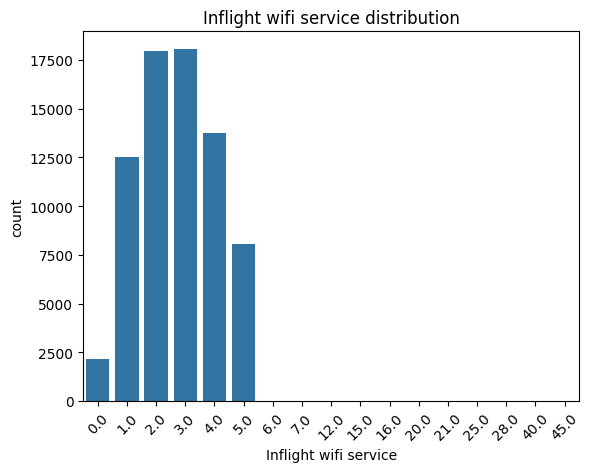

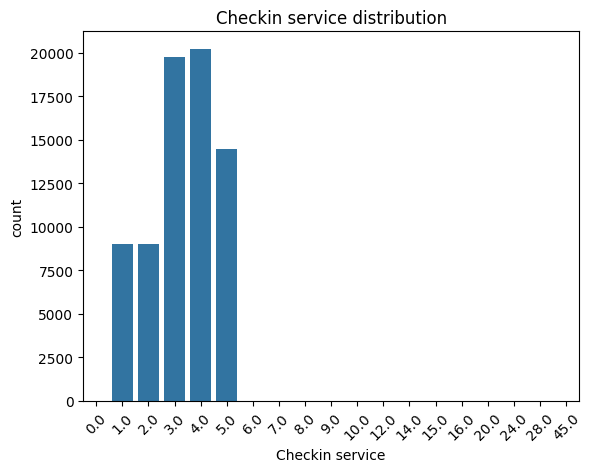

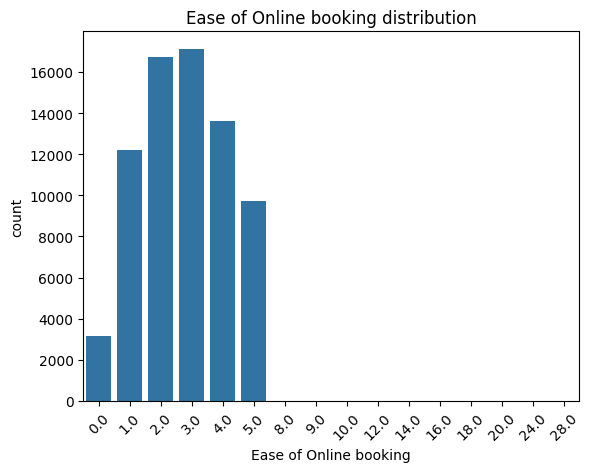

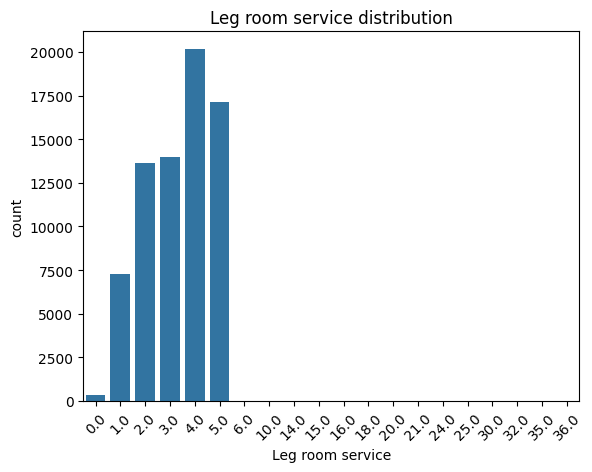

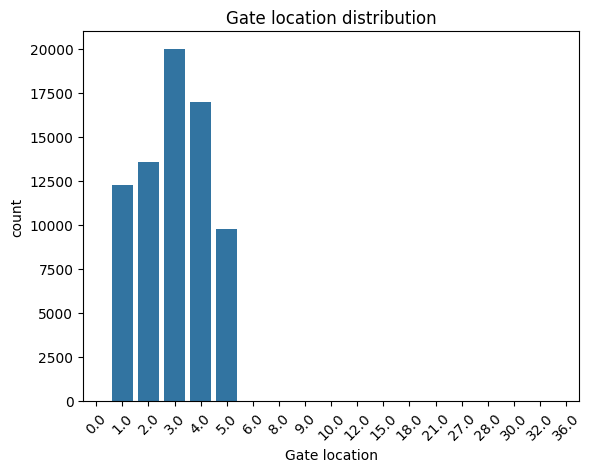

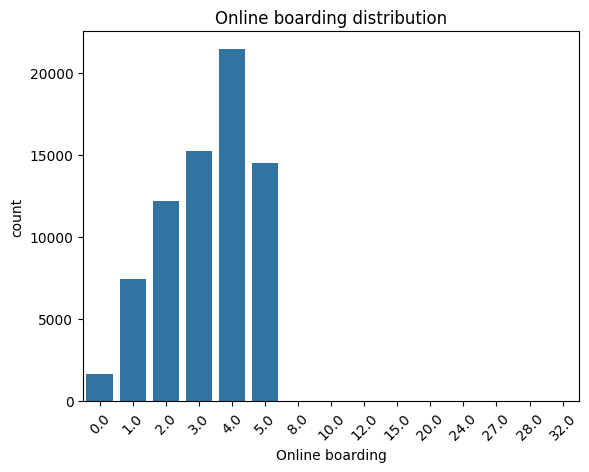

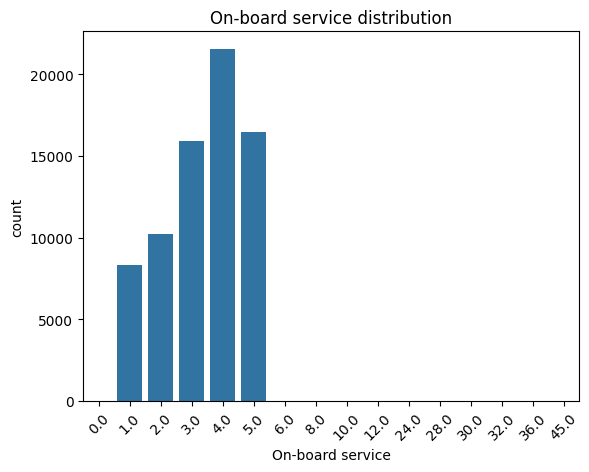

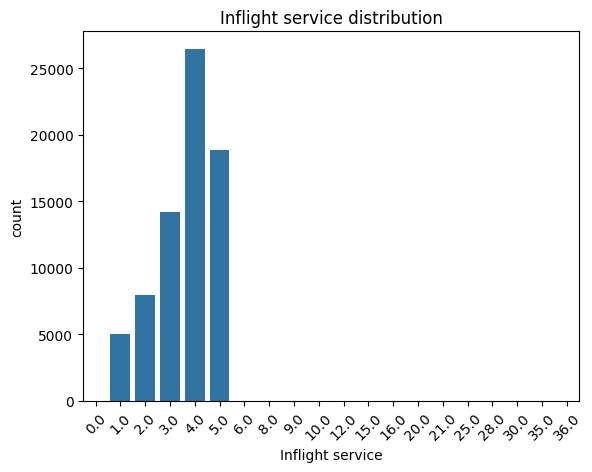

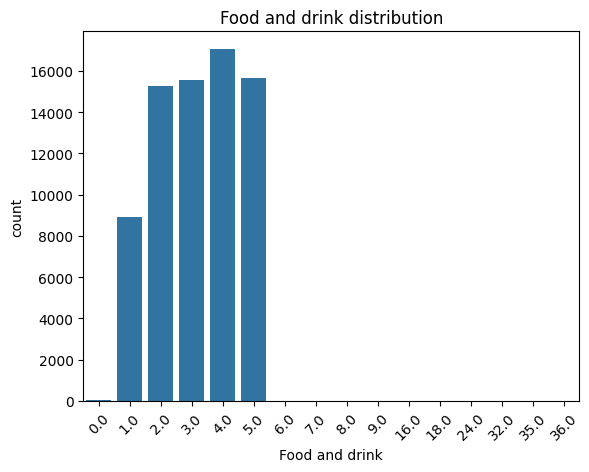

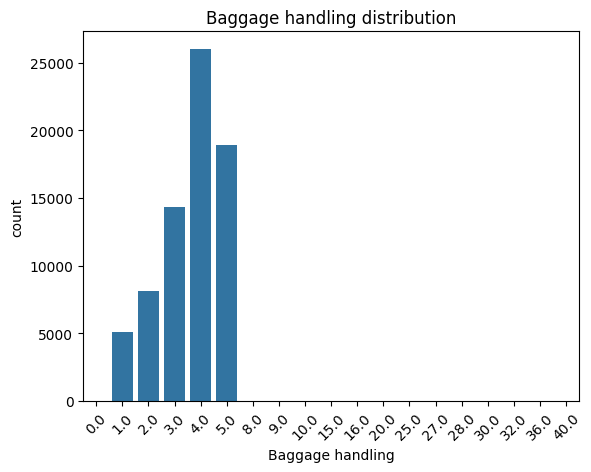

In [87]:
plot_ordinal(ordinal_cols, X_train, y_train)

In [88]:
# visualize y_train

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Ваш ответ здесь
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [89]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [91]:
# Ваш код ниже

X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = np.log1p(X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']])

Построение.

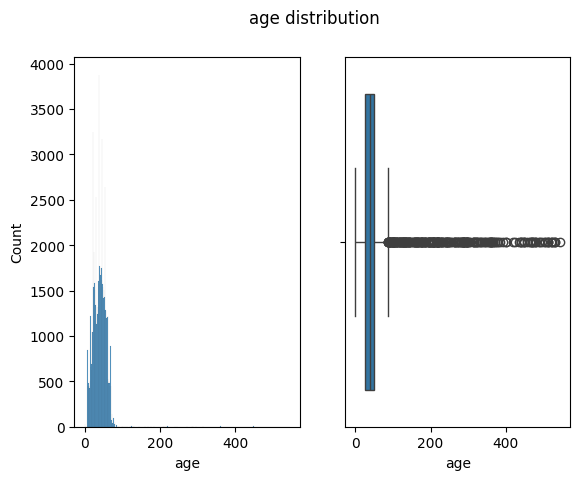

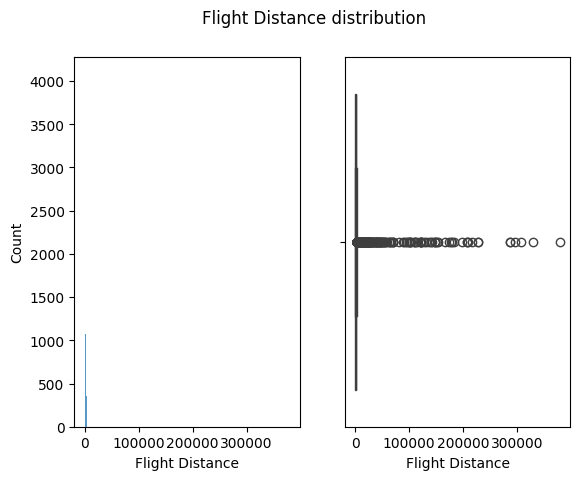

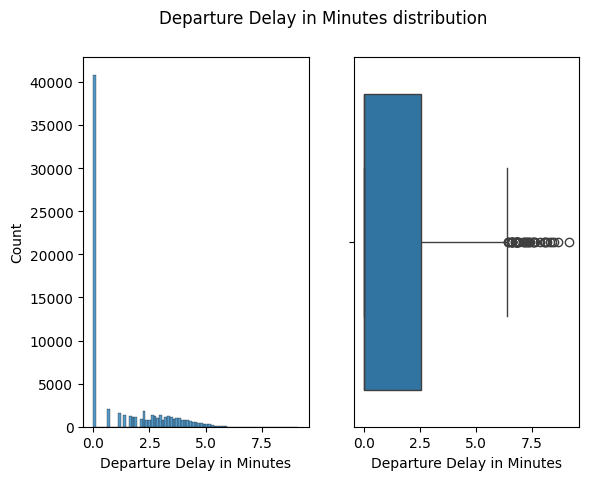

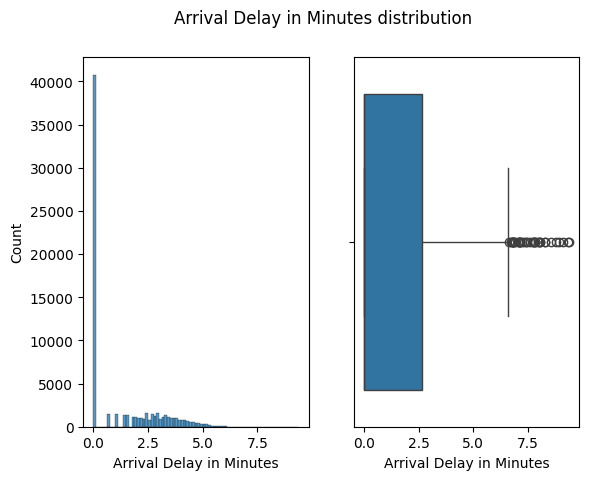

In [92]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

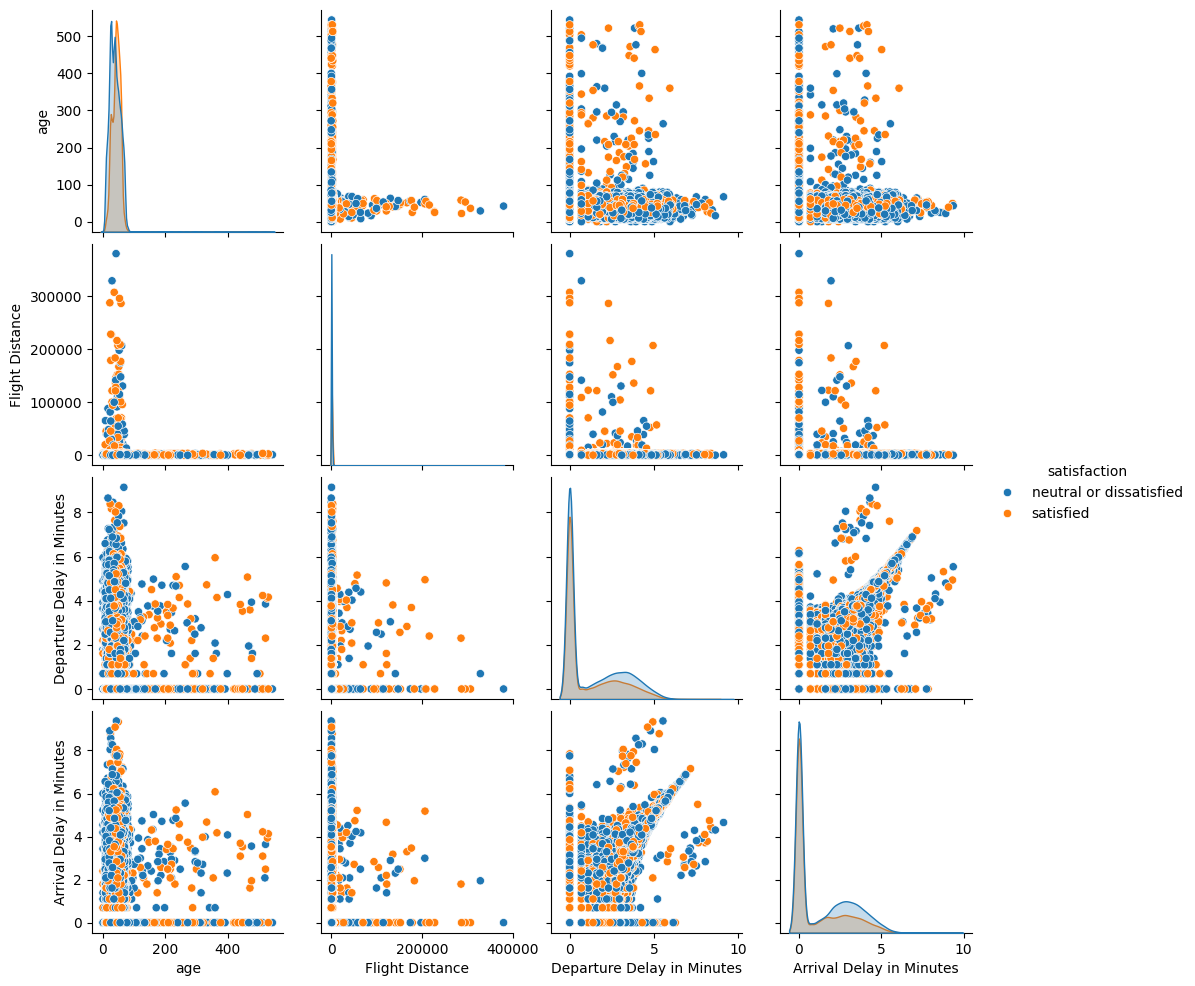

In [93]:
# Ваш код ниже

sns.pairplot(pd.concat([X_train[continuous_cols], y_train], axis=1), hue='satisfaction')

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [94]:
# Ваш код ниже
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)

y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [ ]:
preprocessor = Columnt

In [110]:
ohe = OneHotEncoder(sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[categorical_cols])

X_val_cat = ohe.transform(X_val[categorical_cols])

In [111]:
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(categorical_cols))

X_val_cat = pd.DataFrame(X_val_cat, columns=ohe.get_feature_names_out(categorical_cols))

In [121]:
X_train = pd.concat([X_train[continuous_cols+ordinal_cols].reset_index(drop=True), X_train_cat], axis=1)

In [122]:
X_val = pd.concat([X_val[continuous_cols+ordinal_cols].reset_index(drop=True), X_val_cat], axis=1)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [181]:
y_train.value_counts(normalize=True)

,proportion
satisfaction,
0,0.566272
1,0.433728


In [182]:
# Ваш код ниже
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

prediction = model.predict(X_val)

accuracy_score(y_val, prediction)

0.918569498938702

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [126]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp(model, X_train.values, y_train.values, X_val.values, y_val.values, loss ='0-1_loss', random_seed=42)
error_dt, bias_dt, var_dt

(0.08505435132179842, 0.05515533543448897, 0.06592332925966424)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [128]:
# Ваш код ниже

print('Глубина дерева:', model.get_depth())

print('Количество листьев:', model.get_n_leaves())

Глубина дерева: 31
Количество листьев: 2063


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [138]:
# Ваш код здесь

feature_df = pd.DataFrame({'Признаки':X_train.columns, 'Важность':model.feature_importances_}).sort_values(by='Важность', ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'Online boarding'),
  Text(1, 0, 'Inflight wifi service'),
  Text(2, 0, 'Type of Travel_Business travel'),
  Text(3, 0, 'Inflight entertainment'),
  Text(4, 0, 'Checkin service'),
  Text(5, 0, 'Flight Distance'),
  Text(6, 0, 'age'),
  Text(7, 0, 'Customer Type_disloyal Customer'),
  Text(8, 0, 'Baggage handling'),
  Text(9, 0, 'Gate location'),
  Text(10, 0, 'class_Business'),
  Text(11, 0, 'Inflight service'),
  Text(12, 0, 'Seat comfort'),
  Text(13, 0, 'Type of Travel_Personal Travel'),
  Text(14, 0, 'Customer Type_Loyal Customer'),
  Text(15, 0, 'Leg room service'),
  Text(16, 0, 'Arrival Delay in Minutes'),
  Text(17, 0, 'cleanliness'),
  Text(18, 0, 'On-board service'),
  Text(19, 0, 'Departure Delay in Minutes'),
  Text(20, 0, 'Departure/Arrival time convenient'),
  Text(21, 0, 'Ease of Online booking'),
  Text(22,

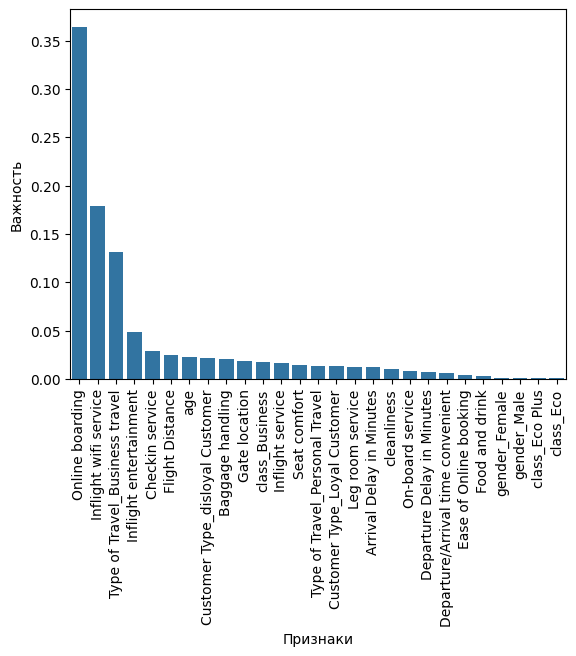

In [141]:
sns.barplot(x='Признаки', y='Важность', data=feature_df)
plt.xticks(rotation=90)
plt.show()

`Online boarding, inflight wifi service, type of travel_buisness travel`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [183]:
# Ваш код здесь
model = DecisionTreeClassifier(max_depth=5)

model.fit(X_train[['Online boarding', 'Inflight wifi service']], y_train)

prediction = model.predict(X_val[['Online boarding', 'Inflight wifi service']])

accuracy_score(y_val, prediction)

0.8240174953367209

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [151]:
X_train[['Online boarding', 'Inflight wifi service']]

,Online boarding,Inflight wifi service
0,2.0,2.0
1,2.0,0.0
2,3.0,3.0
3,5.0,4.0
4,5.0,5.0
...,...,...
72545,1.0,1.0
72546,2.0,2.0
72547,4.0,4.0
72548,4.0,4.0


In [146]:
dot = export_graphviz(model, out_file=None, feature_names=X_train[['Online boarding', 'Inflight wifi service']].columns,
                      class_names=[str(i) for i in model.classes_], filled=True, rounded=True, special_characters=True)

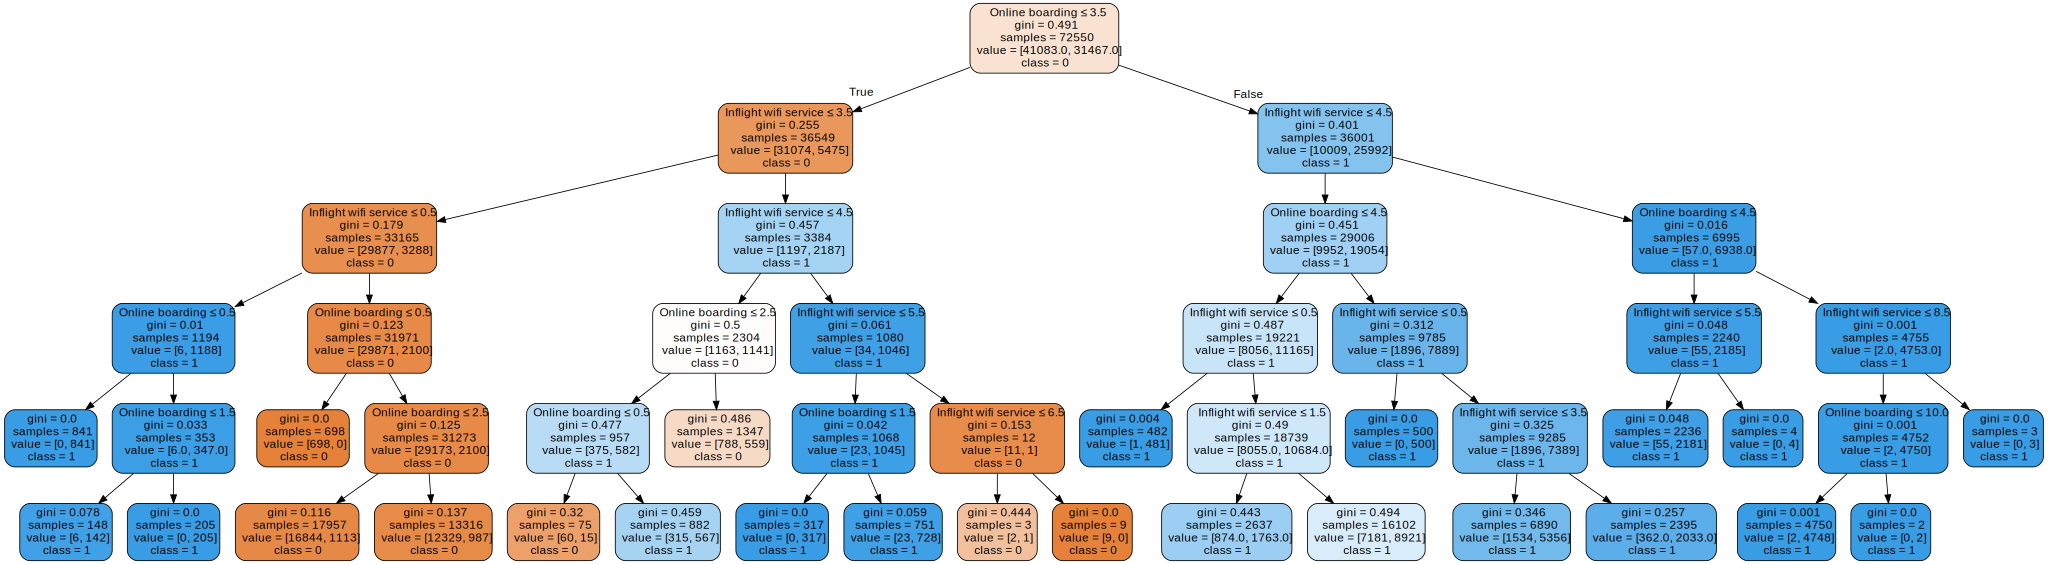

In [150]:
graph = Source(dot)
graph

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

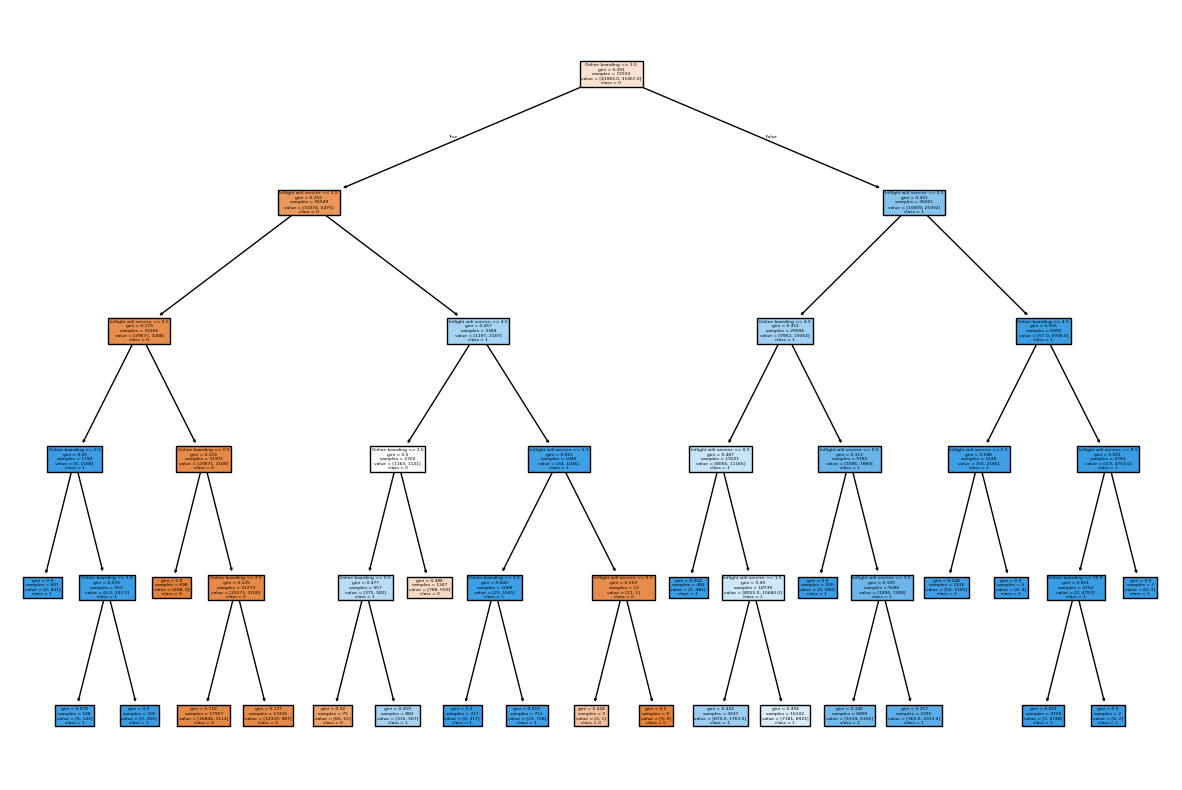

In [162]:
# Ваш код здесь
plt.figure(figsize=(15,10))
plot_tree(model, filled=True, feature_names=X_train[['Online boarding', 'Inflight wifi service']].columns, class_names=[str(i) for i in model.classes_])
plt.show()

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

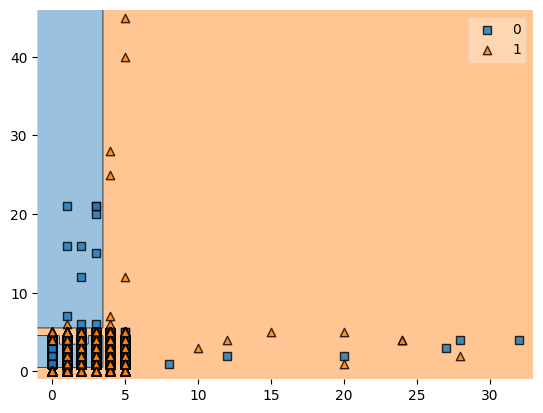

In [163]:
# Ваш код здесь

plot_decision_regions(X_train[['Online boarding', 'Inflight wifi service']].values, y_train.values, clf=model)

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

KeyError: '[1777, 30978, 12740, 5733, 17482, 14616, 42032, 28516, 6103, 26378, 13645, 6686, 6411, 3304, 25913, 39576, 41300, 30954, 22512, 63329, 44558, 44017, 30747, 39123, 57959, 11621, 37983, 50539, 36862, 1358, 2130, 8897, 16593, 19284, 48789, 65596, 50634, 7887, 68640, 67384, 9663, 57583, 68043, 46502, 32692, 45633, 26051, 67538, 2548, 28674, 50110, 29801, 34427, 9700, 43906, 64912, 28756, 51383, 55097, 54958, 34754, 31139, 38384, 24450, 69752, 34, 9392, 48881, 61101, 63256, 56872, 29425, 34904, 23693, 54078, 26072, 26981, 18920, 38945, 23655, 5740, 60259, 20225, 16990, 63691, 33521, 70685, 50848, 41660, 16843, 43342, 64428, 56518, 65877, 39343, 60334, 391, 53879, 26094, 20921, 1622, 45294, 8739, 66350, 66988, 36039, 63168, 40921, 4534, 38574, 34217, 7864, 38159, 41480, 33771, 53122, 55176, 4222, 5512, 16918, 47917, 14131, 24370, 5055, 29586, 5451, 28709, 34786, 6866, 53349, 72408, 8236, 42125, 47721, 67336, 38756, 71948, 18349, 65307, 28320, 14986, 60506, 60387, 35418, 48172, 57038, 28622, 12485, 37248, 66681, 67557, 45030, 48061, 50645, 33432, 23362, 50936, 32760, 63763, 12033, 23301, 44084, 52930, 9444, 13753, 13397, 50243, 71155, 28491, 16643, 10649, 12332, 7821, 30220, 24498, 25336, 46537, 27557, 40536, 49414, 37978, 34606, 25115, 67986, 28671, 27966, 52665, 2396, 49635, 71949, 71793, 29141, 10341, 22318, 51909, 4851, 68421, 9461, 20977, 70202, 48951, 26222, 8382, 436, 9843, 45460, 6704, 55368, 61328, 15065, 13968, 19149, 2940, 10045, 9741, 22570, 12702, 70377, 57085, 61529, 36818, 18451, 11678, 63536, 26236, 47907, 63228, 44317, 44631, 39362, 53455, 46040, 30425, 54561, 44035, 65660, 30248, 6364, 15604, 28139, 56538, 46922, 25348, 67010, 66281, 7242, 47208, 71232, 50363, 517, 66853, 3815, 49940, 65467, 64390, 35350, 38393, 50498, 69288, 17618, 22324, 15346, 21414, 33924, 63872, 8512, 40614, 651, 40741, 21927, 31148, 3782, 7013, 804, 66245, 19289, 54993, 16614, 48999, 8270, 26725, 22360, 4554, 35625, 14026, 46791, 29115, 62919, 57605, 15172, 32460, 38177, 61857, 67787, 18402, 47743, 70284, 26063, 15525, 41247, 19199, 38567, 1375, 21493, 37970, 38683, 54593, 51263, 13541, 53038, 59595, 37735, 27337, 5015, 17765, 69223, 27862, 45130, 47814, 26574, 21563, 30391, 37791, 24403, 26659, 28312, 49704, 47226, 61152, 10905, 2256, 33171, 9643, 57357, 30906, 32113, 2852, 58540, 4239, 9365, 35190, 5059, 33968, 46178, 32311, 18664, 15477, 64675, 45312, 68834, 49628, 36990, 9326, 10392, 38410, 52163, 47733, 61882, 61092, 53560, 39062, 50833, 66893, 45274, 69356, 62019, 19046, 71220, 51086, 37823, 15774, 61943, 42978, 25510, 31245, 38773, 71736, 64359, 56265, 36078, 23273, 64954, 47745, 45645, 59505, 10108, 22616, 53243, 57774, 10767, 50501, 27029, 12648, 35649, 25616, 30837, 40105, 71507, 40108, 42334, 573, 22255, 71039, 50405, 55520, 52455, 69112, 52512, 19201, 55920, 54116, 48283, 18017, 54849, 53589, 36661, 24359, 59480, 65758, 39025, 20140, 13462, 1522, 20886, 60709, 127, 48373, 44481, 5867, 2589, 9877, 35471, 15613, 69837, 31742, 69066, 62417, 40245, 68668, 34866, 5944, 31948, 22234, 7251, 7346, 45133, 54336, 33192, 24445, 69074, 18394, 20014, 25267, 65262, 28656, 25452, 60146, 56124, 5317, 48748, 63888, 57507, 36934, 66398, 22326, 72438, 44372, 69920, 28089, 5811, 40848, 12405, 117, 29212, 38549, 32778, 23783, 16524, 39168, 17420, 61971, 69085, 38757, 50244, 50730, 63101, 69264, 68121, 69796, 41406, 67275, 11630, 51347, 55110, 15784, 29181, 31039, 28452, 47251, 7398, 52935, 23465, 70093, 13381, 19113, 24234, 25240, 35404, 51343, 40350, 25946, 30189, 18631, 49181, 24225, 70677, 18909, 24007, 32998, 5399, 64263, 45685, 49551, 16292, 7504, 71165, 44082, 21299, 4020, 71347, 13247, 47051, 22628, 64515, 44927, 41623, 10869, 53056, 70499, 55375, 29047, 11328, 27982, 2165, 3418, 52148, 51828, 28817, 72037, 1774, 7107, 64882, 26289, 28428, 59487, 11390, 9329, 65185, 16193, 10870, 9130, 56334, 10141, 8124, 44719, 29599, 27246, 72372, 70592, 67795, 22239, 24618, 67615, 9167, 30212, 69799, 4716, 50958, 69834, 28669, 51371, 61500, 55104, 63410, 52780, 14660, 59305, 38358, 37671, 72371, 55734, 32526, 53857, 40941, 34114, 64801, 52006, 18399, 70794, 53286, 63891, 29003, 19005, 56512, 48349, 67746, 58986, 57341, 9225, 6210, 44203, 19552, 31302, 64921, 71539, 62289, 61738, 59915, 16506, 55024, 41156, 32299, 14977, 19832, 31024, 28659, 110, 57800, 10011, 68903, 36348, 29321, 48294, 4159, 62052, 29668, 13647, 39256, 18251, 68611, 22961, 55539, 48451, 51782, 4840, 63014, 63143, 40373, 6072, 58035, 72144, 25852, 67193, 70472, 71711, 10435, 21401, 70946, 21120, 56946, 37829, 20851, 46000, 15804, 58578, 44674, 18237, 63216, 19955, 45841, 60777, 55930, 60629, 6804, 56374, 44864, 24378, 62829, 24102, 54259, 34493, 53542, 11111, 63959, 7876, 8368, 5459, 28844, 64666, 3077, 21144, 1874, 25601, 16166, 55954, 38116, 47136, 15949, 17394, 5614, 51926, 16595, 50914, 21063, 14180, 68658, 46389, 7297, 62508, 36802, 28777, 20199, 29919, 43321, 8288, 49331, 59939, 34678, 46899, 72437, 28519, 16414, 48576, 68270, 69436, 15582, 37346, 8667, 11670, 40409, 18922, 8814, 4758, 45253, 10158, 50288, 42369, 72016, 67383, 67882, 26185, 25206, 15573, 41093, 28643, 13043, 12911, 26825, 5110, 39340, 38360, 71573, 72327, 31040, 5601, 41169, 8227, 46916, 18880, 64626, 57371, 54526, 35158, 22097, 18005, 64733, 34734, 33510, 67292, 42973, 53046, 35030, 17208, 16931, 23292, 38333, 37291, 14203, 61289, 9207, 11043, 8295, 3159, 68022, 4329, 15315, 22381, 5223, 57372, 47582, 14911, 36944, 35194, 51784, 3881, 18675, 5980, 19360, 58654, 34669, 23048, 26774, 30953, 68511, 36562, 48408, 43037, 35589, 64715, 13938, 9900, 4991, 40207, 67004, 35728, 55757, 39435, 18389, 59259, 34879, 16104, 65728, 57973, 18906, 2115, 33873, 38334, 56957, 55591, 33903, 60938, 59461, 28945, 67045, 7191, 71307, 24950, 65310, 33515, 51710, 54197, 1119, 10022, 11962, 947, 48369, 43130, 65141, 48275, 67065, 49618, 42610, 13640, 44147, 13653, 67269, 44386, 56075, 42684, 27786, 30350, 36583, 19527, 64547, 32899, 52884, 31951, 30534, 28202, 1828, 31685, 54492, 59218, 17185, 21189, 47356, 46189, 65426, 60876, 16908, 32308, 39468, 13750, 12943, 30290, 25066, 23384, 17962, 38993, 67042, 12925, 9569, 27417, 66337, 36270, 13746, 26369, 64767, 62799, 55295, 66032, 21357, 18429, 49230, 37615, 52505, 3945, 63688, 7255, 22130, 58815, 55027, 24418, 8840, 70639, 59285, 57756, 49640, 40465, 64308, 67841, 46540, 34016, 53740, 47962, 21841, 54019, 28935, 66151, 6406, 7969, 54795, 32169, 53961, 10926, 10439, 51356, 25845, 19988, 59820, 18814, 13220, 4046, 28482, 12570, 50654, 4568, 2766, 59052, 33165, 30006, 68120, 33980, 20168, 64962, 5285, 55468, 16672, 43219, 36400, 71336, 33330, 70737, 6080, 50648, 45935, 42503, 1727, 38522, 55015, 28701, 50198, 60957, 63258, 2768, 56702, 66486, 22365, 35254, 48667, 62657, 40115, 8036, 14497, 38966, 62601, 64772, 56377, 56390, 14495, 70252, 55422, 24492, 62410, 61600, 57493, 62308, 70919, 12006, 32722, 13372, 8016, 50368, 70456, 16765, 34834, 26202, 47068, 35061, 42844, 58534, 7079, 32122, 1285, 13155, 67043, 17642, 15442, 18624, 549, 41018, 41151, 45964, 15978, 37897, 34374, 59092, 46882, 36837, 1934, 18731, 14666, 14785, 56564, 17520, 6893, 62873, 40380, 29292, 818, 63236, 1550, 66645, 22692, 32832, 25451, 66499, 56907, 5525, 56986, 19771, 29226, 3911, 45375, 6767, 66417, 13758, 4537, 30620, 43888, 22019, 13817, 20184, 31175, 69305, 14299, 23563, 4155, 49323, 12298, 18549, 22146, 16585, 38443, 19575, 67453, 30376, 4272, 57893, 29423, 41927, 25014, 48112, 15216, 6006, 32823, 12452, 20030, 56219, 47369, 61993, 14917, 62227, 63515, 30940, 45819, 28750, 52308, 50651, 70106, 42440, 16154, 70105, 72310, 25168, 25733, 3048, 14345, 32548, 68004, 26015, 38378, 328, 38183, 24368, 59197, 60010, 65518, 4979, 67812, 737, 57827, 36380, 47028, 1441, 60541, 61516, 4204, 37711, 51260, 70149, 68131, 48791, 15828, 65294, 14985, 31729, 22268, 46975, 12595, 42700, 35596, 1725, 46889, 22271, 61280, 55504, 7826, 51681, 59673, 68637, 33702, 6345, 18431, 54817, 22034, 44514, 32386, 12178, 62928, 24758, 29142, 11102, 15975, 7109, 13171, 20671, 4196, 69484, 26313, 57467, 51395, 27168, 33297, 30624, 67823, 30999, 12780, 35270, 6213, 18155, 46382, 49333, 66051, 422, 59748, 11600, 35725, 17089, 1695, 18183, 23371, 14827, 53919, 67237, 61299, 52258, 66027, 50009, 67071, 51163, 65373, 3787, 14231, 21778, 8008, 70782, 45104, 40292, 15422, 44749, 58306, 55175, 47532, 30306, 39980, 68079, 10616, 45155, 24494, 65820, 30456, 36853, 7513, 46896, 30493, 23873, 1569, 44226, 28739, 54783, 7231, 40279, 39135, 18195, 19939, 66381, 65143, 22586, 48435, 16646, 48248, 7314, 57557, 23355, 1478, 9583, 66706, 2449, 3488, 13315, 39416, 23958, 38762, 10542, 8756, 46869, 7359, 6095, 37504, 45855, 35735, 57650, 49797, 43639, 30719, 32555, 38212, 18784, 13327, 34972, 64710, 26265, 50755, 26327, 36878, 28897, 29798, 46886, 17740, 21222, 55065, 34989, 14304, 8561, 48008, 20008, 8230, 53827, 64612, 51499, 55343, 22887, 42167, 1530, 40561, 36076, 36037, 30028, 53585, 68725, 51650, 17928, 62089, 67542, 64258, 39514, 51862, 27477, 42489, 51492, 50263, 47216, 58665, 59478, 16075, 40166, 43991, 29882, 45957, 39450, 46668, 32176, 1565, 69934, 16042, 46464, 5604, 31854, 49432, 40610, 40863, 8070, 34890, 9040, 51259, 64927, 7090, 9249, 3896, 61375, 56426, 64981, 71302, 30697, 63099, 38087, 3142, 46742, 56627, 26036, 26479, 5100, 6985, 56814, 19625, 58844, 47438, 9904, 62057, 2104, 11500, 21538, 62729, 9021, 5044, 4635, 39398, 44587, 49125, 25781, 2071, 23538, 63668, 53916, 23940, 22618, 63573, 64979, 58794, 65628, 35336, 1313, 52889, 22079, 49344, 10898, 37544, 63259, 11157, 71139, 62366, 66453, 58167, 11571, 36848, 8250, 70690, 9915, 58647, 5870, 57138, 16200, 19532, 30827, 21176, 65001, 29384, 15669, 14186, 71646, 29667, 31535, 44596, 58902, 2831, 30315, 66430, 46416, 22289, 65274, 4410, 152, 119, 55895, 9346, 31409, 29823, 51419, 55225, 22573, 29877, 62378, 57310, 40781, 26370, 57715, 57443, 62061, 54404, 21435, 32926, 32500, 20965, 48561, 59170, 1336, 38228, 8286, 20987, 30968, 42149, 32490, 52289, 39643, 32028, 49334, 1156, 66089, 15931, 71917, 70095, 6246, 18446, 25812, 33572, 25134, 51216, 35622, 26337, 943, 6579, 32909, 68202, 10442, 988, 48876, 63295, 68960, 9237, 37719, 19432, 18713, 56415, 37059, 65651, 9010, 49766, 27688, 38466, 3950, 54038, 47339, 3702, 61827, 55020, 35922, 62042, 31001, 52444, 25642, 63095, 27217, 24929, 68680, 39880, 29997, 34197, 71851, 17938, 7375, 15876, 24415, 61127, 59561, 2584, 35724, 54360, 1030, 11742, 15974, 28925, 9526, 61323, 52837, 21829, 43331, 64619, 34687, 9422, 61081, 8089, 66849, 71116, 29123, 12072, 63150, 49027, 57829, 19280, 4656, 16633, 63443, 56176, 31755, 32209, 22861, 52532, 68297, 33438, 18724, 65462, 8712, 20431, 4523, 45287, 17354, 16301, 59789, 62594, 16810, 11593, 65101, 62469, 26117, 29127, 68482, 70443, 25671, 22428, 37031, 18388, 65106, 71915, 376, 20370, 6476, 71074, 47190, 23598, 15817, 34234, 53257, 19815, 4112, 35606, 5550, 33922, 63749, 66479, 50523, 53949, 11846, 43551, 18319, 69414, 42784, 18609, 3053, 51323, 18652, 57339, 63885, 40779, 382, 20229, 5153, 65798, 262, 72040, 43393, 24898, 55329, 61650, 63255, 12895, 15724, 19437, 47791, 63692, 2960, 34155, 41847, 10416, 21671, 23914, 13092, 5533, 66096, 64413, 35310, 71303, 20072, 21432, 72528, 11807, 23382, 19447, 6862, 70795, 43699, 45889, 28368, 22119, 17143, 11446, 37649, 6610, 18967, 33593, 13573, 18065, 1557, 46284, 47195, 42785, 63052, 45851, 11589, 24972, 46999, 22879, 4487, 56104, 38345, 32581, 6338, 635, 43351, 24683, 3491, 30246, 26040, 61594, 23163, 13189, 48336, 58784, 41135, 70994, 54874, 44024, 52899, 53664, 3427, 41212, 34015, 2002, 31221, 7754, 25003, 55025, 44089, 64741, 18275, 17911, 9077, 14962, 67688, 15583, 19356, 21596, 54521, 29715, 46868, 46167, 60357, 70241, 9458, 27411, 25878, 46329, 3414, 31458, 47788, 7564, 34195, 15017, 23333, 62534, 63402, 40492, 49488, 33869, 24419, 23353, 36763, 63819, 12978, 15799, 43431, 40151, 23372, 9114, 54763, 50597, 50006, 23821, 12187, 22364, 30070, 31520, 58402, 10447, 61801, 25763, 19078, 33061, 40662, 16878, 17123, 13721, 68843, 42897, 51599, 31775, 19390, 69057, 16157, 34264, 59421, 53978, 68361, 32449, 52175, 14768, 70731, 17832, 18778, 28610, 1754, 63835, 28924, 25347, 44023, 57838, 1499, 45623, 20919, 66321, 26578, 26612, 60604, 55619, 67207, 16592, 656, 22398, 9384, 14454, 3903, 50770, 67262, 48704, 60370, 17846, 7712, 49448, 44098, 58138, 11942, 72464, 16957, 8566, 45410, 41346, 34094, 32465, 37135, 72491, 10431, 13679, 55369, 67855, 34445, 20037, 68965, 7703, 60188, 63966, 68830, 15218, 41099, 29946, 67222, 66283, 48085, 21072, 61136, 7693, 39748, 44450, 51708, 16925, 6450, 22273, 64858, 60245, 16940, 5827, 4436, 39456, 28967, 803, 43192, 34370, 47119, 21196, 49001, 30801, 25829, 35719, 39029, 45305, 10766, 24953, 11781, 47817, 52821, 24723, 59770, 15562, 10168, 43153, 48473, 30535, 2103, 27718, 21403, 50291, 30112, 20040, 53555, 39804, 65295, 40725, 65012, 9849, 10036, 72241, 25647, 24868, 40559, 58944, 49830, 715, 4328, 36880, 64223, 19071, 50663, 33089, 1282, 71433, 60369, 919, 11952, 43313, 17556, 51280, 41317, 12498, 64046, 36379, 71990, 44293, 58914, 7128, 67162, 7605, 6646, 50015, 38971, 58364, 43869, 34779, 10633, 49452, 30164, 42181, 70942, 36766, 27489, 19458, 49992, 37221, 54552, 71918, 37826, 24336, 850, 19480, 26310, 56732, 1415, 47436, 71315, 45161, 32520, 36962, 30708, 15450, 32895, 45702, 43242, 71714, 24082, 71621, 67343, 44513, 46386, 34430, 38660, 28076, 37472, 40543, 57880, 23628, 41200, 49391, 19427, 38339, 51692, 9580, 19774, 30250, 21187, 22761, 22691, 34471, 38720, 28971, 43848, 42868, 12893, 20088, 67546, 71837, 13271, 68538, 19936, 66962, 29973, 4286, 10974, 70974, 13683, 14995, 53167, 63265, 55823, 71988, 9840, 57199, 67852, 42605, 35951, 2802, 17610, 24641, 31207, 43642, 39211, 16757, 12692, 34981, 61538, 28077, 67232, 64586, 43399, 55863, 71644, 16052, 65560, 5090, 55373, 20592, 12775, 6428, 24124, 19142, 60598, 44160, 38142, 11755, 17815, 15307, 61278, 9948, 1772, 8114, 61353, 59710, 1571, 45271, 66288, 19221, 24704, 1650, 8784, 528, 24309, 7004, 70467, 3443, 20463, 70052, 64188, 51746, 25324, 34899, 2888, 2534, 40043, 39697, 25189, 17392, 68740, 24003, 34772, 70705, 54604, 34544, 2356, 10791, 39732, 57506, 10049, 35865, 32784, 36864, 56912, 37841, 66888, 20031, 59591, 46904, 69061, 33733, 35189, 50058, 21286, 48821, 72252, 41505, 287, 71206, 9137, 8387, 61290, 4621, 54806, 67676, 65564, 62291, 19796, 22629, 6099, 68352, 31154, 36872, 20769, 2792, 37949, 51312, 45864, 9833, 24183, 63059, 14556, 34412, 14533, 69192, 56128, 20025, 27736, 36624, 40692, 61734, 32817, 47399, 28983, 9746, 32350, 22032, 36415, 53556, 44025, 8434, 44981, 51565, 31601, 52892, 15259, 49200, 42116, 22622, 61884, 66966, 15627, 51980, 56681, 39132, 64490, 51624, 55365, 22726, 51147, 498, 66192, 47808, 23341, 66779, 42081, 15753, 5887, 45490, 17280, 9452, 36768, 47670, 7978, 21468, 10189, 41815, 29720, 38504, 10723, 36218, 28503, 15877, 25287, 65593, 69309, 6177, 10919, 24159, 60312, 43326, 15838, 57537, 15429, 70384, 7801, 41209, 35667, 24703, 47635, 38202, 31516, 3191, 49216, 15300, 16252, 70122, 6059, 65524, 16049, 42263, 26793, 52273, 63114, 52158, 15042, 29501, 48685, 15445, 65723, 5851, 34209, 7438, 57222, 23573, 37359, 68942, 38491, 13024, 57540, 42681, 4958, 25732, 14794, 66903, 40773, 68954, 36706, 47515, 55627, 26059, 52651, 61411, 66602, 11561, 708, 1160, 45564, 46898, 49454, 54385, 23900, 68305, 70547, 50856, 26426, 25606, 69427, 17188, 51112, 59628, 52260, 30232, 58674, 52430, 54580, 54992, 45378, 24153, 5874, 34991, 24673, 39378, 27638, 50993, 46958, 26445, 46832, 37590, 31941, 57130, 69850, 30210, 8449, 47224, 18248, 55288, 47146, 32020, 46884, 9918, 36085, 9989, 13585, 22873, 58999, 46217, 46923, 21083, 51551, 21224, 11174, 55965, 10171, 66324, 68552, 19957, 40122, 13729, 3354, 64620, 42035, 2274, 38503, 71505, 57280, 55004, 15289, 43238, 9081, 27728, 35836, 69482, 16886, 54269, 56592, 6209, 65828, 30585, 47270, 59288, 59005, 22454, 57485, 10867, 50924, 18327, 23990, 35483, 69052, 67982, 14900, 26930, 25381, 16298, 62301, 11761, 8027, 5623, 56247, 17954, 8740, 65234, 62669, 60573, 72145, 19468, 5254, 46607, 25796, 55528, 47712, 38696, 39637, 8983, 47601, 55758, 21233, 16388, 56553, 48696, 14300, 42628, 43842, 71745, 55307, 22984, 69281, 52940, 128, 9018, 7894, 21031, 809, 40973, 12113, 30510, 1799, 62318, 43560, 16897, 18490, 22606, 52347, 44748, 64959, 11010, 63042, 41309, 42518, 67659, 40722, 38601, 8283, 55023, 40308, 46593, 38826, 38198, 11318, 62312, 26625, 52332, 30204, 4937, 66637, 61031, 2892, 35832, 15700, 12482, 66265, 59583, 4929, 52101, 66753, 20015, 64447, 28225, 15815, 66661, 21642, 64061, 7497, 67727, 27238, 59146, 26107, 8702, 37959, 67677, 8333, 49883, 9958, 26833, 71002, 70158, 18511, 70237, 6183, 42952, 45978, 5022, 2150, 56017, 70426, 49201, 71214, 19561, 5707, 36675, 48661, 44612, 53576, 53354, 26680, 58749, 14077, 7293, 20781, 44461, 24852, 29188, 70300, 27008, 43830, 5330, 70085, 10162, 23240, 16429, 46245, 7258, 36578, 54075, 1922, 40989, 44301, 67074, 36867, 16254, 4068, 69559, 56888, 42063, 10582, 56967, 62094, 31022, 56759, 67759, 43508, 43836, 21828, 52230, 69749, 20887, 597, 9182, 2244, 32401, 34953, 71743, 45268, 46216, 18107, 8506, 11346, 65055, 37260, 30885, 15161, 46985, 71643, 65726, 45492, 67069, 45772, 49540, 25728, 27983, 24261, 12876, 65885, 7697, 7001, 21208, 70294, 60901, 17709, 59680, 39445, 37682, 8764, 27067, 57662, 42165, 67600, 48361, 23344, 42848, 21355, 5448, 69459, 17502, 16018, 23493, 51479, 33607, 8655, 44144, 50201, 22399, 24057, 27677, 39166, 3813, 5178, 15392, 53136, 29470, 70746, 55684, 57416, 38196, 49841, 48564, 44322, 55322, 58961, 58555, 56229, 36426, 48711, 58061, 18131, 6262, 7284, 64272, 30160, 1951, 43811, 26953, 71708, 52083, 17543, 46322, 47622, 20839, 19873, 48028, 34198, 56087, 60606, 27502, 51355, 15728, 64241, 48818, 12027, 47170, 54163, 50367, 45836, 32277, 2395, 38573, 12840, 49602, 8855, 38286, 50653, 13867, 61058, 72514, 38155, 1325, 30205, 15147, 14982, 7627, 59763, 3711, 37713, 40643, 17840, 4947, 55248, 43316, 70057, 3742, 69410, 68074, 1644, 34728, 20407, 1207, 43992, 68888, 1969, 69605, 17068, 886, 55522, 11501, 14625, 56285, 18877, 64450, 46761, 69472, 7559, 31992, 44494, 9573, 41700, 56109, 60799, 31662, 65797, 4711, 67722, 49427, 16, 57309, 1430, 4225, 61573, 43274, 43833, 23716, 21324, 45082, 53835, 23138, 57432, 65364, 60491, 59074, 36948, 62261, 41886, 67571, 45691, 0, 41469, 8125, 19111, 9158, 70778, 38356, 12071, 39949, 27189, 32135, 13695, 32938, 41960, 44181, 56436, 48227, 8256, 20284, 36919, 49970, 60535, 46024, 15963, 34764, 58567, 15768, 35509, 39143, 50764, 2826, 42522, 38676, 72150, 16551, 6551, 60747, 59067, 8315, 3761, 67705, 7008, 47008, 13668, 20813, 28679, 60087, 49915, 34190, 36458, 24352, 43023, 58996, 22946, 25897, 5114, 30520, 60818, 28758, 23035, 60275, 33179, 9733, 4157, 1737, 69951, 26587, 51131, 21118, 17474, 12328, 68083, 32003, 47152, 13984, 40155, 11421, 33775, 53495, 53313, 10543, 22918, 67671, 19135, 26642, 49176, 11883, 5521, 44385, 37579, 58648, 30937, 34013, 28985, 70950, 44722, 34122, 46374, 68227, 26359, 33781, 27927, 478, 72183, 10760, 62413, 52415, 57870, 14437, 1542, 46233, 9728, 2442, 58433, 38713, 9623, 68623, 38896, 52267, 5067, 51608, 72010, 47778, 44606, 27630, 48984, 1219, 15227, 57859, 57115, 52848, 30791, 12135, 189, 30489, 15066, 29990, 8492, 11553, 54310, 21340, 26568, 17024, 19583, 55924, 42988, 38956, 23274, 8903, 3088, 6558, 69943, 9164, 21580, 26748, 21368, 23132, 8352, 66455, 28479, 38996, 63797, 36212, 34452, 24679, 49678, 34858, 1243, 17881, 12938, 21943, 28891, 9657, 65125, 44971, 69639, 6530, 47044, 37163, 67167, 38785, 26526, 47849, 30416, 26860, 60346, 14705, 29926, 50398, 42313, 61640, 1036, 21725, 60962, 63334, 70468, 68094, 61494, 59377, 43855, 25580, 19159, 58316, 14247, 62336, 69249, 60444, 37285, 49643, 53960, 29061, 63648, 70909, 64972, 50451, 29392, 30458, 12859, 951, 16834, 55762, 72382, 30154, 25560, 36181, 27722, 51007, 62010, 40880, 59729, 24258, 18978, 10812, 52815, 55274, 8836, 14831, 27420, 72391, 25679, 42631, 7935, 60634, 25583, 8993, 59040, 54511, 12599, 2086, 43871, 35146, 2724, 64135, 37183, 5857, 39329, 52100, 43179, 71444, 43880, 16147, 67323, 4297, 34065, 5215, 19202, 58515, 33657, 53841, 56000, 20211, 46007, 25649, 35275, 71026, 13551, 56058, 40082, 34017, 66568, 44853, 47873, 66171, 6347, 50781, 43711, 68687, 1195, 68117, 51491, 13818, 55811, 53099, 4215, 14103, 71245, 47445, 38556, 61513, 42809, 65005, 8802, 1486, 27900, 14331, 50481, 57986, 5264, 2266, 51252, 64832, 19031, 41502, 39863, 43258, 13468, 20895, 31073, 47300, 33246, 58921, 58350, 52868, 56195, 59007, 65014, 13779, 46554, 11659, 51253, 5605, 22148, 22151, 70646, 15641, 22793, 16241, 43557, 15394, 36335, 33241, 17016, 26885, 31206, 57752, 59205, 56434, 60480, 71110, 14567, 43097, 71080, 28499, 19030, 37895, 19008, 5611, 25486, 55412, 5210, 15466, 19341, 10884, 34154, 50929, 3200, 34616, 1198, 37568, 47344, 34318, 18809, 62710, 72527, 68390, 10670, 26539, 20309, 60822, 63104, 51719, 23111, 45278, 66873, 6152, 16299, 26043, 52793, 50769, 229, 62026, 37979, 8824, 41312, 26788, 11737, 23347, 17109, 57663, 933, 14651, 34977, 29927, 66286, 41194, 44221, 9419, 6049, 31877, 71424, 61061, 40145, 36486, 59865, 65907, 42333, 62083, 46445, 60702, 43055, 32669, 29015, 66466, 68822, 33649, 62796, 67053, 66000, 46319, 63417, 29909, 53577, 40737, 29915, 54066, 66439, 67547, 60824, 44754, 56141, 15771, 66579, 3099, 29680, 18326, 12868, 17965, 15890, 26055, 53722, 36824, 66014, 43965, 66599, 17475, 21640, 15386, 37398, 68261, 28459, 71782, 56071, 39218, 34721, 30356, 33739, 61687, 61262, 31893, 45812, 14055, 34219, 69162, 56787, 30890, 49687, 7832, 3132, 38318, 54537, 17743, 23669, 20367, 22014, 149, 32593, 65215, 67002, 61019, 25714, 46424, 2029, 10240, 67046, 50090, 48592, 71944, 181, 25170, 12896, 18701, 35532, 64488, 47897, 1208, 4542, 32773, 47129, 9997, 35911, 58045, 22648, 9396, 55855, 31120, 70601, 63030, 10983, 8558, 16885, 34539, 4968, 9633, 12880, 53991, 17251, 4137, 15078, 10673, 18246, 34488, 12354, 908, 36667, 9739, 54895, 59767, 63936, 2755, 63149, 12847, 63767, 22142, 66496, 13563, 47574, 3712, 6756, 59337, 690, 11081, 65557, 10440, 33130, 21466, 45240, 9387, 11607, 23420, 63500, 39352, 51723, 47414, 68290, 35455, 59200, 5677, 38455, 25197, 24196, 20939, 14961, 59002, 66909, 36246, 47753, 13861, 58162, 20175, 70953, 6873, 7331, 48401, 28200, 53506, 32178, 69440, 54725, 17241, 43975, 70120, 67544, 10623, 8401, 31573, 5751, 53649, 11575, 71268, 46524, 55875, 45748, 15140, 12323, 324, 68026, 68151, 56371, 30009, 31177, 55404, 39887, 61741, 17755, 46733, 54747, 55075, 38929, 24895, 31191, 28621, 46452, 29661, 59587, 57541, 24136, 52249, 51548, 12025, 30102, 42126, 58390, 31652, 60965, 47726, 3749, 28693, 63711, 10337, 37252, 70435, 69811, 55975, 61490, 62545, 62599, 60979, 4118, 18749, 46528, 55615, 62951, 43527, 5097, 139, 2417, 18533, 62014, 70826, 11863, 9092, 53787, 31815, 15537, 31294, 26148, 37936, 35430, 46230, 10879, 5154, 59034, 1401, 15832, 55679, 54069, 9469, 34723, 62179, 22989, 35997, 45008, 20332, 16082, 7419, 38389, 9848, 10020, 7092, 37009, 15342, 44457, 17363, 37631, 38405, 972, 72164, 8862, 68517, 71804, 71846, 42838, 1939, 22889, 36884, 27348, 4906, 65624, 53001, 7462, 69337, 29564, 64439, 42589, 25804, 46972, 39160, 56135, 9035, 67914, 55466, 2166, 70515, 2136, 51509, 32837, 3615, 56994, 70278, 37984, 3617, 23203, 65997, 69243, 72218, 19958, 38481, 33091, 12966, 2000, 8844, 16941, 59206, 51507, 42783, 49762, 4303, 58485, 71196, 47665, 38553, 47581, 29431, 64379, 10330, 4115, 12866, 14211, 44810, 60262, 265, 10883, 53158, 40888, 37784, 62007, 27656, 2595, 15544, 38223, 69242, 28996, 674, 72096, 39985, 2570, 57468, 13075, 55966, 24298, 25067, 45634, 44243, 17000, 2344, 42112, 14161, 10044, 60458, 42764, 27889, 56, 54270, 12611, 27594, 30524, 8526, 57240, 2566, 66707, 66142, 41551, 45173, 18122, 58573, 53091, 71314, 12177, 52425, 55711, 51258, 45629, 12763, 62290, 32960, 8231, 26088, 30900, 46436, 1851, 7473, 4223, 58322, 42097, 6041, 32224, 50737, 67095, 1275, 5735, 7709, 63404, 58191, 52280, 31357, 13523, 49460, 15258, 64161, 8042, 19995, 54813, 21590, 52798, 10177, 69604, 61712, 44495, 59576, 1965, 18687, 28800, 38972, 1183, 26476, 69666, 52559, 9711, 6663, 15701, 38208, 58870, 42609, 11476, 36077, 17233, 51762, 37725, 53901, 69696, 23872, 1903, 71217, 47289, 46402, 58615, 17169, 8473, 33253, 59376, 41429, 32502, 29626, 17091, 16403, 14370, 14036, 41770, 4241, 49972, 32827, 43474, 9074, 38783, 200, 20061, 48738, 26759, 59137, 72159, 67668, 36973, 46458, 67308, 40640, 11198, 46249, 21777, 7492, 21542, 70645, 66845, 61832, 52470, 13896, 65099, 67679, 18124, 70833, 67091, 46863, 59256, 64403, 50748, 34288, 48795, 51051, 38373, 33617, 63450, 26320, 14965, 48398, 69141, 48772, 15780, 23295, 60975, 65032, 12030, 35609, 53391, 43737, 20132, 1933, 8950, 21836, 66906, 32544, 37920, 40524, 69641, 30555, 50666, 64227, 70818, 12887, 53143, 24831, 23997, 36961, 4127, 43250, 71168, 13714, 36839, 6176, 41179, 19066, 41600, 1748, 15345, 21383, 54205, 65144, 1509, 54752, 3199, 32748, 33529, 58095, 42340, 4450, 62329, 46693, 9067, 4232, 54647, 29042, 16802, 59855, 60126, 15407, 5024, 3859, 48572, 69107, 46485, 28890, 8346, 34246, 43104, 29978, 65575, 9262, 14764, 72306, 16208, 12162, 3557, 55877, 27737, 18331, 35781, 23223, 63849, 48752, 60836, 22731, 33544, 28921, 21004, 38650, 20320, 33210, 41657, 9582, 47573, 49536, 33808, 63697, 44984, 22801, 70555, 28573, 16849, 46841, 47697, 29519, 49303, 12714, 63896, 43752, 14894, 13098, 26031, 17403, 28492, 1362, 9572, 21040, 71064, 56689, 6202, 64309, 52791, 22821, 40820, 61115, 36819, 33545, 23016, 42348, 24476, 56885, 14956, 30993, 8892, 49920, 37280, 31991, 48056, 60532, 35417, 59499, 6480, 19898, 65371, 48962, 299, 14109, 55697, 12432, 48594, 53587, 42641, 18441, 21558, 71663, 23507, 30818, 10624, 55046, 8949, 66855, 3670, 40596, 32422, 58169, 71575, 3312, 45910, 42249, 21115, 17346, 726, 62722, 52378, 4718, 56047, 62164, 57245, 32317, 2288, 53193, 21623, 54541, 13770, 37347, 34942, 54277, 39156, 22214, 54911, 30659, 358, 18986, 4036, 20844, 10076, 7233, 72080, 71267, 35442, 61339, 14461, 23579, 54042, 17159, 71616, 62171, 29979, 2540, 68298, 40805, 50897, 8896, 67804, 58140, 3614, 31476, 7033, 57487, 47132, 64446, 69893, 20467, 6932, 57192, 35940, 30234, 63416, 59644, 52134, 63271, 39485, 60466, 17734, 10434, 62702, 69679, 8362, 135, 40974, 8033, 18832, 13130, 28006, 8032, 7751, 9827, 63825, 5350, 7519, 65618, 71911, 59524, 14424, 49405, 39560, 70719, 70927, 63559, 4667, 5737, 23245, 1879, 57624, 4564, 62876, 51467, 25605, 10553, 32032, 49511, 6924, 66558, 43779, 67954, 31724, 39152, 38040, 50104, 69160, 58328, 51688, 28366, 25400, 15692, 64931, 43755, 54110, 10167, 62253, 37849, 2336, 49611, 12172, 45430, 54684, 54420, 31668, 12184, 2280, 11599, 2019, 7051, 26437, 52268, 61571, 32919, 20216, 63166, 62453, 62608, 66816, 71144, 22766, 59779, 54873, 61515, 2475, 45664, 41813, 19700, 62866, 39557, 46266, 8835, 55358, 47898, 43840, 1635, 405, 7301, 4143, 14638, 52323, 3706, 589, 35022, 7984, 49652, 64485, 36560, 2053, 54504, 66129, 3420, 31226, 58767, 59747, 3286, 48494, 71810, 10550, 54201, 38543, 54545, 26817, 16421, 60912, 25057, 68708, 2109, 12078, 24572, 21826, 15747, 48555, 69003, 62406, 70035, 34411, 70309, 46395, 28295, 70428, 44644, 28245, 21254, 48166, 8233, 20100, 50039, 69303, 45230, 11337, 13619, 53893, 55804, 7682, 29744, 51523, 1006, 34506, 17835, 63921, 57549, 958, 32902, 5513, 22281, 1487, 46993, 47867, 61891, 60008, 56982, 66688, 7260, 70234, 26927, 42615, 39309, 40069, 2261, 55837, 72536, 58097, 58984, 43773, 60849, 6841, 29789, 55260, 20910, 60304, 46156, 1095, 6844, 49854, 23495, 105, 40190, 8793, 39251, 21139, 41998, 72430, 21658, 70484, 48409, 7484, 21003, 41541, 7060, 43311, 19331, 30955, 13987, 37138, 6302, 16905, 42614, 15324, 12226, 3909, 30346, 48603, 16340, 2258, 27050, 52428, 63164, 60001, 18821, 63961, 8619, 52037, 56864, 16422, 55743, 54856, 72340, 25623, 64259, 19089, 2942, 44389, 65016, 51238, 62827, 4357, 66771, 32430, 59563, 31857, 38161, 33316, 15766, 15016, 4105, 33203, 15118, 22688, 34138, 65329, 43648, 34455, 57299, 32335, 3115, 44736, 55825, 15888, 51458, 4493, 58166, 58336, 9942, 43067, 48224, 24887, 39149, 71964, 60037, 58526, 3289, 40355, 14281, 11080, 69331, 16714, 5343, 31296, 46969, 48692, 34342, 71455, 16103, 66153, 53464, 16695, 29583, 27943, 60426, 13739, 56567, 40646, 20024, 56376, 21924, 12739, 21283, 36408, 63611, 61720, 48834, 34700, 51357, 16306, 64971, 34921, 29290, 16264, 49749, 30699, 24074, 63826, 11367, 38335, 72378, 6117, 7951, 13610, 65956, 16343, 31824, 71597, 17857, 3985, 41859, 3326, 43408, 52676, 7666, 56818, 35, 30182, 70492, 12430, 57087, 43460, 1071, 7865, 27607, 37051, 12257, 649, 56926, 54764, 18683, 43505, 57913, 56476, 70390, 26805, 40161, 37074, 45066, 11341, 37498, 68221, 35014, 28977, 44638, 1416, 12964, 71747, 7699, 5665, 60002, 24241, 9514, 10861, 7261, 36283, 39881, 28133, 20764, 30602, 17450, 25427, 16486, 43066, 18163, 42472, 57404, 10829, 61199, 49239, 7543, 56835, 57010, 12734, 16704, 32248, 32738, 51641, 35101, 69833, 26441, 16959, 9908, 18930, 12579, 64457, 47259, 40254, 22866, 26193, 15282, 23480, 35013, 65397, 58587, 47085, 62514, 54498, 5625, 51473, 51986, 31673, 27649, 33720, 34675, 48763, 65409, 24699, 40078, 48304, 47980, 38248, 32944, 24806, 36264, 19219, 53364, 10890, 65360, 69798, 48173, 26452, 29138, 47771, 39729, 40453, 58015, 52131, 814, 20881, 5352, 326, 59304, 44735, 47314, 65961, 64963, 38782, 29762, 17659, 53815, 36082, 45768, 63251, 27855, 29007, 31781, 32681, 56206, 2754, 58601, 6408, 61714, 62296, 3952, 25651, 55838, 47772, 42320, 15076, 71895, 47318, 70315, 44677, 34311, 27519, 70043, 44148, 56382, 24564, 14361, 20931, 61585, 1806, 7701, 27406, 13736, 66577, 10130, 69711, 21861, 53339, 38729, 19191, 4516, 42770, 1315, 67230, 5523, 53460, 48209, 28478, 41320, 27893, 60436, 19713, 44271, 41865, 51012, 60526, 62647, 24674, 69031, 1301, 37046, 67139, 4987, 51417, 59438, 71587, 59129, 17696, 58444, 29275, 63126, 29690, 54190, 22734, 58496, 29358, 51365, 71706, 18086, 49533, 8487, 43921, 40100, 63107, 71526, 71883, 44055, 43001, 13357, 40694, 21349, 16854, 20194, 58583, 68546, 39597, 64281, 40352, 52232, 19823, 30431, 53750, 61293, 44958, 26619, 29916, 54392, 32431, 19566, 17977, 34196, 58577, 36925, 6638, 60450, 71881, 34541, 29246, 33042, 1764, 63609, 47755, 6799, 60745, 72105, 23797, 69092, 36214, 70669, 66457, 14400, 48586, 23373, 8601, 61935, 25954, 12169, 36016, 41979, 32118, 31541, 12875, 47137, 25124, 30468, 8591, 53368, 6548, 25779, 5609, 67539, 40114, 55977, 7987, 14476, 42066, 16117, 16212, 27810, 35878, 49351, 69152, 23889, 61325, 15886, 64355, 27066, 66181, 54147, 20590, 13022, 8203, 2918, 45339, 4280, 4051, 19228, 42272, 64540, 62821, 30146, 24226, 8476, 61758, 57847, 41330, 63943, 34049, 69769, 7968, 67920, 5339, 18283, 56032, 53345, 12545, 20454, 55751, 62770, 19548, 67898, 68059, 63100, 31133, 34020, 750, 34529, 21367, 22458, 23407, 65863, 24198, 45382, 53307, 53667, 34826, 63245, 30162, 52592, 42280, 45038, 36209, 25674, 7508, 47563, 52984, 62431, 44781, 13210, 58955, 30668, 40101, 63438, 50959, 59972, 70322, 49212, 63307, 12971, 10089, 59535, 10306, 1591, 19546, 38775, 56078, 68191, 55854, 70389, 41823, 50447, 34647, 36611, 16209, 47083, 10256, 2153, 46326, 6088, 41989, 22680, 43675, 58215, 5890, 52454, 35358, 28065, 24366, 4563, 31178, 18615, 15003, 54117, 16047, 47586, 48339, 21620, 36745, 71092, 29777, 48250, 36362, 37522, 47377, 42314, 29716, 44376, 22967, 40919, 12798, 48259, 45007, 4922, 62885, 44259, 13723, 38011, 51411, 67906, 63695, 54273, 5537, 30019, 36619, 44697, 15684, 6581, 61138, 1254, 12457, 23466, 52124, 59542, 55733, 58570, 29419, 19072, 11471, 31540, 69606, 8496, 25929, 986, 9961, 1405, 31149, 33906, 57724, 70738, 52040, 25308, 49899, 16402, 42093, 56343, 68257, 70751, 19154, 40391, 17379, 67714, 41999, 20673, 18471, 69758, 6014, 39894, 27827, 65337, 13820, 27286, 23874, 9878, 11407, 27520, 57544, 37669, 10242, 51872, 71838, 66216, 61685, 34470, 18160, 44636, 14524, 62494, 40514, 42006, 5057, 6151, 12521, 59434, 65029, 13554, 57092, 33382, 12713, 55883, 35212, 4604, 55436, 9052, 51317, 41304, 10390, 32888, 32081, 2008, 6633, 66726, 68299, 44908, 1593, 58017, 46697, 19203, 36968, 51923, 3337, 62142, 9310, 2058, 8715, 6404, 54617, 5087, 65680, 2783, 11954, 50390, 53403, 34102, 21108, 8267, 40132, 48184, 58574, 68049, 19451, 28418, 30266, 58640, 65897, 648, 71235, 12625, 29962, 37228, 56931, 5401, 47053, 31143, 12156, 53275, 20418, 40838, 10373, 62706, 57161, 9485, 3525, 54761, 72034, 34086, 72114, 15031, 3713, 28226, 23297, 33608, 40137, 17732, 8826, 12800, 36050, 19392, 59658, 39826, 40935, 57909, 52409, 44931, 1113, 33327, 64905, 22404, 4006, 40575, 50295, 61767, 15191, 70140, 10733, 19022, 2777, 24812, 50573, 11461, 11271, 16513, 27058, 1797, 20392, 64079, 67450, 31019, 59933, 39772, 47546, 13089, 32996, 8342, 68031, 30120, 57962, 52629, 58730, 7892, 46466, 35000, 52511, 33765, 72107, 51426, 10664, 12347, 4002, 46798, 4508, 20080, 24797, 35697, 34199, 36386, 36456, 5112, 7750, 47134, 66884, 60577, 2513, 29398, 16553, 33610, 20429, 8931, 51928, 11836, 25443, 23463, 49241, 15952, 639, 55906, 57281, 6716, 12548, 50173, 2389, 68879, 62408, 36151, 34759, 39436, 42739, 50311, 14006, 56216, 18662, 10942, 5219, 33855, 30063, 58323, 72081, 39393, 24078, 68850, 775, 34433, 19849, 52853, 69105, 44071, 6380, 37629, 51134, 49308, 17613, 33506, 20266, 6170, 64823, 22494, 46553, 2393, 41784, 31987, 2734, 4634, 53759, 18689, 32977, 211, 51264, 49763, 57666, 72345, 69027, 12533, 37491, 55798, 18597, 8541, 18897, 36994, 6062, 17203, 23478, 7032, 36621, 5329, 22492, 33860, 62939, 19556, 49219, 31327, 11642, 47727, 11938, 37325, 46576, 37730, 51933, 24782, 10005, 7288, 28201, 34399, 61563, 15504, 34331, 29005, 34910, 23519, 63301, 45394, 54050, 32803, 3248, 49477, 52993, 20434, 19096, 21428, 62210, 4866, 61560, 69314, 25432, 29637, 34562, 41178, 24230, 28951, 42054, 22783, 17001, 2683, 29933, 54910, 42745, 20959, 41992, 56686, 2116, 56301, 5457, 34153, 33247, 13878, 1919, 27409, 36885, 66564, 1497, 59527, 7707, 7639, 43595, 4861, 6090, 21761, 32535, 69182, 50376, 11062, 2062, 47525, 24126, 37334, 59423, 68759, 57295, 54412, 48759, 59410, 6915, 62230, 69888, 8944, 33858, 11688, 24051, 32524, 53941, 26538, 40405, 23423, 35795, 5791, 34681, 46034, 20572, 48288, 65908, 43356, 53183, 29453, 3214, 70787, 20838, 61161, 44969, 68448, 68992, 21851, 9122, 68325, 868, 7117, 3695, 60376, 25274, 54678, 10585, 64623, 37750, 56375, 38805, 68161, 63855, 29059, 4731, 70314, 70194, 8144, 19623, 42324, 56956, 23683, 2640, 7923, 57474, 16949, 25768, 64753, 44492, 51685, 48651, 55189, 67644, 59556, 46557, 10164, 17924, 52072, 7247, 19697, 40735, 65675, 68110, 38017, 38273, 33659, 44776, 21179, 66022, 64833, 35999, 10648, 23038, 59400, 66727, 37588, 26847, 40839, 41874, 28270, 48447, 52558, 66172, 10515, 69964, 37133, 68808, 14129, 21346, 23037, 22473, 25974, 65411, 10520, 61689, 335, 1929, 30623, 38364, 37089, 36318, 19670, 6729, 68721, 26229, 52333, 9882, 430, 27471, 42168, 70480, 45714, 55913, 32975, 42807, 64361, 41579, 45599, 22846, 67243, 7781, 7279, 65236, 20670, 7672, 43176, 30194, 17473, 16622, 61638, 50355, 26891, 7390, 63383, 48299, 58666, 31558, 23552, 27756, 32946, 21453, 31719, 6498, 57217, 43494, 60184, 23861, 20917, 55057, 65598, 6442, 33600, 32062, 35323, 10383, 5743, 1491, 401, 66774, 396, 54126, 17691, 43958, 59424, 18636, 70589, 19241, 30244, 49871, 3116, 47528, 10200, 16789, 1833, 9173, 14078, 55150, 64803, 68048, 62767, 3949, 31898, 53648, 8222, 290, 40174, 45609, 30257, 13234, 45195, 20419, 10971, 26396, 58345, 70734, 17333, 3065, 45445, 21011, 32805, 44897, 42443, 1126, 60102, 68758, 32821, 11916, 56810, 38264, 24075, 550, 47242, 8745, 35811, 43320, 44446, 52518, 3461, 22052, 50984, 51287, 27623, 66818, 66104, 53392, 67764, 20251, 58011, 6138, 37658, 13879, 11088, 50335, 6620, 4733, 30321, 42074, 26647, 53141, 19580, 12404, 23941, 22985, 24375, 28894, 22767, 29146, 6384, 55590, 36096, 43218, 47387, 62603, 71102, 8436, 39005, 54879, 7996, 7856, 13497, 22123, 8880, 34117, 64857, 20361, 68387, 12710, 54123, 30609, 25283, 53465, 67868, 38450, 71360, 56099, 16589, 19581, 55382, 23149, 8443, 44686, 65790, 55932, 19428, 66162, 65710, 64749, 195, 26857, 32945, 36521, 61775, 20366, 35545, 49520, 2838, 16338, 15827, 8762, 56021, 60274, 8446, 16012, 25810, 24162, 9994, 18828, 46571, 29092, 69637, 62287, 67433, 7104, 53911, 49815, 19406, 42110, 29630, 59470, 52176, 71329, 65290, 62580, 48271, 40986, 54347, 31086, 59309, 35012, 49000, 47545, 57866, 34165, 67101, 55251, 48219, 63351, 37112, 50081, 64368, 3078, 38357, 38221, 2796, 64189, 22694, 388, 26066, 61059, 20019, 55647, 66821, 55241, 14011, 4173, 49842, 38472, 547, 4472, 30382, 27894, 30857, 27639, 35503, 37549, 11751, 64577, 24881, 41805, 14343, 10993, 67869, 2798, 34130, 58378, 3171, 37072, 50266, 57481, 28211, 23296, 15866, 63989, 58281, 48910, 66112, 15920, 28106, 57075, 46995, 53236, 3969, 54641, 25065, 37226, 52153, 14481, 44014, 438, 68340, 71388, 34474, 36202, 60189, 61051, 59978, 42960, 19004, 10534, 16227, 40519, 53157, 31209, 68876, 51266, 3604, 11809, 2846, 17656, 22500, 43156, 17975, 67901, 62851, 18230, 54494, 6031, 25286, 59228, 58458, 19654, 17095, 42172, 58605, 61032, 70632, 25707, 62479, 25084, 6861, 28254, 55249, 53199, 40672, 9639, 18796, 45558, 12621, 41922, 58105, 5917, 9245, 64822, 40785, 53996, 39782, 33504, 52157, 28862, 39577, 40127, 3193, 11672, 26287, 27436, 29156, 55088, 22695, 66207, 52363, 45892, 34839, 67963, 40818, 70881, 16892, 49171, 56280, 5957, 61133, 16118, 69959, 51334, 56584, 57861, 14643, 14512, 61925, 42944, 37525, 60750, 54165, 52183, 68233, 67477, 41332, 17674, 6447, 25522, 46357, 24883, 43765, 32867, 33041, 28007, 10816, 67378, 19882, 47934, 35453, 3924, 66213, 56243, 70928, 34076, 17778, 275, 41800, 69113, 67850, 50506, 31635, 36680, 61561, 4590, 44218, 63612, 50124, 39513, 68188, 68845, 12960, 59782, 5838, 37805, 56744, 43534, 36206, 26146, 32883, 40416, 62868, 40931, 66815, 20073, 14145, 41804, 66155, 27640, 4619, 3551, 26686, 55747, 66159, 61376, 56432, 64280, 59458, 5768, 42853, 67619, 70185, 36963, 46880, 18839, 37269, 42572, 14819, 63594, 19117, 63944, 59911, 43429, 58157, 1595, 41596, 54829, 4981, 32519, 61072, 38218, 13847, 25187, 42185, 7905, 69260, 34351, 64095, 38849, 36535, 51705, 46163, 11106, 65638, 17516, 52861, 37734, 29724, 29322, 16922, 7016, 13445, 64024, 25095, 43469, 26070, 6368, 9868, 33905, 48075, 7661, 65737, 761, 70153, 33273, 19553, 35926, 18779, 10770, 50562, 6234, 6870, 44348, 13240, 10042, 21991, 29235, 51662, 48590, 59908, 36663, 66803, 53154, 3956, 64265, 19217, 51498, 70017, 6557, 25421, 61811, 52080, 47407, 53450, 50212, 38495, 46469, 41025, 58981, 24930, 989, 24998, 17270, 63442, 28439, 26910, 61053, 50192, 51570, 66925, 26103, 33467, 68265, 16426, 68827, 51062, 71376, 68294, 22527, 70911, 58361, 70761, 20280, 20981, 32038, 39259, 10826, 27944, 34738, 37764, 45578, 55215, 13370, 64168, 47211, 26135, 63224, 14685, 13460, 2132, 20762, 69522, 25459, 22327, 26128, 68648, 773, 29848, 37454, 55767, 59737, 32575, 18442, 56908, 21080, 30082, 54284, 2110, 57491, 33332, 67748, 875, 29373, 70200, 6618, 35603, 35987, 65344, 12853, 59921, 43652, 51226, 6960, 32857, 23415, 11999, 43315, 64611, 63877, 42735, 32368, 64298, 7431, 24374, 30333, 4330, 34622, 11563, 67374, 20515, 1279, 10677, 41862, 64186, 44524, 8850, 41710, 66424, 24828, 1449, 55120, 7495, 59346, 30390, 42860, 27937, 58824, 93, 4860, 68884, 48600, 14680, 14578, 50564, 34068, 35294, 2934, 51787, 58904, 14085, 9838, 16749, 51054, 21569, 44273, 16260, 47648, 58991, 68148, 29192, 19319, 42219, 40232, 52331, 60457, 66471, 49758, 13542, 7846, 17845, 11259, 3795, 61859, 47168, 31555, 25848, 49622, 37197, 686, 44146, 34817, 41419, 3478, 26970, 10304, 55093, 24125, 22934, 62219, 1305, 4865, 17057, 38672, 46594, 59731, 16162, 57603, 67935, 3114, 58846, 29885, 16461, 25148, 30891, 31160, 68914, 30545, 8694, 38827, 51339, 21531, 2981, 35660, 9080, 961, 31459, 30990, 18270, 43232, 31509, 58250, 18842, 32994, 10297, 7928, 40505, 66208, 70239, 29032, 12622, 65180, 17029, 31399, 63217, 12765, 57607, 10880, 30722, 3503, 55594, 32606, 38518, 52397, 31106, 67923, 18343, 55332, 33698, 15338, 5490, 50002, 3714, 51759, 44357, 46585, 50877, 62294, 51150, 35712, 13418, 14248, 22285, 44533, 67859, 11, 26621, 60732, 23350, 14298, 5548, 34735, 67681, 28292, 64554, 45680, 27415, 22163, 14954, 60711, 39079, 309, 31256, 24906, 69210, 20801, 9935, 19215, 56277, 49234, 41558, 66317, 66130, 59363, 16222, 67691, 56739, 4795, 13829, 58552, 12305, 39219, 45798, 62016, 50581, 6574, 17247, 21802, 64795, 53114, 28266, 7387, 18460, 39644, 47736, 2457, 30673, 44085, 62665, 42517, 25701, 25506, 38561, 49288, 62765, 36216, 14460, 16986, 64335, 59348, 32185, 52043, 13642, 70318, 50672, 69866, 12041, 29533, 72265, 25964, 46334, 32936, 42962, 32126, 20355, 67543, 29041, 62542, 59401, 12176, 6142, 7637, 14468, 70869, 2072, 66885, 70519, 69628, 31968, 71202, 9589, 39820, 23653, 56747, 56764, 70126, 11549, 54222, 63250, 54338, 30170, 69417, 38468, 66839, 66078, 46306, 47427, 35737, 22274, 64872, 30451, 33916, 62791, 20905, 51124, 50970, 65031, 52271, 65239, 3987, 50636, 64778, 15295, 47355, 9159, 41553, 15089, 41293, 66311, 69362, 62432, 1895, 47200, 39258, 891, 36298, 46161, 64443, 69871, 35630, 26869, 42398, 34030, 54384, 43999, 56742, 23994, 33265, 62385, 54548, 63880, 48322, 18822, 58184, 15902, 53518, 27828, 29454, 65275, 28624, 32196, 58082, 24134, 50881, 58135, 57266, 5305, 37752, 65735, 62824, 1705, 41937, 52878, 55918, 43516, 43863, 27434, 21366, 19516, 70793, 9656, 47012, 2508, 45951, 55512, 2790, 55320, 5137, 67503, 66840, 27084, 23235, 38626, 7944, 6695, 5116, 13537, 6528, 9274, 40489, 69176, 63340, 48253, 12371, 1704, 62616, 56428, 39824, 27167, 67533, 35291, 29807, 17524, 38099, 66257, 67598, 61107, 56544, 29353, 68806, 18742, 4353, 44462, 68210, 56792, 34979, 61422, 20763, 27206, 43689, 22445, 63931, 58910, 16635, 38065, 18074, 27316, 59541, 66384, 21304, 67802, 70494, 61143, 19986, 48837, 52756, 45316, 6203, 70845, 20009, 64948, 61755, 45465, 67335, 5989, 16347, 39932, 62854, 46063, 26896, 11861, 21260, 23522, 59916, 8136, 59848, 38581, 23638, 60515, 50477, 60429, 9376, 48941, 64600, 51717, 35901, 37318, 44081, 66158, 29636, 66562, 29135, 29600, 28251, 27990, 10930, 32797, 54685, 72456, 71551, 59817, 69857, 32585, 39094, 69241, 22898, 70603, 28714, 40214, 33824, 8640, 50575, 12600, 49683, 8807, 66787, 8540, 33428, 44410, 59823, 10501, 61358, 12015, 32546, 47707, 47954, 4468, 66976, 22990, 28154, 39619, 32057, 53107, 42893, 41676, 37646, 15379, 58449, 15836, 26886, 55346, 57676, 14380, 7049, 55342, 70400, 9463, 80, 20415, 46228, 70637, 29505, 31193, 52173, 23026, 44684, 44264, 58538, 45716, 55634, 24775, 1378, 11194, 10399, 37993, 65440, 26670, 40572, 65120, 25119, 40179, 43919, 50669, 49246, 48212, 69681, 28490, 30654, 32326, 38250, 61740, 13631, 17078, 1148, 28087, 41268, 55654, 10795, 35555, 13749, 8986, 10794, 29753, 49434, 43008, 12937, 23191, 54010, 66666, 32354, 45709, 26650, 65273, 34395, 22051, 15369, 63467, 71984, 7758, 40884, 50361, 26819, 64373, 12406, 2654, 45971, 57558, 23405, 16833, 17668, 21123, 8998, 3235, 69372, 57488, 2874, 64324, 26978, 39830, 36779, 3324, 62387, 19963, 1388, 39501, 9163, 44041, 34037, 6709, 62486, 16289, 34755, 19410, 7834, 42136, 28053, 68164, 46321, 26358, 24756, 63507, 28379, 7804, 39038, 49594, 6829, 4083, 50207, 21092, 60203, 71614, 68767, 68626, 61847, 45089, 52621, 45818, 47501, 1096, 18452, 54516, 50516, 64834, 50251, 14964, 64885, 13544, 25654, 63403, 42374, 8777, 28104, 38853, 44712, 5938, 70968, 65887, 69348, 35149, 32854, 40833, 31485, 34354, 69975, 57553, 18824, 61248, 47550, 50563, 31958, 21393, 18500, 33476, 34903, 348, 3981, 20440, 14527, 43763, 26225, 24954, 69551, 2448, 59070, 2040, 32917, 67758, 49743, 5955, 50647, 63482, 46418, 28676, 46597, 30104, 69437, 26781, 39292, 32987, 13035, 26572, 7833, 43547, 41129, 58258, 58713, 11895, 23291, 182, 17632, 5881, 56876, 59263, 65115, 62037, 3292, 56539, 42857, 37675, 24373, 56084, 32587, 29236, 56411, 32468, 38053, 55593, 12035, 47868, 11293, 63455, 32048, 23920, 54686, 31050, 62305, 6936, 24979, 5659, 40967, 35167, 66915, 24680, 49152, 21275, 70595, 23305, 23363, 51484, 45026, 11334, 50604, 54819, 17415, 54125, 14431, 36701, 5236, 4559, 64049, 26306, 32425, 5638, 5466, 41562, 19807, 29584, 44471, 47793, 31197, 58416, 57933, 54509, 50099, 61255, 63156, 70602, 64415, 14702, 68711, 62324, 53378, 44568, 34830, 65, 3426, 39953, 14899, 57980, 6811, 69041, 42375, 50242, 11934, 39174, 70910, 65217, 41123, 56640, 26188, 41512, 61618, 57253, 56671, 61467, 33955, 20737, 45193, 45528, 67594, 2542, 58395, 18626, 57504, 36860, 21894, 56212, 66692, 16520, 49637, 57375, 55372, 19757, 15736, 66336, 68983, 29598, 10111, 56126, 46486, 26486, 3803, 15059, 20422, 8007, 60934, 31338, 55773, 50771, 64502, 52843, 66339, 37157, 47430, 21650, 39789, 15954, 19718, 17454, 62015, 69028, 35313, 7657, 49290, 13073, 43453, 71843, 46073, 28551, 66008, 15689, 17571, 55536, 70680, 17940, 42676, 23802, 21627, 516, 60566, 25248, 3391, 44466, 27576, 22125, 54046, 67791, 9976, 61911, 9804, 69102, 68543, 67183, 27968, 61779, 20038, 61979, 55407, 47015, 6116, 40295, 40057, 67166, 50795, 26912, 58987, 13903, 51346, 22696, 2793, 35123, 59311, 3049, 26867, 27462, 12209, 69965, 12144, 55130, 34818, 8620, 36367, 29121, 27113, 62313, 11039, 43947, 26037, 30537, 50169, 22065, 6132, 39495, 65823, 45502, 50888, 10109, 49148, 53974, 28354, 632, 52582, 63470, 40024, 28919, 43611, 14490, 54356, 40354, 43849, 56435, 25758, 32549, 67140, 28383, 9560, 67605, 67466, 34386, 11536, 10437, 68947, 11266, 52014, 38529, 21506, 53415, 42925, 14592, 19188, 7472, 20193, 66690, 63838, 35965, 32428, 41101, 70724, 18563, 42117, 54001, 9895, 2167, 37390, 61612, 41678, 25700, 19279, 43437, 55296, 16183, 33341, 42669, 63135, 27303, 6245, 12057, 57529, 54339, 15588, 5652, 71146, 23184, 53575, 3329, 447, 10752, 61203, 45348, 4720, 45304, 16294, 58098, 37837, 13823, 46669, 52948, 12133, 161, 37010, 27448, 31472, 21954, 22075, 69006, 3440, 40860, 1498, 23337, 13951, 22314, 72523, 71442, 23252, 52542, 35554, 32754, 60840, 10353, 16567, 3923, 21165, 43793, 31799, 10728, 69701, 40212, 65004, 60972, 62300, 57691, 15995, 61757, 3395, 45189, 42566, 21564, 2434, 11112, 72399, 9061, 4930, 19664, 40943, 22341, 37529, 21897, 34137, 40220, 40239, 56208, 57834, 16726, 5540, 17862, 51006, 22739, 71985, 31838, 53522, 48386, 31410, 46824, 38681, 67179, 35642, 35136, 29520, 62376, 30759, 14515, 42277, 56455, 21191, 26739, 35213, 52471, 4229, 71397, 45353, 37692, 39719, 21567, 69033, 33925, 12080, 59340, 58235, 12726, 37308, 12475, 37696, 59662, 38425, 55749, 58669, 60833, 40795, 26354, 53134, 53757, 25706, 57283, 66219, 69510, 4648, 26470, 52172, 23129, 61653, 61088, 49017, 23637, 36405, 55509, 22053, 14786, 70502, 28842, 7830, 35285, 69147, 28667, 32558, 34847, 60902, 41141, 61260, 18736, 38403, 27581, 44743, 62081, 25228, 4337, 70700, 68599, 20049, 70725, 35118, 68078, 609, 26204, 1268, 71612, 30982, 6813, 47418, 15162, 59980, 25867, 7040, 62587, 64365, 9914, 51156, 8216, 28105, 65292, 49079, 40406, 33561, 12055, 3982, 11110, 35168, 11449, 33584, 5302, 2422, 19346, 20485, 50691, 4616, 840, 63579, 44746, 32391, 26137, 63484, 35299, 65283, 32105, 45734, 67437, 14455, 34967, 69932, 46082, 69445, 1420, 56468, 61632, 6559, 38292, 37902, 2014, 64035, 16233, 12686, 35798, 54458, 30299, 62517, 71877, 69879, 31504, 4113, 16037, 17549, 13632, 30357, 1224, 37699, 1397, 37599, 16838, 69513, 41284, 61946, 45296, 42828, 32792, 42365, 48022, 53276, 39628, 32617, 26411, 19121, 26709, 66211, 64042, 16674, 6661, 54060, 49339, 35707, 58051, 36103, 39096, 32560, 11801, 5260, 71458, 23319, 24977, 3026, 52049, 29827, 59307, 32584, 48068, 20326, 44916, 17667, 53774, 19237, 59579, 59105, 59453, 15199, 48472, 47909, 39082, 22513, 12180, 32461, 72380, 9830, 62403, 42761, 63370, 37411, 58512, 58123, 58128, 31413, 49730, 9025, 23249, 38226, 18030, 27998, 56199, 20773, 68589, 71271, 65839, 40448, 39702, 10000, 63866, 38439, 51074, 27863, 46989, 54740, 64653, 55132, 20471, 64406, 48867, 24094, 15020, 3917, 51743, 72286, 14212, 16820, 8172, 26548, 60986, 32005, 55656, 23768, 66334, 6980, 71317, 35305, 14975, 24436, 28696, 60009, 25537, 6896, 49862, 40574, 62043, 38830, 6872, 10178, 60362, 26916, 65196, 58462, 33343, 9757, 7964, 14818, 70542, 55084, 46204, 50618, 36113, 44120, 62626, 65083, 51380, 50393, 28278, 44396, 14057, 24914, 22825, 17944, 15548, 4737, 9410, 14957, 60565, 43525, 49979, 54643, 7168, 27193, 45093, 7855, 1535, 15055, 31683, 69204, 54578, 23757, 63462, 69217, 3064, 44783, 44478, 24740, 25791, 50187, 31731, 1038, 28597, 48263, 69573, 66371, 55273, 25860, 57142, 18542, 64522, 12423, 3356, 71401, 500, 24145, 57076, 27020, 70230, 56295, 24926, 14870, 25417, 39254, 18530, 11569, 28446, 62654, 14403, 14611, 31833, 72274, 29681, 1098, 34607, 48052, 23340, 59573, 54446, 45600, 15097, 30617, 32661, 42412, 16105, 16755, 23471, 30973, 61406, 38925, 49367, 58354, 41217, 53863, 56031, 3339, 48446, 1517, 16313, 22169, 61619, 63758, 37842, 34896, 22286, 46312, 60209, 47676, 63054, 49560, 55209, 308, 67522, 6381, 14075, 10428, 18084, 25584, 56548, 12677, 71938, 64214, 40949, 39801, 65627, 43637, 61125, 69907, 51820, 37980, 4609, 67640, 39184, 8838, 69018, 43444, 43228, 24409, 6639, 56998, 3194, 71005, 12678, 41139, 18800, 13172, 797, 37317, 61509, 53482, 19814, 53629, 46660, 34107, 4868, 13333, 27777, 66199, 50270, 3129, 23885, 13506, 28814, 11233, 62805, 6295, 67482, 27431, 12987, 55318, 19877, 60595, 8415, 23148, 25725, 9800, 22139, 55405, 52495, 56146, 11309, 8325, 24962, 18526, 54383, 15811, 10362, 15378, 60321, 57683, 63912, 25298, 55216, 21659, 18047, 27060, 65708, 72446, 34906, 40197, 35758, 13391, 180, 34296, 10004, 19668, 29763, 29216, 53997, 20312, 24771, 29479, 68108, 21036, 72543, 40447, 14156, 1870, 67428, 44658, 7494, 58154, 31906, 11969, 21602, 64216, 24685, 39100, 1880, 36336, 4435, 45451, 56654, 26105, 11865, 26356, 5518, 2271, 49372, 59844, 59621, 21635, 19423, 36730, 66944, 51795, 55559, 60665, 16277, 54942, 70478, 60636, 69001, 60553, 65671, 52718, 33482, 44477, 27560, 51815, 47657, 33960, 71677, 6082, 9314, 45955, 18390, 34555, 43544, 46442, 53301, 11314, 19770, 49497, 14160, 29602, 32565, 59948, 33266, 51400, 7186, 39223, 53417, 58181, 65586, 27565, 70129, 63658, 1533, 50160, 39759, 25334, 5758, 7633, 47807, 28038, 129, 58103, 53357, 60118, 40970, 45196, 4446, 41112, 33807, 25375, 61754, 28408, 66719, 47509, 66820, 11799, 28952, 60151, 49606, 23389, 27291, 22059, 4031, 21834, 13659, 68068, 34725, 31108, 5812, 7450, 25891, 43761, 12112, 390, 19379, 57581, 16008, 52743, 24202, 45937, 55032, 31791, 54202, 27278, 35983, 21680, 35342, 1839, 27902, 25313, 63655, 46479, 20269, 54600, 34769, 39499, 4501, 25414, 56760, 22833, 70523, 34823, 26334, 61949, 69499, 55766, 53138, 19628, 6352, 63665, 32280, 20690, 5739, 39217, 57769, 11439, 65088, 66179, 45587, 30665, 9059, 55052, 2656, 59960, 68743, 15296, 30771, 6279, 57682, 33314, 52487, 38451, 48466, 17653, 70027, 22944, 40346, 50565, 63796, 72282, 28329, 15370, 3481, 18317, 62604, 49691, 3717, 20455, 28822, 29239, 27700, 12105, 13898, 38030, 19305, 62685, 38740, 3006, 39935, 70720, 51699, 57300, 15911, 10702, 10805, 43234, 68262, 17515, 50991, 7985, 44866, 69725, 47115, 59217, 10415, 1043, 6518, 25545, 15529, 60680, 27151, 71066, 36733, 13064, 49316, 49636, 56043, 38148, 72188, 17348, 30752, 53751, 51008, 17035, 50012, 11403, 66532, 48215, 27717, 59755, 9602, 31418, 71279, 44962, 60462, 23677, 42151, 6822, 63512, 17112, 58023, 30761, 53192, 12531, 297, 44818, 28649, 38832, 68975, 70165, 11217, 40169, 33471, 5202, 4327, 61777, 42619, 49217, 52226, 25258, 56488, 14217, 62720, 7108, 13104, 18271, 71500, 14708, 4150, 60857, 54092, 6597, 5973, 7607, 64454, 56652, 3138, 49629, 48129, 41241, 28301, 43231, 28845, 17460, 65021, 69655, 23361, 49361, 59889, 49667, 68584, 10026, 58376, 17980, 14019, 35711, 55299, 42954, 1246, 27751, 45739, 55822, 28931, 35685, 39683, 39053, 11065, 27712, 52026, 69406, 53883, 33191, 70955, 364, 8077, 33634, 39243, 48195, 25640, 10963, 13854, 36572, 66702, 35241, 69647, 62467, 38634, 40019, 21884, 1581, 56890, 1271, 52688, 16894, 33473, 57111, 33577, 32419, 9495, 49345, 50732, 53940, 8505, 62440, 54127, 3044, 71787, 8527, 38568, 21502, 35828, 56983, 44362, 10418, 23971, 51370, 40686, 54558, 4602, 8785, 64198, 14352, 23901, 14655, 55037, 50596, 9857, 6418, 29329, 26723, 26232, 64208, 21774, 70718, 33687, 30203, 29654, 23613, 2394, 65135, 70945, 60754, 51037, 66799, 31171, 40022, 67405, 18855, 42266, 31681, 40200, 3479, 6818, 28943, 46060, 55301, 748, 52002, 49708, 9614, 50572, 71628, 14907, 18730, 18395, 72176, 10116, 14538, 18580, 63578, 17010, 17708, 51063, 18297, 12575, 47444, 51851, 4406, 45921, 14664, 21556, 698, 608, 58854, 21314, 18206, 72401, 65303, 43303, 34706, 72383, 24873, 2206, 15566, 21522, 25433, 30594, 52299, 4751, 30706, 43602, 1274, 13411, 9852, 21998, 42107, 26210, 58189, 29511, 1270, 55507, 27531, 67117, 33001, 20915, 66198, 62975, 9079, 48647, 6226, 71033, 43607, 49701, 57783, 31344, 42162, 61681, 19900, 14805, 57409, 23803, 70896, 4121, 71576, 38127, 25027, 40260, 27514, 6399, 9987, 11004, 7422, 56131, 3167, 39230, 5445, 22979, 48816, 13590, 37050, 17387, 50742, 43091, 18938, 66765, 56901, 12497, 37558, 14949, 67115, 38884, 64574, 33097, 37896, 38670, 31842, 28562, 64900, 13618, 6763, 53825, 35808, 41387, 18147, 1816, 60540, 66938, 54605, 6956, 36544, 8284, 68276, 47608, 16383, 22848, 27025, 20159, 60025, 6773, 7515, 67766, 9797, 54860, 2621, 10193, 54497, 31468, 65854, 43306, 54211, 2292, 26962, 17563, 33237, 70594, 29531, 72358, 31985, 64904, 13475, 33315, 64770, 71333, 24616, 29320, 23005, 9033, 12513, 3672, 54314, 35691, 52233, 20685, 58403, 10110, 49770, 67401, 64622, 61820, 27719, 27830, 38578, 24751, 58707, 30546, 15481, 63775, 16122, 22102, 64332, 69580, 59715, 7076, 47886, 43945, 67151, 5988, 45105, 66518, 41718, 50432, 24383, 15375, 20818, 32362, 56349, 2537, 12990, 31437, 5861, 26379, 17996, 55606, 14970, 37152, 46446, 16987, 33414, 6153, 22929, 9146, 17929, 39037, 63600, 67462, 53071, 20135, 48141, 33413, 43454, 17747, 22715, 29465, 41165, 14218, 7702, 1728, 19298, 14809, 70537, 14151, 24788, 27696, 29936, 52036, 13395, 3371, 18483, 42690, 33742, 20459, 31478, 43832, 12338, 32379, 2813, 69653, 5481, 51297, 16446, 64714, 62396, 62965, 45457, 69009, 67586, 31956, 375, 52513, 39400, 46474, 5374, 7131, 23051, 66911, 3561, 14747, 60692, 5709, 23314, 5672, 21885, 42633, 61151, 4106, 48273, 54206, 40347, 10085, 70387, 12484, 19604, 30322, 43380, 14206, 41873, 26685, 11524, 10797, 40487, 7483, 44037, 46939, 39799, 43895, 61873, 57363, 53564, 28483, 59887, 3666, 5222, 67086, 63083, 63671, 31903, 65748, 27812, 18276, 64494, 8343, 44018, 13246, 2807, 14998, 40593, 54104, 49804, 17949, 39262, 40181, 49565, 68193, 48485, 24037, 6085, 23130, 58668, 22071, 61043, 25020, 11474, 60992, 23469, 39679, 49694, 20821, 4070, 65937, 67556, 35689, 50559, 55014, 32694, 42831, 46488, 66918, 17581, 24901, 51800, 34454, 11644, 52980, 57127, 49166, 62457, 43390, 32342, 2787, 29413, 34527, 49402, 15391, 9686, 8242, 4949, 6275, 67665, 50980, 52446, 30653, 35632, 28507, 70002, 21504, 22111, 32513, 52765, 63333, 20206, 23170, 52584, 70353, 42083, 70872, 31680, 49042, 16432, 50365, 64673, 66415, 48025, 28847, 44707, 70242, 31071, 23424, 1878, 25883, 5437, 41938, 1424, 38063, 61655, 32125, 52326, 40084, 54441, 55051, 66979, 14377, 61965, 3558, 39547, 39313, 63011, 22954, 7871, 8895, 13152, 13707, 30035, 4911, 6483, 31015, 62655, 17189, 22172, 56528, 57853, 37344, 31017, 60006, 29656, 21136, 2090, 61896, 12161, 59016, 6917, 41925, 28144, 66304, 19107, 5964, 14111, 28193, 64139, 56756, 18351, 28496, 19367, 31422, 31514, 42859, 64070, 54421, 5181, 15800, 39395, 29694, 22384, 54948, 43715, 43866, 47710, 19707, 64732, 12846, 48023, 64331, 6025, 2733, 36785, 34984, 11973, 41000, 18213, 18063, 30311, 42058, 62207, 2854, 28130, 53208, 47277, 10645, 15937, 5421, 4988, 40769, 57619, 47675, 47716, 68739, 47539, 66612, 63718, 35757, 23197, 52248, 7287, 24289, 63174, 31363, 50656, 43246, 63198, 59365, 24676, 44549, 65485, 68425, 9512, 19476, 9107, 6589, 14826, 54100, 21251, 24700, 51489, 47268, 33788, 46111, 58386, 42655, 41134, 57977, 17527, 30516, 68774, 10947, 3898, 66101, 1273, 66594, 41023, 27131, 42062, 31258, 32282, 67109, 22962, 2670, 27618, 15131, 25856, 67876, 28710, 25426, 41515, 40159, 31969, 39388, 64405, 23284, 18544, 51680, 15606, 63047, 40099, 52058, 72119, 45676, 31080, 68394, 42250, 57149, 24031, 49660, 10627, 16522, 47970, 228, 44154, 3625, 1642, 41986, 2120, 68601, 673, 41484, 60724, 11738, 43220, 42208, 61705, 52514, 42423, 20205, 37632, 32809, 24548, 45396, 784, 13748, 28192, 18598, 3498, 46393, 58685, 42876, 7645, 23685, 32943, 39326, 60476, 33424, 69203, 31075, 18398, 10780, 66148, 6717, 42749, 67753, 31829, 19558, 42138, 16631, 47719, 41034, 17645, 1972, 60419, 69836, 51320, 72295, 1176, 23161, 52585, 39943, 48729, 64868, 40811, 33218, 70776, 54790, 13703, 35599, 47547, 53261, 68134, 24563, 50474, 31651, 56775, 4397, 35641, 47957, 39028, 31533, 14420, 52524, 42538, 11522, 47730, 30647, 36737, 15174, 25930, 55135, 14787, 30840, 12, 17818, 1199, 26494, 6650, 66121, 15725, 30783, 54329, 8370, 49177, 27748, 69170, 1482, 38139, 15906, 54798, 36353, 4779, 40152, 45581, 19454, 44709, 43372, 62218, 23626, 25658, 51115, 42030, 31679, 27825, 24327, 14173, 23844, 5196, 31484, 19536, 68060, 37311, 53601, 61480, 71453, 35533, 62912, 24068, 27991, 65645, 31929, 38847, 16404, 46293, 44717, 35182, 40237, 48009, 27384, 55815, 20524, 65514, 3126, 25539, 51637, 6986, 5649, 39839, 66357, 5549, 25550, 5950, 56977, 70549, 464, 18044, 30945, 44996, 37048, 49997, 59781, 39511, 65208, 30403, 40358, 72515, 26440, 34563, 11857, 1206, 36322, 37991, 47467, 27958, 28347, 42750, 71898, 40667, 14728, 15984, 54258, 55431, 71582, 24695, 42197, 37893, 39746, 7291, 15822, 14941, 42453, 16005, 16238, 13800, 54996, 43490, 42235, 1125, 43299, 25359, 55609, 5817, 10567, 47986, 62907, 40300, 17165, 32648, 15872, 59999, 56838, 29965, 22543, 49947, 49888, 7007, 59103, 35970, 11545, 5326, 5494, 3533, 28830, 52341, 47638, 23077, 33360, 16028, 68867, 33921, 2088, 6520, 39580, 58362, 15840, 36933, 23159, 21837, 40313, 32650, 52180, 32160, 5843, 27920, 27621, 61510, 42755, 33140, 49317, 52810, 39701, 33313, 11059, 68911, 66160, 37040, 6294, 14086, 25788, 56939, 54726, 11633, 11555, 69619, 27383, 26016, 72410, 63398, 70578, 60619, 8851, 69830, 32436, 50979, 54503, 51574, 64937, 52013, 38648, 72474, 49949, 48521, 52536, 45301, 28950, 46521, 2717, 48127, 56283, 16120, 11153, 51979, 67833, 7728, 8440, 61920, 9749, 63913, 19108, 29363, 22056, 28753, 34864, 21059, 30077, 51361, 16263, 6035, 32878, 52402, 35683, 65837, 44664, 28752, 67438, 593, 31222, 812, 17355, 2190, 54547, 51204, 22160, 58529, 54144, 60011, 70297, 58315, 44954, 7011, 23806, 4040, 6748, 49998, 61324, 50094, 11699, 43760, 72101, 46738, 53605, 31165, 24133, 4643, 54667, 14875, 16399, 41704, 25409, 5318, 67750, 72511, 13805, 33644, 20306, 2222, 6052, 63528, 4081, 57294, 67880, 34139, 52550, 35598, 42384, 54880, 19776, 57743, 31127, 66004, 54653, 21185, 66694, 36576, 64232, 54345, 28056, 19584, 46263, 15557, 57807, 41053, 51138, 51832, 27521, 27714, 56858, 8418, 68738, 48122, 69237, 63664, 48356, 49716, 44073, 3975, 50569, 17992, 55259, 45876, 38632, 4390, 37691, 12720, 38370, 25262, 36598, 43690, 7730, 31018, 70764, 62087, 13607, 30648, 28563, 28666, 54240, 2722, 12909, 66204, 27556, 23457, 40376, 38834, 72331, 32582, 8997, 54200, 19352, 28544, 69845, 20409, 2020, 66634, 69670, 56483, 65117, 8303, 42330, 8499, 50391, 41177, 4623, 30485, 35984, 19641, 56159, 22836, 22786, 43581, 21917, 17385, 70381, 45207, 27093, 69183, 48528, 15232, 25345, 25465, 11674, 62994, 64663, 40079, 48372, 21064, 8699, 14154, 71367, 53160, 15413, 26278, 44415, 4305, 67430, 6817, 36711, 52085, 5992, 46428, 20651, 3419, 51588, 54476, 70159, 69867, 58908, 52186, 50922, 67960, 52238, 67221, 68856, 45060, 39257, 56256, 52055, 22026, 35536, 67007, 54106, 7548, 741, 58960, 5675, 63901, 66928, 13667, 50072, 26764, 56408, 71561, 48620, 69854, 8080, 55497, 43116, 23745, 49124, 7485, 71805, 13660, 56096, 14146, 40053, 24011, 39535, 64084, 30460, 37188, 67044, 32673, 40206, 23443, 15384, 61934, 30004, 28322, 300, 25967, 1213, 28437, 1165, 2285, 11381, 13290, 24786, 66056, 1941, 9984, 26745, 6332, 5388, 55588, 68126, 71490, 35281, 2409, 45760, 28566, 6386, 58451, 49861, 57051, 3825, 57254, 7828, 59785, 53153, 18638, 23706, 43532, 69906, 38903, 61482, 52654, 70715, 14201, 62571, 63725, 50675, 48185, 66569, 29788, 49295, 10920, 62656, 36491, 25495, 15621, 5190, 52012, 65164, 30746, 25834, 59603, 32447, 33967, 47724, 68111, 66829, 9028, 15339, 37709, 45742, 19577, 27633, 64679, 29620, 31346, 41357, 38072, 44859, 34856, 24530, 2769, 27373, 53400, 66314, 50425, 13394, 57042, 6617, 39616, 37305, 37867, 30335, 53314, 24356, 30029, 55272, 38622, 82, 46396, 45426, 21381, 60813, 33656, 22225, 45194, 42928, 62463, 58206, 20501, 58595, 65240, 24301, 44999, 38249, 61574, 61703, 1850, 20173, 33128, 56920, 9590, 56282, 14466, 44940, 49989, 59540, 26915, 55425, 46871, 24678, 35982, 12070, 57797, 27840, 1609, 61434, 59111, 39853, 23525, 69563, 12203, 45136, 9328, 36822, 49498, 18242, 34553, 58652, 6794, 33298, 54662, 58626, 45550, 3624, 8098, 42645, 14351, 70424, 7588, 61784, 3249, 11765, 48039, 57938, 62806, 9471, 17651, 5544, 40443, 35428, 62582, 51415, 44262, 48497, 19099, 48761, 17090, 50016, 33930, 28840, 47904, 20618, 4565, 35790, 40249, 37818, 27631, 35142, 68779, 37943, 38261, 66731, 31183, 14442, 37952, 48550, 46506, 2340, 21741, 52900, 16742, 26762, 27925, 2687, 52282, 11541, 34340, 68707, 63776, 55461, 28811, 12110, 37567, 38500, 46992, 32730, 55752, 31100, 58716, 35100, 54030, 45672, 6047, 43196, 40706, 65927, 34152, 3463, 65486, 64952, 3913, 28644, 68259, 703, 64644, 26744, 70944, 54024, 26504, 33731, 14342, 12682, 49885, 514, 29639, 26566, 5551, 13222, 7020, 23549, 22105, 50298, 6161, 23662, 9777, 52413, 7308, 58675, 37155, 5865, 54474, 69995, 54971, 15996, 3325, 39583, 30788, 48090, 19753, 38772, 56215, 13594, 25766, 32231, 2387, 33609, 72425, 42752, 25330, 58130, 16187, 71552, 177, 62503, 59368, 35662, 70145, 41980, 59828, 26561, 50500, 49311, 40367, 22542, 59553, 50125, 20375, 69339, 64754, 53837, 20045, 54138, 52986, 61172, 71015, 48780, 61040, 35207, 8911, 34126, 51513, 6194, 43126, 6329, 69051, 41440, 24032, 66341, 60496, 2937, 2643, 8018, 7031, 40716, 35161, 3076, 1574, 5877, 54649, 14240, 23877, 24542, 33062, 31702, 38349, 887, 7629, 52322, 4704, 13665, 34297, 68516, 66102, 67209, 3760, 65017, 24652, 46583, 15202, 8306, 13114, 62165, 35986, 36338, 34808, 39921, 23501, 25621, 61477, 65333, 54087, 69395, 14244, 27878, 47695, 41890, 69360, 36543, 40280, 72519, 21443, 28774, 66449, 50320, 62338, 42209, 55190, 10844, 65931, 6432, 61201, 13740, 15197, 57571, 565, 62062, 58968, 60256, 56572, 33721, 69340, 10729, 32004, 5810, 38842, 24994, 69345, 18469, 71709, 34423, 27842, 55992, 46603, 29898, 41758, 3054, 5476, 3182, 67777, 10599, 18823, 22850, 16831, 33672, 41912, 29410, 23935, 40707, 46764, 47806, 18105, 16559, 60417, 67829, 1307, 48882, 56205, 24280, 13735, 62371, 1901, 8769, 30694, 43035, 8034, 59211, 37892, 30329, 20103, 55278, 44499, 20, 10182, 9885, 70319, 28168, 27350, 4703, 67387, 35253, 4745, 54738, 55782, 63902, 46799, 7534, 24784, 65631, 11525, 48832, 36858, 48258, 39137, 52156, 13713, 44346, 69649, 1699, 48207, 34123, 50239, 5636, 55319, 43298, 33019, 3972, 67782, 49575, 27707, 68956, 61721, 45083, 38164, 11286, 15281, 31287, 2997, 1852, 4432, 5536, 43419, 48693, 42998, 3842, 18291, 16607, 13822, 10782, 12560, 28256, 71590, 62130, 52538, 45829, 1093, 13781, 29201, 30560, 4660, 70245, 60390, 46618, 55574, 5969, 65513, 13836, 20469, 3322, 69963, 10934, 36329, 54470, 9600, 46568, 5464, 8776, 30090, 34947, 51405, 20310, 5819, 3118, 18983, 33518, 21408, 52567, 11285, 56014, 67052, 37300, 46567, 39703, 25668, 46803, 35315, 57891, 63431, 44906, 14059, 12469, 13065, 60089, 34460, 1457, 29833, 49370, 55547, 47412, 64973, 11282, 8025, 71387, 29081, 16145, 22768, 66652, 50101, 19647, 37612, 53009, 1332, 40623, 65909, 64785, 25457, 45931, 38174, 27427, 32427, 45624, 69575, 16316, 27191, 43559, 16412, 10699, 21243, 61268, 26980, 24262, 19083, 4043, 13812, 17288, 6086, 45251, 59247, 46589, 17860, 36343, 4175, 9896, 30628, 7498, 21238, 62096, 58029, 24452, 32506, 51935, 40979, 58330, 29367, 41819, 8311, 24408, 40372, 14136, 63513, 26304, 37147, 67256, 26858, 42666, 28177, 29925, 40411, 2012, 43074, 32970, 55040, 23708, 43543, 47415, 72243, 63041, 9481, 14042, 63369, 7065, 21089, 39295, 4870, 1164, 27333, 55755, 32033, 14754, 34812, 18354, 67119, 29182, 63119, 72501, 27778, 21263, 32489, 42217, 17710, 13096, 32626, 2740, 57825, 5736, 35009, 65043, 42077, 27459, 60854, 17261, 65594, 32820, 38315, 53367, 50184, 9366, 43202, 58676, 46735, 7476, 58284, 63296, 68018, 45970, 71548, 20947, 64400, 5667, 40481, 7523, 5168, 50084, 4756, 53008, 34776, 15894, 49106, 22908, 67041, 57022, 68053, 12727, 40945, 10999, 59638, 8517, 10157, 69228, 40008, 14916, 47294, 35767, 30324, 41204, 66416, 64811, 36863, 42278, 43797, 46394, 33133, 51724, 11300, 26343, 14341, 16167, 35019, 38593, 25275, 46508, 61912, 53131, 36378, 35416, 38397, 64739, 50003, 60066, 6684, 2420, 26733, 30790, 71465, 63453, 66469, 45617, 69810, 46663, 27271, 11269, 18751, 41251, 24805, 54396, 47002, 54098, 31300, 40560, 69161, 1589, 11721, 69584, 36672, 37972, 13070, 10972, 26418, 16126, 38167, 26807, 70842, 274, 44411, 37890, 15088, 57376, 920, 255, 54343, 64327, 32869, 39890, 31847, 8232, 33367, 63641, 7072, 22356, 34464, 64506, 16149, 64986, 62623, 941, 26450, 50744, 33264, 67415, 17437, 33745, 64431, 14621, 53358, 34611, 53214, 23911, 63829, 56766, 71474, 67076, 58744, 58044, 18710, 39794, 50782, 58037, 56083, 48450, 61226, 6054, 68835, 30371, 71756, 18843, 59192, 20034, 40527, 27313, 35787, 42118, 48708, 35485, 72497, 66572, 22650, 5948, 10454, 66291, 10776, 18301, 18050, 1205, 33527, 12277, 28327, 41861, 59639, 17172, 62112, 36871, 27070, 68460, 12601, 4093, 14775, 66516, 64825, 42500, 8684, 18159, 32932, 52045, 8703, 41604, 43237, 27155, 8168, 34652, 31227, 16763, 61247, 52506, 27009, 35991, 19794, 61126, 3954, 65432, 54912, 54633, 37527, 71326, 16997, 15794, 60034, 36309, 39496, 52357, 19369, 25672, 46829, 12591, 27391, 36046, 70733, 24319, 46628, 18540, 67983, 4658, 17286, 1843, 23028, 65498, 67016, 11922, 40964, 28981, 59358, 55572, 40191, 68349, 42160, 47920, 49444, 69456, 13866, 8996, 3294, 31380, 57056, 15579, 17615, 43923, 30849, 60562, 25384, 70554, 13292, 36731, 50544, 21677, 23286, 34291, 56562, 17426, 7550, 59741, 62215, 66948, 62257, 43489, 62256, 11905, 1097, 46399, 63263, 16528, 44564, 38460, 58153, 56121, 34959, 37686, 14317, 3827, 15415, 65597, 54041, 24728, 69784, 13821, 46421, 54612, 7738, 40103, 62445, 30870, 48862, 39815, 10605, 6667, 67633, 17222, 25614, 7981, 10529, 8958, 57785, 62375, 2251, 36907, 40473, 42186, 12463, 8084, 25172, 2339, 19104, 14054, 15643, 53942, 44265, 6544, 28116, 18491, 61430, 11933, 53735, 46170, 47197, 31849, 45763, 7924, 27644, 28222, 2801, 69966, 7326, 64462, 14953, 2254, 71164, 25634, 35365, 7611, 345, 72136, 5327, 44738, 32949, 31303, 54710, 34112, 53840, 39180, 26291, 54866, 13557, 45537, 38977, 63308, 49870, 71729, 71422, 17989, 6903, 68410, 339, 31014, 64876, 64190, 63535, 2038, 36673, 1034, 53753, 38233, 8271, 7823, 21454, 59017, 52855, 38571, 32213, 21593, 33743, 35964, 49751, 23733, 35424, 6526, 15113, 36493, 71100, 43304, 47769, 13056, 19492, 40359, 20048, 26180, 27301, 56552, 4421, 57208, 48921, 53249, 26448, 54564, 16382, 35280, 20276, 64286, 16001, 14378, 15209, 42836, 70383, 65479, 2567, 19373, 1739, 64670, 65699, 71888, 6852, 69862, 15862, 39590, 2707, 72297, 54121, 10785, 57329, 38784, 5930, 62190, 11014, 42660, 14529, 35199, 59532, 55779, 45139, 72014, 34608, 4712, 26394, 13528, 45246, 12536, 18775, 49882, 28898, 51512, 71042, 20496, 55266, 59361, 20573, 13601, 57261, 27883, 21794, 27744, 19737, 67049, 38100, 21988, 24023, 25255, 57753, 1761, 22017, 53398, 42222, 71785, 10145, 11855, 28064, 26217, 63876, 23390, 5914, 16847, 4388, 12950, 42445, 19914, 10513, 1807, 16617, 24639, 20102, 20318, 67409, 63744, 61274, 21820, 54665, 21225, 41496, 34697, 45110, 6224, 21496, 49408, 269, 70972, 25364, 18412, 62645, 1256, 18517, 55653, 44355, 71291, 28813, 12455, 65279, 10940, 12719, 40579, 15058, 27251, 20330, 23302, 11425, 69556, 43032, 46878, 59404, 13996, 13900, 62362, 34241, 28186, 41411, 256, 72063, 52452, 59395, 44828, 38818, 30501, 45520, 22058, 792, 23145, 31658, 20948, 20220, 16951, 43731, 46859, 69889, 8617, 50446, 62439, 11617, 14678, 45674, 17781, 5179, 3768, 44185, 41324, 68183, 69626, 15112, 940, 43137, 51250, 52744, 45706, 2581, 35448, 70293, 25924, 11215, 65786, 58885, 46315, 25934, 55235, 53599, 61599, 50197, 39694, 22771, 34594, 59842, 58434, 41773, 50844, 45961, 52990, 60237, 28697, 32589, 26988, 71313, 26252, 11130, 17311, 7149, 59630, 5678, 64203, 46425, 15092, 45918, 16850, 17597, 46494, 72189, 30716, 61259, 19920, 37816, 60575, 61158, 59918, 71068, 53650, 28049, 24342, 30635, 13787, 21396, 69458, 37108, 13198, 36505, 71860, 42945, 4131, 21714, 64750, 5598, 14797, 25912, 12900, 34508, 56310, 13160, 7430, 16300, 67400, 31387, 62978, 33289, 35678, 24173, 55972, 56520, 13730, 1921, 12349, 23425, 49709, 8829, 20511, 68472, 30462, 27371, 52436, 34573, 42798, 31853, 3187, 18309, 57005, 61913, 25556, 64442, 18571, 36446, 32097, 59055, 567, 61817, 9256, 50967, 17794, 17909, 41444, 29404, 8544, 9121, 24314, 48266, 19208, 45359, 61659, 35309, 66745, 43252, 47301, 4726, 37591, 19266, 285, 21404, 14727, 67551, 3328, 577, 33489, 43442, 41569, 18370, 42022, 26410, 12367, 71999, 57508, 56842, 13716, 54566, 3953, 31872, 25587, 44574, 71118, 39144, 9562, 34810, 63005, 12748, 12297, 51025, 847, 12258, 57072, 24110, 32065, 23780, 4253, 26481, 45844, 15693, 42724, 60180, 65528, 25784, 70465, 40618, 21348, 9263, 55564, 32041, 19791, 23472, 16408, 42854, 32333, 15727, 17006, 35004, 39175, 20900, 11581, 54183, 9464, 24582, 46728, 3213, 49818, 25527, 56487, 66149, 48995, 2215, 45379, 38204, 42622, 24696, 68224, 48463, 33794, 7433, 59298, 48192, 5354, 29814, 67407, 19902, 36484, 61220, 26951, 23594, 41344, 24097, 51616, 67017, 4427, 15697, 72257, 5979, 12350, 48845, 37899, 18308, 61400, 18926, 7369, 55703, 2976, 71311, 11335, 67510, 5759, 37136, 19018, 26584, 21320, 34578, 51617, 29521, 44672, 28180, 25657, 9726, 60395, 69134, 34135, 57196, 71125, 1337, 14266, 2338, 48257, 48160, 30317, 9968, 53209, 27128, 24059, 17917, 20520, 62968, 20586, 6029, 61879, 36121, 48062, 48930, 72111, 41370, 4334, 60663, 21765, 68553, 68007, 12283, 22095, 48050, 71487, 58657, 65506, 51273, 24778, 61717, 19091, 30435, 14179, 34268, 14473, 65733, 7237, 32290, 26456, 41967, 69689, 49347, 53892, 57711, 58874, 66418, 31939, 20198, 8245, 58497, 18277, 1763, 36679, 51675, 50824, 55573, 22737, 31055, 46666, 50407, 16615, 48880, 68175, 7721, 70835, 47062, 23118, 51494, 17518, 48969, 71823, 41471, 26325, 20766, 66242, 851, 60886, 43253, 28311, 55879, 41589, 17183, 57606, 59544, 68780, 51283, 23104, 50034, 29475, 14932, 16465, 16268, 21750, 23760, 23511, 28970, 10594, 10352, 10147, 20235, 26238, 7814, 16620, 58267, 37302, 24365, 21755, 16578, 20865, 65288, 58292, 27092, 30418, 8579, 38068, 57872, 4240, 66589, 5961, 32109, 54173, 40066, 53384, 57373, 35057, 65899, 3313, 34939, 2323, 4955, 19880, 70698, 25673, 30787, 54214, 46247, 37932, 28648, 65801, 35559, 34894, 10253, 22297, 8212, 54054, 70146, 548, 50835, 7083, 12608, 3882, 49307, 40981, 65587, 45214, 12751, 22129, 50209, 29430, 59862, 33579, 33404, 63363, 61409, 61678, 55449, 14560, 35741, 47432, 64987, 65415, 59620, 33645, 29783, 24854, 6324, 35422, 66079, 35636, 1318, 16797, 40062, 66456, 59116, 57101, 44760, 57441, 52373, 10093, 8569, 65312, 20850, 65381, 46839, 67219, 52602, 15082, 24071, 22927, 57137, 10615, 63323, 66729, 20824, 69512, 43749, 27872, 37714, 67701, 53253, 11383, 53727, 68137, 71546, 33016, 24042, 14052, 62528, 6630, 69650, 28385, 39113, 10359, 55561, 71073, 70488, 24036, 5132, 25503, 46331, 50224, 4671, 64127, 16903, 9530, 16565, 40831, 54027, 15441, 23446, 2689, 23479, 57924, 28134, 38614, 68091, 14823, 65068, 43400, 28410, 36074, 5156, 66814, 50793, 25462, 6235, 26350, 5705, 57975, 32088, 36031, 43601, 3630, 48360, 67504, 42635, 70286, 59351, 46135, 58439, 38122, 50950, 60802, 67242, 29458, 1103, 30344, 4599, 38999, 63672, 51414, 67211, 7145, 40131, 46941, 46629, 48625, 9500, 11631, 36579, 37028, 30074, 17813, 69025, 12435, 64533, 56129, 57079, 69646, 45199, 65978, 65657, 59115, 41557, 33535, 60998, 42397, 60371, 53836, 47987, 42312, 35027, 69590, 1688, 36009, 5741, 38232, 2163, 42777, 40176, 59452, 47504, 45171, 1910, 62740, 27327, 27273, 22043, 44049, 14194, 6527, 9980, 9150, 12683, 35626, 6882, 57073, 9897, 62549, 15410, 30600, 69710, 49164, 49851, 16630, 4652, 48364, 59109, 29900, 30487, 7576, 45515, 43577, 20130, 53287, 13936, 63065, 66378, 24316, 11242, 33150, 15069, 58860, 30861, 64105, 56964, 59773, 16514, 36019, 1081, 26708, 64989, 8894, 36613, 29888, 4710, 10421, 38242, 55891, 60233, 45062, 34753, 67899, 32257, 6167, 37410, 61813, 38175, 65900, 42396, 21926, 12196, 7404, 35512, 66970, 32132, 40688, 24279, 602, 19850, 51878, 37563, 56038, 64109, 32117, 883, 55502, 29608, 19804, 55598, 28364, 71437, 72227, 20005, 24055, 57766, 66386, 71148, 17619, 63490, 14025, 5579, 14597, 69712, 68934, 28527, 65919, 30174, 23369, 21537, 50450, 65023, 4425, 44114, 1549, 66414, 57731, 9581, 72072, 2547, 63284, 66115, 8792, 14121, 2893, 23723, 71434, 2950, 43405, 67718, 38077, 58802, 32810, 44234, 14045, 6885, 69865, 23054, 64177, 72388, 44788, 55352, 6715, 43798, 8195, 12270, 67184, 14781, 57078, 60422, 291, 62782, 43882, 3247, 53059, 65860, 295, 24644, 46622, 16206, 13007, 39584, 13183, 666, 19960, 55207, 2922, 27516, 63064, 58810, 60929, 4735, 7596, 58881, 64742, 63430, 33671, 18959, 60492, 61218, 14215, 4806, 42674, 23932, 6232, 36926, 12885, 68414, 6155, 10849, 1667, 33591, 64965, 11506, 59093, 35506, 57385, 32435, 42727, 3178, 32530, 27116, 57622, 60405, 37109, 24535, 54887, 39855, 70544, 41075, 20579, 31329, 64176, 45148, 36407, 56751, 15175, 6248, 14503, 29855, 1346, 40558, 47893, 71559, 15880, 37989, 41124, 34031, 26965, 53019, 4834, 53327, 29106, 52865, 25893, 49008, 14185, 24938, 34416, 53070, 12721, 24524, 29265, 11459, 54235, 51613, 10523, 12509, 14835, 66995, 59014, 18883, 36154, 51566, 67080, 66049, 2673, 67941, 42496, 51072, 5390, 59910, 16094, 36465, 10841, 32780, 2962, 34973, 46237, 11618, 64021, 32015, 69763, 72129, 35046, 67613, 21332, 36581, 7234, 61759, 37142, 32583, 21670, 4314, 42575, 25719, 553, 57382, 43418, 33340, 57381, 62104, 52672, 31894, 14710, 15231, 14426, 65372, 34505, 2747, 19387, 9889, 25899, 25389, 35726, 38079, 11082, 42346, 11717, 68819, 45147, 66312, 18833, 9335, 44172, 20744, 41096, 20675, 70273, 36385, 24969, 6602, 36004, 32744, 56506, 70926, 65603, 55828, 29116, 25151, 1541, 40576, 38981, 13308, 57898, 69026, 67265, 28426, 10757, 28131, 2538, 36851, 60400, 18364, 64112, 4762, 65689, 20591, 12481, 25544, 7351, 30207, 28966, 53793, 63073, 68685, 34893, 22294, 3507, 46876, 56353, 71249, 9379, 21865, 66880, 63274, 70843, 6552, 38771, 64706, 55592, 41543, 59378, 59756, 54646, 47860, 8105, 27324, 50269, 61865, 43978, 10912, 45705, 22137, 15193, 69495, 34202, 44112, 30881, 31562, 67035, 63181, 61131, 42034, 14035, 12007, 46772, 29949, 32385, 28047, 62264, 48884, 38147, 10201, 43926, 51052, 2049, 52839, 56923, 14330, 60120, 40704, 35252, 5418, 1770, 38115, 31244, 50667, 36658, 7303, 19729, 32537, 34100, 8035, 64806, 68362, 65879, 21934, 28441, 8340, 31810, 63115, 37724, 22298, 2658, 56186, 45198, 4052, 9, 57024, 22369, 2971, 5127, 29907, 25521, 71765, 12388, 71353, 35910, 52478, 26694, 42914, 26218, 39793, 42291, 24907, 1185, 50510, 46717, 51500, 70130, 43640, 43745, 22134, 56583, 33348, 32443, 63606, 18656, 31137, 35410, 64782, 44058, 10790, 63553, 10267, 1046, 47031, 23878, 31936, 40999, 27763, 24267, 56236, 39186, 66165, 69233, 68753, 52070, 31527, 38862, 41519, 61236, 1576, 43633, 59717, 7763, 29719, 66667, 31112, 46127, 7973, 3878, 14061, 40195, 25319, 16004, 9627, 49802, 9181, 62111, 10427, 1373, 34536, 45993, 68795, 20163, 34767, 68388, 55204, 59728, 34797, 56132, 70888, 32334, 65466, 64890, 44297, 13430, 64094, 16211, 3738, 247, 30932, 39214, 10213, 14877, 43705, 21862, 36657, 15611, 17933, 48281, 60537, 68831, 24684, 12916, 36805, 51713, 65448, 20150, 31822, 62365, 25428, 28787, 64677, 4556, 3580, 838, 63327, 3484, 25775, 41493, 1047, 9298, 68771, 65950, 11566, 34907, 35971, 47926, 6057, 65896, 23053, 45700, 69023, 30402, 67439, 32162, 58025, 24179, 21592, 53299, 13493, 71549, 58808, 45151, 54152, 8289, 32404, 17511, 10288, 57230, 66575, 9946, 56687, 46953, 18285, 52579, 25391, 72441, 11888, 71191, 42456, 12391, 60536, 22290, 2278, 45783, 64067, 13134, 28289, 19025, 64343, 25553, 72134, 1079, 46774, 57717, 27628, 65256, 72290, 2938, 18757, 14928, 14588, 28765, 3073, 19517, 14555, 69446, 26239, 33458, 36056, 30511, 41294, 22088, 66716, 4632, 23845, 15177, 60688, 68245, 33270, 62395, 33095, 2091, 3265, 31502, 71479, 53324, 52269, 41027, 53897, 62180, 35058, 15695, 2466, 7786, 32225, 59794, 65943, 760, 70532, 41248, 57555, 13139, 4743, 45392, 23926, 55581, 6770, 66785, 13417, 69449, 4927, 22155, 11350, 25823, 47993, 30735, 31142, 13392, 46038, 30969, 2800, 25943, 54496, 59581, 49283, 69991, 37471, 3992, 35764, 36406, 18700, 22240, 13788, 22905, 23886, 17921, 37756, 34752, 29288, 50887, 32610, 16066, 52034, 4480, 46302, 47855, 41302, 43762, 6787, 1511, 18668, 58828, 31665, 67692, 45939, 2663, 71959, 39840, 56510, 31647, 44814, 46472, 61305, 3487, 25543, 17265, 472, 17411, 42237, 56893, 63435, 12401, 51387, 5685, 70458, 23434, 11097, 46853, 60749, 44496, 20397, 36890, 58934, 17269, 43464, 27602, 27685, 70975, 59974, 47088, 2666, 42467, 39301, 4004, 56730, 70346, 31385, 54781, 51224, 61493, 1398, 45560, 48390, 62970, 56179, 8312, 64892, 18006, 59222, 5050, 30567, 70281, 40163, 22845, 52096, 72139, 44820, 66194, 44986, 68663, 23232, 69554, 26017, 53484, 2983, 40902, 52481, 19181, 50254, 56683, 65591, 72118, 927, 19767, 39043, 56238, 25638, 67160, 9998, 61159, 50678, 27362, 23167, 22706, 29356, 24237, 66791, 37126, 42373, 33717, 58466, 65522, 17111, 54199, 67937, 63904, 61555, 46976, 70080, 18690, 23055, 47286, 9993, 21611, 69668, 5104, 22087, 22994, 69229, 32341, 57744, 19422, 60821, 53720, 31564, 57035, 43787, 68025, 70668, 68563, 20374, 35177, 72489, 55987, 26653, 29816, 45499, 57018, 52130, 44768, 55061, 12014, 24763, 11921, 52433, 7342, 14418, 45202, 39191, 19751, 59547, 67283, 58490, 4145, 71725, 3836, 16249, 29428, 17670, 48533, 6700, 4885, 48308, 19335, 55302, 9348, 11118, 11682, 20815, 59930, 65892, 45285, 2143, 12888, 48932, 49158, 50784, 27975, 47908, 46133, 43684, 50538, 27903, 24427, 3255, 10313, 306, 37071, 42715, 55214, 25830, 48687, 55698, 7867, 9009, 32092, 747, 68437, 61902, 18418, 56177, 53657, 55541, 27334, 18487, 35179, 21660, 11377, 5369, 70710, 68141, 55185, 30096, 69207, 56381, 28280, 15245, 39120, 175, 32025, 38679, 46296, 41564, 55377, 63756, 14559, 21784, 20400, 7340, 48589, 56153, 11601, 32831, 18669, 3698, 54196, 61808, 65779, 68924, 66539, 13491, 42417, 7329, 58090, 23221, 62848, 66177, 51524, 22501, 6297, 47435, 60789, 44251, 30372, 50796, 23185, 16606, 68250, 48354, 24984, 35295, 59894, 39931, 56617, 63909, 21337, 14350, 36820, 26856, 35412, 36997, 28041, 63461, 9496, 51829, 3527, 13710, 15138, 2841, 43733, 12304, 11214, 35140, 18432, 5299, 64712, 2487, 30904, 37113, 64069, 67073, 61463, 48898, 15107, 55184, 27547, 16995, 60225, 69029, 43887, 61577, 12501, 24138, 9616, 4287, 42693, 2651, 53847, 9227, 21397, 17014, 14260, 69721, 21587, 55336, 37927, 47206, 30361, 124, 38584, 62812, 69925, 60358, 29981, 43656, 69572, 67695, 44626, 23330, 32153, 30254, 27464, 37538, 43272, 52139, 47180, 3153, 29528, 65247, 30523, 13192, 20420, 39461, 52469, 12890, 47239, 49872, 25890, 584, 59645, 14887, 8366, 12154, 72268, 62226, 15086, 2576, 43154, 70991, 69423, 59239, 56979, 35580, 62743, 1286, 46137, 24170, 30691, 46373, 20909, 28916, 66920, 37439, 51937, 57099, 9641, 5997, 20884, 8728, 30608, 72251, 15044, 63419, 12590, 70369, 20200, 26804, 14547, 59399, 29815, 13806, 56168, 70350, 604, 1759, 46956, 35736, 63975, 46179, 2619, 31710, 47494, 7099, 70799, 21202, 55314, 71112, 42338, 61173, 13103, 38536, 25865, 52881, 10216, 11278, 34269, 38108, 62622, 56807, 63471, 62066, 17393, 51127, 30465, 8275, 55413, 34431, 25898, 35263, 54551, 15903, 29486, 55721, 61575, 49900, 41652, 67063, 17380, 69709, 4389, 65020, 29673, 1146, 2756, 54542, 35631, 21079, 31232, 62564, 24004, 3131, 37701, 18682, 60132, 17803, 35138, 48978, 57867, 43671, 36908, 62447, 64691, 69570, 58693, 30176, 45756, 64787, 53407, 37564, 51291, 65357, 43467, 52578, 45925, 37427, 70064, 41520, 48784, 51850, 33516, 41785, 35054, 44813, 26969, 26028, 35956, 16479, 37587, 9082, 26778, 59825, 47007, 1284, 61644, 4569, 58993, 34171, 52107, 13368, 7571, 46253, 10251, 27086, 19551, 63967, 14432, 14879, 9265, 33422, 48518, 23414, 24364, 52004, 46698, 56026, 39491, 34886, 71069, 50723, 65868, 5141, 38133, 35941, 62826, 35909, 3401, 32602, 35684, 57710, 46950, 15609, 63509, 48428, 35292, 71441, 47308, 69781, 27198, 28688, 45386, 63038, 53406, 30685, 25727, 8930, 57377, 9090, 66319, 51372, 48302, 9970, 19239, 39130, 63881, 41807, 59879, 59836, 18653, 10918, 24263, 11009, 26348, 23881, 19679, 7567, 34080, 20209, 22339, 43735, 35523, 20105, 25832, 54505, 60924, 66109, 15874, 65845, 65066, 11992, 46261, 54341, 46945, 18997, 45481, 29357, 30479, 25859, 56971, 27814, 52652, 25121, 48598, 42079, 8839, 18028, 30167, 70150, 66603, 71179, 11141, 22566, 24986, 21566, 70413, 3056, 71718, 46909, 61591, 18553, 37465, 59281, 1157, 52270, 20480, 66526, 2484, 1419, 1116, 64346, 57234, 9626, 3083, 50225, 60714, 45192, 19261, 52370, 60523, 5010, 26034, 38110, 46019, 55002, 23484, 38344, 20210, 29082, 33469, 28807, 9515, 55277, 4217, 49384, 23487, 18255, 4878, 18247, 7207, 67912, 58074, 41894, 57680, 59660, 9411, 23456, 14277, 58365, 8635, 61723, 55928, 17730, 47076, 54260, 1365, 43047, 16150, 71891, 23640, 15164, 8099, 68366, 52760, 67711, 45923, 65058, 16725, 40760, 10899, 53912, 38587, 16501, 31865, 70613, 61590, 47522, 40291, 28723, 36, 39267, 2957, 59269, 18807, 56816, 21111, 14259, 67524, 36359, 52464, 50825, 47421, 64863, 3779, 20099, 23898, 55479, 45571, 24239, 59764, 31512, 66419, 26738, 11558, 50889, 2771, 1847, 54189, 13994, 24866, 15915, 50757, 35390, 2820, 57290, 69914, 70066, 50909, 40324, 17318, 10123, 8581, 48800, 5422, 67698, 50444, 70419, 9209, 54805, 65070, 11526, 20969, 27196, 44102, 27919, 24250, 53028, 59268, 51603, 46151, 6165, 64389, 52777, 7074, 10647, 17239, 72226, 58591, 8648, 39203, 5123, 29385, 29966, 27349, 14844, 53083, 11388, 38666, 65009, 58698, 33946, 42922, 11915, 62328, 63472, 31153, 64077, 5542, 41398, 30625, 16991, 34854, 32505, 46018, 27484, 44215, 10119, 61936, 8335, 66077, 62347, 57655, 57169, 62145, 20901, 14269, 64656, 71377, 16182, 70827, 32063, 42322, 32956, 33252, 4166, 54153, 69391, 34027, 55898, 49456, 17797, 45837, 57945, 14118, 35488, 11087, 37330, 7610, 6644, 63202, 55478, 37700, 44848, 30774, 7347, 46497, 34132, 65100, 71713, 29634, 68736, 49322, 33631, 40419, 48615, 15334, 21442, 32836, 43653, 49689, 68196, 19081, 31285, 24174, 17193, 68225, 68133, 9202, 20751, 41910, 22960, 39788, 14963, 56513, 63839, 21445, 32230, 14391, 30349, 23299, 23865, 26512, 57597, 7290, 30508, 58956, 27800, 4440, 38413, 53800, 17205, 37076, 25720, 60354, 55982, 54594, 42531, 35819, 68311, 51826, 10380, 10697, 33505, 3915, 42685, 1137, 2741, 36178, 16512, 67240, 71183, 25879, 16089, 68206, 15650, 9516, 65578, 69747, 70270, 68040, 27297, 20300, 17750, 51806, 47056, 33087, 52125, 23770, 37635, 1566, 60705, 63401, 23796, 61295, 35924, 43717, 13819, 24485, 35376, 5555, 35070, 12233, 71412, 14568, 69691, 44895, 15735, 3750, 71884, 40230, 19143, 54822, 53212, 16181, 20364, 52894, 24528, 50608, 31009, 15608, 53675, 15851, 8179, 68585, 40410, 29935, 39484, 57077, 49018, 19507, 29552, 19687, 10040, 15100, 67434, 47548, 3033, 43723, 47272, 56055, 27463, 44, 66534, 70001, 5910, 40815, 29158, 27598, 18365, 65153, 28732, 37668, 4760, 2797, 65090, 17458, 64285, 47368, 50851, 37552, 36614, 21716, 29223, 20120, 4941, 36455, 64156, 21230, 51913, 71239, 68277, 71415, 55644, 4832, 51076, 17589, 38301, 10180, 67192, 14066, 26524, 52547, 1724, 11452, 43572, 10084, 2661, 4723, 27596, 15988, 67078, 37906, 16011, 38058, 49978, 33764, 58472, 60512, 31381, 12092, 62400, 14394, 46313, 35950, 35674, 46563, 17546, 28043, 60673, 59582, 35244, 50965, 36995, 68998, 30811, 44272, 37697, 9681, 63548, 16579, 61228, 63746, 45591, 46748, 59720, 4087, 37688, 20430, 11698, 29793, 67816, 59496, 9596, 9430, 12288, 45593, 32235, 56577, 69343, 68330, 41192, 22509, 3821, 38776, 14165, 31041, 50814, 67469, 49788, 24823, 46879, 5368, 9517, 36570, 61383, 37624, 12705, 57232, 40026, 50319, 23251, 14423, 63637, 12424, 9105, 4258, 27, 26259, 28273, 68999, 51900, 56503, 25193, 9398, 72207, 2187, 63532, 69321, 39407, 17115, 71695, 9465, 50318, 50388, 69764, 7085, 40125, 68549, 15595, 4535, 22980, 55021, 24665, 35298, 27363, 27759, 9795, 45049, 28203, 33902, 60156, 27917, 55527, 42835, 33057, 18126, 14246, 44313, 55361, 8488, 35968, 284, 28350, 63856, 49264, 43366, 23838, 26792, 16128, 57548, 15620, 53451, 9901, 57989, 16543, 29478, 62428, 27994, 38271, 42895, 12816, 13383, 43810, 5947, 35669, 8583, 50571, 19296, 20534, 2437, 37446, 2425, 55505, 47258, 6797, 41911, 11206, 28086, 28399, 42823, 43817, 20006, 10228, 47292, 64526, 33668, 63459, 58448, 69263, 42760, 4986, 29474, 3656, 10668, 69987, 69787, 26230, 50068, 29805, 25855, 21534, 51199, 13067, 28048, 46212, 11302, 16476, 48200, 46165, 13922, 28267, 12428, 9434, 13196, 4503, 1908, 22249, 18550, 64083, 43748, 49503, 6251, 45184, 71057, 49740, 8725, 25311, 17506, 25604, 47269, 2688, 61264, 14353, 46900, 31955, 39516, 53289, 64009, 72447, 39962, 63650, 26877, 59612, 59251, 50714, 68237, 4306, 20785, 4179, 56425, 45226, 27851, 54271, 15156, 42613, 49142, 66120, 24348, 11610, 44113, 31216, 665, 12155, 21183, 22044, 20371, 51016, 46368, 41098, 30842, 40458, 10583, 9954, 18789, 58554, 50181, 33898, 18182, 41514, 62167, 12981, 53532, 4520, 42634, 47967, 20972, 53741, 43546, 8713, 46256, 65610, 62886, 53329, 6524, 62780, 64194, 25023, 22599, 10202, 61589, 9548, 33892, 54782, 27367, 28336, 39876, 38727, 39014, 24961, 61567, 11816, 43473, 69715, 65413, 34468, 6114, 39998, 22453, 4657, 55445, 20402, 15343, 31228, 39638, 51547, 45799, 56727, 70376, 33305, 57321, 56645, 23648, 59584, 28450, 70321, 5471, 51413, 29010, 1974, 286, 14095, 21398, 23208, 26683, 13195, 60654, 31734, 12986, 57338, 59286, 70487, 66678, 32275, 65641, 22112, 65815, 42377, 56214, 54440, 63491, 67933, 29049, 2438, 71423, 36720, 44321, 1143, 59383, 4154, 49986, 27710, 49134, 5696, 3066, 437, 66073, 7690, 24080, 11568, 25518, 51114, 43305, 7811, 7315, 23375, 42057, 20777, 100, 55853, 24358, 65762, 54119, 6040, 34439, 67068, 5789, 8822, 20805, 35032, 54136, 21350, 26677, 4075, 43203, 46965, 56884, 68118, 22823, 53748, 58639, 71535, 45175, 51853, 14430, 48775, 65785, 3424, 22237, 11694, 40942, 40339, 63631, 31430, 28826, 9151, 55971, 21300, 20862, 46117, 68571, 42335, 52525, 67670, 70920, 46294, 13156, 37715, 69880, 11543, 45531, 62754, 64799, 35318, 62577, 69775, 32455, 8397, 1641, 23548, 28332, 8381, 6359, 37134, 51744, 1709, 53742, 57279, 54950, 20562, 70305, 48870, 33221, 17882, 19845, 4853, 8430, 38329, 17541, 50554, 31557, 57863, 13651, 16078, 17984, 44456, 57582, 1548, 58607, 60594, 15580, 46427, 15508, 1374, 65546, 26132, 51634, 12883, 13988, 52879, 49255, 4952, 11854, 44764, 15533, 25413, 5974, 50008, 4655, 20529, 12923, 16609, 1637, 38839, 46503, 18332, 36536, 31918, 50821, 38837, 39026, 4744, 13597, 25664, 37270, 16215, 17338, 71426, 59446, 33665, 27509, 52675, 9547, 26556, 8720, 69672, 55313, 26315, 2873, 63429, 10154, 54877, 23115, 58347, 58221, 26339, 69274, 71544, 2530, 20383, 34360, 26547, 36901, 31593, 23671, 37703, 12684, 56857, 5091, 32745, 2144, 56234, 18797, 51625, 662, 13179, 4519, 28101, 51917, 8917, 28781, 22133, 2177, 7200, 35148, 8068, 72044, 34853, 15538, 46468, 2988, 7335, 21250, 13671, 13471, 66923, 34930, 35806, 49276, 11464, 60396, 31099, 59411, 42184, 4498, 64057, 4049, 40083, 8658, 37131, 55778, 40252, 32759, 22623, 17327, 50153, 47760, 69016, 60946, 11060, 67726, 40349, 57328, 1796, 25801, 54454, 61398, 53600, 9863, 7052, 33456, 22236, 46544, 4971, 53205, 8479, 57822, 63907, 33477, 50252, 53762, 68373, 57492, 22608, 11979, 10572, 13670, 31930, 51533, 24058, 34624, 17044, 29027, 65878, 21555, 58958, 30634, 63873, 70337, 52502, 40449, 35056, 59907, 57505, 44100, 12730, 43308, 19968, 18919, 63640, 41829, 40484, 29036, 37828, 10545, 42603, 34023, 64546, 9755, 65487, 49081, 44469, 44062, 40228, 36798, 53816, 24717, 58004, 53523, 35959, 5397, 67254, 62856, 44761, 48568, 39509, 44130, 20973, 44198, 71684, 5663, 3798, 52284, 9502, 44592, 3332, 33146, 65446, 63806, 33400, 25665, 46616, 68699, 63176, 53948, 60571, 16335, 25291, 14062, 60056, 45179, 49934, 58820, 58619, 4022, 6071, 40901, 33661, 2229, 42037, 23183, 29813, 41360, 38774, 54334, 25322, 1463, 18350, 32540, 47469, 18216, 65378, 5324, 23029, 22448, 68864, 13929, 18551, 1370, 27213, 54459, 39722, 68529, 43162, 21853, 26106, 24255, 14603, 38758, 58971, 25519, 19145, 11056, 11662, 15052, 17462, 8472, 12331, 65736, 13324, 42454, 35432, 30819, 38431, 63240, 54344, 69636, 22663, 27947, 22925, 70304, 59194, 43409, 30048, 24552, 62527, 13726, 12442, 8886, 28172, 14444, 68868, 3000, 51949, 54452, 56985, 65452, 53888, 57233, 25461, 34294, 17776, 53073, 63480, 21236, 8608, 13512, 53674, 6757, 48125, 4273, 14229, 16975, 9957, 42198, 5965, 35702, 38475, 27661, 3149, 24645, 56258, 3602, 42355, 43598, 68901, 36866, 8603, 42514, 41545, 65778, 71089, 17107, 1786, 27813, 18862, 14030, 36773, 14443, 3102, 34438, 35202, 29902, 13489, 12851, 37457, 12351, 13229, 71795, 18437, 36632, 58116, 39249, 47155, 69319, 67928, 64651, 2773, 3788, 44844, 22459, 23172, 70772, 62188, 46570, 28018, 64558, 4128, 53128, 46169, 32072, 7520, 64110, 61270, 45654, 57150, 45588, 64451, 30886, 17759, 42841, 31858, 28356, 19126, 7292, 10073, 68342, 24345, 60415, 47678, 1045, 47416, 66580, 56275, 24948, 6340, 14570, 37022, 20640, 33232, 33646, 3776, 9598, 44228, 57948, 26657, 47895, 23283, 71922, 61958, 5852, 29099, 12733, 49457, 28487, 38955, 10658, 55470, 12254, 22977, 58431, 48100, 16444, 22651, 20532, 32769, 42202, 17164, 19720, 10298, 42578, 15106, 55605, 65437, 47985, 37055, 2985, 69962, 22730, 30946, 2912, 9603, 57599, 22395, 271, 2039, 52653, 61978, 17438, 45744, 13141, 453, 31660, 40208, 41059, 67097, 28359, 3034, 64148, 58715, 24027, 19908, 55834, 57180, 10933, 65281, 27930, 54018, 36751, 23650, 9888, 14251, 11136, 48631, 69638, 3592, 17599, 14671, 62040, 46391, 22536, 46516, 54532, 23429, 56913, 53947, 17401, 44254, 64356, 24088, 63062, 4862, 1900, 36155, 52792, 31677, 37665, 1447, 17634, 59979, 12951, 29555, 32344, 15673, 70476, 53637, 20492, 1968, 31931, 71827, 58465, 52075, 70392, 26459, 69552, 7166, 15808, 50846, 50264, 42265, 15034, 61894, 31773, 28670, 27308, 10484, 67708, 5069, 30833, 47113, 37137, 43045, 38927, 12094, 17602, 16218, 12584, 7574, 62170, 6129, 69138, 43004, 3282, 17600, 26967, 55060, 67100, 19494, 39900, 31333, 17119, 63555, 19716, 45235, 67250, 12655, 4557, 31510, 43896, 25712, 57686, 38289, 25293, 13972, 63546, 27104, 45328, 54017, 64092, 46371, 48641, 1323, 14261, 62214, 27549, 66861, 46333, 13697, 7488, 13413, 52147, 11671, 19884, 15601, 12839, 2723, 47307, 15213, 38241, 1184, 30181, 54021, 13455, 42236, 46720, 13262, 13584, 35833, 50171, 64752, 52869, 54573, 48567, 47393, 22082, 21121, 66114, 65187, 45764, 20986, 2366, 55435, 15734, 27564, 14459, 43006, 71996, 29553, 48165, 10985, 44139, 45779, 72173, 47650, 55338, 62097, 7373, 18509, 38813, 13403, 39790, 22233, 5139, 63190, 54186, 45969, 42581, 40006, 59969, 11848, 12750, 48333, 15941, 62961, 57256, 30396, 65644, 52060, 45197, 38511, 58369, 58234, 30983, 415, 49095, 2426, 13448, 59265, 24862, 65112, 58611, 29472, 50519, 60165, 45182, 71457, 34805, 41904, 544, 29597, 9293, 38012, 71464, 41266, 63590, 6443, 49137, 14033, 11287, 24642, 21441, 46131, 39937, 1166, 69536, 2047, 11624, 4792, 63409, 4362, 37843, 41054, 25297, 11520, 35830, 2596, 59917, 68861, 31604, 66094, 69479, 61405, 31223, 64292, 57448, 10735, 49086, 54961, 60127, 25285, 39386, 18527, 19000, 32271, 61752, 28552, 35647, 70340, 59722, 38656, 60546, 64602, 55543, 47340, 14488, 38963, 8045, 55826, 59033, 25341, 45035, 27466, 9309, 1570, 51918, 58233, 25989, 45533, 34384, 45071, 68531, 51772, 68955, 1507, 41501, 1862, 38742, 69212, 12300, 50176, 1380, 64587, 33979, 10830, 5903, 3085, 33358, 42141, 29685, 46155, 28132, 45592, 19218, 29947, 31182, 17969, 36025, 50478, 22207, 65028, 33890, 52851, 9385, 44442, 4035, 22725, 36590, 53885, 34482, 63908, 29595, 72090, 13126, 9798, 92, 18748, 37663, 46902, 37090, 38653, 66289, 40966, 53422, 43955, 22001, 24724, 37660, 38347, 48552, 10493, 17467, 7810, 46586, 25360, 17919, 16866, 13652, 11720, 43790, 7112, 34848, 49999, 29711, 58888, 655, 69402, 59962, 39636, 13243, 24710, 49340, 49932, 49690, 68050, 61864, 38978, 44016, 31607, 54988, 46877, 9499, 45203, 18996, 20234, 45356, 53273, 51388, 70812, 67203, 69014, 54263, 42067, 16790, 33567, 47485, 17074, 19109, 5646, 66817, 43521, 13041, 33072, 40897, 44651, 57461, 24379, 42880, 27686, 6855, 27033, 57998, 56396, 30985, 53819, 33872, 30933, 58631, 26632, 14731, 40712, 46893, 34313, 41278, 8644, 39617, 40368, 19574, 71710, 37604, 15313, 29884, 67201, 24755, 51645, 28789, 67972, 18941, 8988, 68919, 43105, 7979, 1560, 37224, 27031, 20880, 46750, 35421, 36982, 67627, 25617, 19166, 20134, 16400, 31997, 55328, 17187, 63726, 18721, 67020, 64593, 16108, 26696, 29341, 57064, 63457, 60773, 61139, 15186, 41095, 4077, 29876, 31732, 50703, 67403, 11762, 52771, 13066, 34476, 782, 47398, 66088, 36897, 72495, 48374, 31669, 52092, 18315, 12603, 19870, 60968, 49675, 39404, 29307, 43472, 24127, 70631, 42407, 66377, 53783, 9296, 43150, 36433, 18587, 20662, 13791, 54037, 43603, 71049, 32166, 68832, 60795, 30147, 54816, 24967, 41534, 20369, 62191, 8529, 37286, 51707, 46180, 48000, 42552, 30284, 38714, 17486, 3520, 6385, 20930, 69304, 21508, 64573, 42705, 32935, 1178, 26288, 57638, 23125, 9763, 26182, 33310, 58797, 29264, 14898, 48973, 20827, 46627, 1765, 22569, 38733, 10630, 55925, 10929, 48155, 69794, 11745, 16713, 6108, 47033, 32538, 61408, 65547, 6543, 21205, 58651, 69416, 55870, 41253, 37574, 34377, 7397, 58182, 21729, 28797, 66090, 5615, 39864, 35378, 63870, 37592, 31048, 14748, 68453, 19282, 59670, 13912, 15680, 26591, 58677, 4469, 36516, 12931, 6921, 30611, 40187, 38311, 55845, 5647, 50073, 66786, 65200, 67220, 56879, 69146, 40216, 18640, 70445, 41363, 6598, 26357, 59338, 38200, 15105, 7171, 1716, 70247, 7756, 26859, 38644, 54335, 37502, 67298, 50649, 21947, 26521, 31104, 62880, 69444, 10916, 13033, 65227, 57580, 4998, 64910, 1389, 22226, 40778, 37648, 20682, 34838, 54876, 52490, 47198, 38886, 63486, 51101, 22332, 9924, 36518, 60218, 67272, 58989, 2568, 24473, 23474, 18541, 40644, 1384, 49160, 36930, 43759, 28097, 7178, 45924, 33685, 57501, 1685, 18102, 22465, 27844, 50459, 9554, 66674, 12724, 52121, 7705, 7423, 22099, 62474, 55628, 4698, 53776, 90, 66294, 24079, 5524, 70299, 42177, 44993, 42856, 46116, 23587, 12269, 15652, 21605, 42178, 1519, 3832, 60223, 68246, 37169, 65388, 1652, 52988, 33242, 3408, 57757, 59329, 72116, 65568, 5128, 48535, 36886, 69596, 27765, 3428, 60413, 61982, 49190, 34019, 45896, 9220, 26984, 28683, 48668, 37332, 50960, 45832, 39947, 61888, 19051, 39964, 26189, 18977, 37339, 24869, 10393, 47567, 42802, 50902, 46847, 54703, 35107, 9341, 21302, 32377, 61626, 17795, 34760, 20039, 51964, 64773, 38258, 17131, 30591, 68657, 8557, 25138, 25354, 12476, 66544, 57297, 12244, 16824, 42652, 30958, 24705, 68132, 38274, 22988, 59175, 36508, 5082, 16904, 52392, 29891, 4688, 2726, 26940, 30588, 24252, 34557, 11647, 11098, 33357, 17887, 51245, 35721, 65718, 31966, 29129, 69350, 36511, 45778, 64617, 22658, 2305, 14888, 53497, 25894, 14569, 739, 14292, 59196, 36120, 22926, 61892, 51644, 4160, 36463, 19543, 3022, 64234, 23661, 8030, 4969, 55996, 65530, 37744, 57854, 41055, 14470, 11684, 21737, 32318, 33920, 38268, 65873, 25909, 1981, 61473, 59536, 52215, 64387, 40478, 66640, 79, 50925, 64233, 54945, 47408, 43053, 44289, 4378, 359, 2509, 48675, 40045, 51087, 62401, 61942, 12459, 25276, 59994, 9271, 12016, 9278, 7162, 3508, 62684, 54180, 56149, 35302, 60248, 62200, 27528, 15820, 167, 42668, 846, 24028, 56108, 29330, 26302, 16563, 44572, 47647, 5553, 19738, 25939, 51934, 39510, 8682, 21322, 52431, 3254, 49083, 5541, 60338, 22607, 30907, 50223, 49731, 71197, 37070, 29730, 29869, 58930, 5431, 60855, 49445, 18734, 56202, 66784, 64303, 55213, 37338, 17072, 57340, 59672, 15516, 34638, 62267, 37116, 9160, 42778, 58104, 23256, 54766, 36171, 61545, 70510, 67591, 5779, 39068, 5432, 61308, 35010, 70890, 67501, 1242, 37944, 9169, 42368, 64852, 37189, 10653, 25340, 21846, 19127, 68952, 56482, 12111, 38913, 31737, 52888, 69618, 51700, 54586, 1508, 51755, 61306, 54375, 51845, 66157, 7037, 61447, 31038, 55197, 69533, 31657, 12181, 33102, 16807, 65336, 55035, 21411, 55414, 53076, 5687, 14878, 24390, 3846, 57136, 50546, 5038, 67341, 25483, 49589, 44715, 25062, 67560, 30318, 41079, 68345, 32432, 46401, 22533, 15748, 69392, 97, 67531, 17054, 64253, 33769, 43660, 23322, 60993, 50076, 25120, 63056, 15478, 45938, 25771, 22974, 11899, 69088, 23687, 61926, 33677, 62879, 44659, 37771, 34983, 20145, 65097, 70474, 47816, 26468, 32145, 52225, 47172, 57335, 9632, 43922, 70049, 6625, 23709, 61208, 33554, 45352, 23824, 3029, 30626, 5381, 27833, 32989, 5514, 30348, 30473, 70564, 10956, 43730, 61633, 29301, 56855, 29841, 29347, 33194, 36609, 16694, 4033, 21617, 63632, 23983, 17118, 39512, 65511, 47517, 59746, 12640, 30666, 12251, 34119, 41020, 29133, 7654, 67186, 33991, 5848, 7913, 22180, 66026, 15294, 71044, 6112, 53769, 47797, 60926, 38331, 25572, 5706, 67924, 33491, 59518, 15571, 44398, 38417, 42188, 54506, 34220, 62726, 71635, 17892, 20174, 14689, 20289, 1080, 24016, 16933, 7372, 48806, 68312, 29776, 52706, 2400, 30760, 28030, 66221, 65061, 11835, 9494, 32358, 3562, 38916, 37114, 14123, 14107, 56409, 15979, 24846, 32838, 71065, 24733, 33236, 33337, 1042, 69389, 54331, 6002, 15054, 42913, 25395, 18960, 48866, 33802, 26231, 45804, 42678, 63932, 22690, 21132, 16054, 18341, 70460, 16121, 41828, 7378, 23562, 65889, 34453, 68629, 13213, 31859, 48188, 40529, 64489, 11964, 36290, 54237, 24579, 113, 46598, 8177, 64662, 23686, 29435, 38664, 52840, 34988, 63375, 39164, 41926, 53177, 2664, 2302, 28882, 59580, 8893, 64014, 27558, 23034, 72351, 51381, 51085, 36256, 11880, 36118, 3829, 66996, 34242, 41191, 69978, 4464, 21334, 48072, 44388, 7577, 30943, 41402, 61722, 23584, 31384, 22049, 34837, 27725, 64153, 56974, 1928, 38191, 18088, 17981, 40177, 4629, 8985, 52871, 29424, 18965, 39629, 42210, 8753, 49436, 11629, 20920, 13020, 22230, 61588, 52682, 54286, 54307, 72516, 27692, 23412, 7653, 16859, 34799, 19833, 30044, 32580, 25933, 67363, 41032, 6020, 47768, 40432, 6317, 51535, 66297, 27321, 49151, 15527, 62859, 67826, 41261, 32849, 69261, 53351, 20577, 48744, 18254, 10285, 8357, 1386, 26163, 43293, 36778, 62206, 49094, 59209, 37230, 55034, 8970, 13666, 22901, 65634, 48979, 69622, 63302, 7718, 51591, 42326, 29489, 65445, 25858, 52789, 34579, 29416, 42305, 595, 33539, 53013, 4355, 6657, 34293, 68382, 48767, 6439, 13990, 34462, 13993, 71588, 22818, 459, 41211, 45109, 12360, 72042, 50102, 54325, 39868, 63267, 63124, 48496, 8596, 68165, 10984, 46053, 47229, 30499, 5999, 69424, 36163, 64015, 69977, 72364, 20774, 36849, 29037, 57265, 68572, 38944, 9161, 25074, 39715, 39009, 40870, 17219, 48721, 13639, 70758, 3818, 46998, 10194, 31321, 4009, 59572, 8696, 18651, 51657, 69729, 58792, 33744, 42435, 15667, 36792, 25675, 53697, 70110, 31023, 62361, 54800, 49780, 50249, 41396, 41423, 20526, 41433, 39919, 67198, 9531, 29675, 67124, 4589, 50042, 28816, 71591, 16774, 70271, 46207, 71847, 9155, 5866, 69531, 45422, 27442, 62725, 3791, 58334, 4618, 5630, 32202, 39187, 50517, 51243, 62021, 33998, 72083, 69609, 31131, 23321, 42563, 9612, 53057, 70097, 6674, 64584, 56110, 13053, 25204, 13206, 61223, 44368, 67484, 63875, 1787, 44921, 38251, 43080, 33825, 60860, 41111, 53515, 32510, 31396, 72267, 47397, 20086, 36931, 64133, 48161, 39918, 7884, 50259, 50005, 27834, 23938, 11808, 48048, 40431, 69935, 5822, 27617, 7800, 67568, 43933, 6123, 47370, 59686, 39114, 40209, 6139, 41775, 31002, 57119, 31355, 69835, 8560, 71913, 70352, 8947, 58678, 32979, 49735, 43857, 8468, 50282, 29700, 65225, 52210, 45238, 25513, 39293, 56585, 31297, 67523, 12776, 38332, 10358, 56743, 14848, 54990, 48095, 38269, 14531, 70168, 66292, 23270, 43918, 36459, 13451, 63244, 70665, 41893, 54882, 60943, 60067, 17406, 69675, 56721, 25956, 9292, 5074, 55327, 58196, 46200, 24299, 56486, 16723, 51059, 60196, 36615, 29554, 20721, 1867, 32777, 12645, 20741, 37996, 66983, 13831, 45471, 37469, 62793, 28099, 25703, 70497, 9139, 21276, 2353, 10021, 48252, 50322, 25088, 3055, 50189, 49858, 65869, 64665, 26383, 39848, 51975, 29641, 26469, 18338, 57415, 4817, 28678, 52274, 35391, 29102, 10248, 48754, 63, 58052, 63550, 47968, 34551, 16729, 749, 17695, 5247, 67172, 70084, 52084, 60936, 50382, 14482, 19675, 67751, 41648, 64372, 69193, 56961, 40727, 2863, 32215, 22729, 54723, 62168, 22817, 25217, 16448, 24204, 10125, 14457, 1101, 67710, 33580, 50601, 54888, 25536, 33152, 546, 69772, 23242, 48406, 30172, 8611, 752, 24759, 52531, 61470, 64371, 62193, 21157, 32367, 28521, 66118, 20146, 12758, 22382, 52048, 12473, 10703, 5972, 69688, 45532, 40780, 9129, 23266, 65649, 6779, 58407, 13959, 49734, 50286, 5792, 46132, 22904, 12097, 61354, 24554, 1986, 4687, 65214, 47214, 15321, 31603, 34375, 55416, 6193, 46601, 44007, 57572, 5570, 11931, 37914, 44770, 64853, 19659, 8457, 41863, 57251, 49711, 33913, 41148, 52533, 33876, 39531, 65086, 70923, 50145, 33484, 48516, 28465, 41319, 32260, 21693, 62157, 47762, 4439, 60229, 5060, 61254, 15690, 35861, 33193, 71111, 51765, 19174, 40718, 42069, 26947, 70694, 50033, 50370, 11092, 2955, 48815, 68812, 24001, 47766, 49951, 30307, 70440, 52499, 4194, 23756, 55477, 35468, 20847, 31809, 10129, 46838, 45002, 66611, 67662, 34327, 26087, 13534, 38117, 63906, 21044, 37324, 20472, 8593, 71254, 2257, 62478, 35016, 30731, 69997, 53181, 18035, 35676, 3719, 10078, 2418, 50975, 56481, 26543, 4507, 65393, 52191, 20227, 62948, 49062, 54364, 63130, 2786, 32278, 20861, 22669, 31522, 13844, 1744, 727, 3789, 28391, 29126, 25352, 7455, 18719, 25429, 22035, 58532, 47359, 27798, 54812, 63857, 1061, 70147, 6739, 19368, 2927, 67620, 25137, 29408, 70280, 50738, 4445, 37100, 31789, 6519, 44589, 57574, 55341, 29515, 58613, 37484, 29091, 60380, 48949, 53703, 70566, 44690, 10913, 18099, 31943, 36705, 45282, 52412, 62322, 33859, 58088, 24400, 25524, 25396, 1492, 20219, 42048, 69663, 70411, 40872, 46560, 55732, 3279, 36448, 28118, 42953, 48019, 50917, 10219, 40290, 55643, 22950, 41776, 28221, 19624, 32599, 14550, 71094, 15137, 27130, 57308, 36797, 36184, 14336, 58087, 46153, 6744, 49655, 23154, 62176, 50767, 22699, 61038, 46481, 57648, 15048, 29557, 11049, 17200, 72444, 11849, 6987, 57351, 39575, 18917, 16613, 59191, 35375, 33507, 37753, 49358, 21052, 68943, 3968, 2709, 2054, 68561, 40538, 8235, 60716, 50113, 48232, 47995, 19534, 15648, 9747, 64720, 2319, 28747, 39796, 67391, 47871, 40916, 14314, 60762, 17179, 48607, 50838, 26549, 40107, 34029, 24070, 71192, 28288, 833, 10862, 9866, 44847, 18038, 39771, 16322, 68273, 52824, 11943, 65572, 56100, 71963, 53152, 31528, 47513, 29296, 13648, 10804, 8276, 49632, 5235, 59185, 56097, 64239, 7839, 42766, 8586, 20060, 66276, 13267, 55119, 58207, 27654, 60687, 54391, 64636, 51154, 30221, 42455, 21768, 26199, 65308, 13269, 39726, 70534, 8751, 40459, 50380, 63723, 8805, 67830, 64789, 28821, 11208, 20603, 28189, 44377, 19376, 39727, 8935, 40854, 40402, 51989, 13467, 53511, 8543, 9983, 64807, 65918, 23342, 67908, 60507, 559, 58965, 55878, 28605, 1660, 71361, 18404, 17677, 34766, 30721, 52138, 25508, 18567, 19146, 4684, 14999, 51568, 61075, 58622, 63071, 64605, 56172, 114, 59333, 38320, 53631, 16197, 18667, 48943, 60825, 6786, 20456, 53967, 58325, 5528, 62178, 48707, 18515, 66370, 45638, 62701, 10773, 67366, 40211, 58551, 2294, 72386, 48952, 25182, 49509, 8936, 55558, 55673, 43081, 16440, 32150, 45494, 47536, 37418, 50642, 70420, 17606, 11614, 41392, 49416, 22920, 21353, 20398, 67966, 46500, 60569, 33030, 69988, 49721, 43155, 32620, 65870, 52711, 4881, 30419, 27811, 69442, 17003, 19506, 48151, 9233, 48441, 12681, 56973, 40048, 46599, 3643, 52116, 40684, 46236, 37534, 24761, 46542, 63053, 24893, 51460, 53418, 42820, 58543, 40038, 14779, 26101, 53420, 62231, 54084, 67733, 42756, 64167, 70681, 22006, 17018, 29870, 41153, 53033, 41033, 13379, 874, 67576, 65599, 57755, 64781, 34467, 56133, 71421, 48109, 20413, 70414, 13911, 47181, 8672, 66407, 24371, 32659, 3349, 5546, 62910, 60891, 11534, 61142, 49365, 66782, 72315, 22154, 7345, 50726, 65855, 59550, 71410, 26533, 51337, 12383, 16085, 6890, 37690, 51336, 60723, 33006, 5033, 1926, 15687, 40501, 35359, 36473, 64106, 12483, 3499, 10117, 64877, 71994, 66510, 60448, 71276, 32212, 32933, 63661, 69643, 9544, 13190, 10737, 61380, 20749, 9996, 22170, 24000, 49154, 71103, 9117, 31350, 12717, 34271, 31156, 22635, 46696, 50165, 61012, 33293, 40234, 24939, 25041, 65670, 46388, 25254, 23603, 45231, 56387, 40792, 1647, 21619, 15581, 69377, 66547, 16171, 61389, 30738, 24256, 26895, 13118, 63926, 42986, 49443, 33653, 43151, 71783, 25873, 51582, 34486, 67589, 4757, 6627, 5985, 67485, 14000, 20626, 62861, 60271, 29160, 69218, 67885, 1249, 50092, 41586, 18555, 10198, 34403, 16367, 42940, 21114, 23864, 23049, 11192, 25841, 64237, 22003, 374, 11634, 10944, 30753, 30459, 39528, 72168, 9825, 34911, 66262, 50300, 51615, 10769, 31032, 19310, 38958, 70418, 66746, 47050, 41088, 50455, 25818, 39010, 41955, 46960, 55583, 51859, 40589, 20970, 9860, 9702, 14091, 53955, 44141, 51483, 15145, 33666, 60574, 63063, 65300, 29161, 10539, 39567, 15555, 57227, 10779, 31379, 58741, 37879, 33804, 29784, 68596, 45229, 53884, 44151, 40012, 35570, 8060, 30936, 47204, 45009, 6311, 60305, 51327, 41680, 5765, 5145, 60560, 17779, 67090, 2405, 47877, 34358, 49963, 5325, 7675, 20555, 20298, 49563, 8511, 10742, 5477, 32800, 43243, 40379, 64358, 30332, 19449, 10637, 71687, 23114, 71821, 7932, 2175, 7646, 31366, 27105, 34329, 21425, 55623, 40194, 72180, 66525, 26007, 4628, 1144, 28147, 60333, 17999, 54896, 13025, 14518, 33049, 50199, 62987, 27147, 68211, 24575, 12526, 60038, 31439, 42115, 5762, 52498, 8176, 19693, 60393, 7480, 19596, 22367, 43917, 54198, 24770, 61246, 19009, 36286, 37392, 3144, 33080, 51711, 71968, 6815, 44028, 32576, 70511, 20436, 12202, 65255, 12598, 1014, 47373, 9462, 65399, 68732, 62683, 14683, 2904, 68436, 29727, 54789, 55746, 42251, 64149, 33630, 54777, 46072, 23569, 60441, 54834, 41186, 13744, 47790, 67435, 26324, 53222, 28687, 2711, 65326, 50884, 20902, 68757, 54692, 51857, 57303, 52240, 71166, 55836, 6521, 17675, 2458, 45694, 47092, 21797, 24839, 9149, 43678, 46905, 44759, 63690, 63229, 25113, 61878, 12363, 4094, 57019, 58300, 54288, 746, 63365, 2559, 29523, 45158, 43427, 8110, 15011, 54780, 70495, 57816, 22029, 824, 72337, 38882, 26866, 63213, 46046, 54603, 4195, 38786, 42474, 2235, 13121, 10370, 45249, 64693, 7642, 7891, 7562, 39323, 28448, 4669, 465, 32473, 70882, 11470, 48545, 69602, 45232, 7124, 5522, 57424, 18482, 18175, 20906, 24350, 62909, 21789, 10302, 20923, 22287, 55490, 40784, 1673, 62686, 14839, 5941, 65796, 5037, 47541, 29231, 53714, 33234, 56778, 41994, 43088, 9773, 8213, 12664, 53985, 46175, 64051, 31638, 55604, 27681, 28731, 29278, 62618, 40060, 23050, 2781, 48526, 4641, 27848, 62750, 32270, 15476, 22336, 41796, 13227, 23532, 50374, 58706, 69535, 8128, 33601, 41639, 27447, 24944, 14477, 1354, 62724, 5213, 6144, 5781, 20313, 51655, 25242, 17915, 14498, 46016, 70846, 26598, 52640, 22632, 21045, 489, 60085, 22472, 599, 16881, 49595, 18406, 48153, 56098, 7940, 66431, 29087, 56987, 13258, 42159, 64919, 12248, 15619, 4086, 71558, 39346, 55447, 27479, 56198, 56509, 65850, 49609, 67398, 22791, 67999, 30920, 58412, 2003, 47503, 1056, 35274, 47905, 54841, 66255, 61694, 52763, 50705, 7102, 72092, 37545, 46535, 2946, 55467, 2051, 46830, 72478, 47767, 32293, 27201, 58672, 67624, 25499, 8469, 20077, 52566, 14408, 71058, 55432, 69762, 24340, 14762, 21970, 3688, 55495, 45048, 50364, 68284, 55657, 19533, 49808, 46724, 27986, 47395, 23404, 58884, 39521, 20803, 62493, 25941, 66413, 9332, 61002, 7218, 70069, 8367, 592, 21027, 40164, 56470, 71519, 45884, 43312, 67268, 56288, 41719, 34835, 27571, 56843, 4016, 70433, 168, 69188, 44950, 29683, 13048, 16801, 58559, 25520, 64459, 44188, 66733, 43630, 26401, 12607, 2032, 6197, 50287, 61613, 60518, 62258, 27388, 16462, 35246, 39587, 61093, 68873, 40315, 15875, 57573, 11583, 31965, 21553, 42558, 43501, 6749, 56157, 69357, 30046, 12036, 2939, 14971, 37244, 59455, 46556, 30961, 65201, 38607, 38952, 31977, 48116, 12230, 1738, 9818, 17932, 14279, 30168, 70634, 35513, 57531, 65450, 41968, 33148, 62472, 62929, 2819, 48105, 3017, 19626, 2855, 46383, 55208, 22238, 58043, 24992, 11085, 33426, 53113, 6024, 64221, 8302, 49810, 65888, 37322, 49240, 47599, 42220, 19182, 10470, 12547, 42806, 6670, 59753, 43259, 13934, 62597, 4024, 5574, 56755, 25328, 1445, 2853, 43834, 49961, 70276, 67285, 9591, 10366, 16139, 30813, 61772, 70267, 48070, 44381, 3273, 22468, 54736, 67149, 10252, 18646, 35460, 72191, 45389, 30939, 68441, 25209, 55182, 37202, 25126, 71122, 40031, 71503, 31057, 6536, 36689, 28776, 1111, 56594, 47312, 25689, 49238, 24820, 26909, 66052, 19160, 62522, 11382, 43325, 66683, 56076, 28520, 377, 46873, 2909, 55650, 28657, 1035, 41845, 47994, 21247, 32588, 6853, 23987, 51541, 9861, 48502, 38889, 25320, 41291, 42122, 66871, 8794, 23282, 47456, 29614, 52479, 30354, 14732, 835, 67120, 57342, 16779, 7245, 48389, 3780, 7405, 67310, 70402, 59204, 46267, 54108, 30972, 44786, 12992, 42226, 4879, 33891, 4592, 35443, 5148, 49719, 30888, 62216, 42349, 50304, 14921, 29864, 11691, 36014, 9879, 61468, 42642, 344, 45413, 45647, 13488, 21015, 51938, 66949, 54847, 72343, 53524, 6790, 14329, 40263, 16784, 55582, 43378, 32706, 52870, 33985, 6393, 68624, 16786, 12215, 72248, 58975, 53322, 38102, 55648, 23537, 40845, 29280, 41350, 17481, 31609, 59935, 16229, 33254, 30824, 20897, 18805, 9319, 12329, 47576, 20108, 7859, 15007, 4066, 71749, 26351, 48522, 14832, 46129, 63991, 71450, 22640, 3983, 63788, 41448, 44811, 3422, 30436, 27585, 22890, 63160, 26996, 6669, 54209, 14883, 68046, 9275, 48469, 24221, 33460, 57579, 40180, 12701, 17416, 8093, 38118, 52588, 17657, 60494, 10490, 36882, 30682, 60273, 48340, 8652, 71204, 68504, 2247, 6398, 51626, 21143, 71147, 70029, 68921, 35193, 55633, 31839, 42588, 67845, 33197, 37373, 58174, 1513, 52504, 51953, 19043, 63645, 37404, 10142, 51564, 28564, 2267, 39540, 45190, 30848, 40852, 40283, 57213, 49791, 46078, 4946, 10282, 17861, 33836, 54987, 64531, 54490, 15825, 34686, 68417, 32813, 56718, 48445, 69235, 41145, 15755, 34495, 65891, 32204, 60648, 32739, 57223, 56953, 70109, 24274, 70118, 35784, 45434, 22196, 12138, 66535, 64813, 65473, 38809, 29556, 58821, 47045, 58385, 33749, 44665, 1871, 28012, 56437, 8941, 59531, 53854, 43410, 9905, 69539, 43533, 3673, 66828, 63293, 46254, 58430, 33324, 50236, 72263, 1022, 17307, 19702, 29739, 40934, 62450, 13450, 33267, 11280, 22495, 68035, 2634, 35406, 9645, 2419, 64798, 17890, 28700, 61382, 67418, 64063, 19969, 24855, 17227, 68573, 23331, 49044, 17877, 53609, 22647, 19222, 49435, 54312, 65826, 22625, 67861, 26380, 28930, 44757, 9435, 25231, 898, 68566, 37743, 26335, 15826, 11560, 46062, 1911, 11397, 13907, 16754, 9305, 39676, 57500, 53899, 46709, 10850, 57937, 71244, 16738, 30971, 50267, 4770, 25112, 49785, 35539, 57043, 4197, 1319, 56001, 23396, 16898, 60544, 581, 26112, 4936, 55994, 15746, 1327, 30744, 35766, 38294, 52979, 45686, 69961, 15819, 20628, 18263, 57595, 3493, 10606, 69899, 39325, 39422, 32167, 49790, 15785, 47218, 61196, 18140, 70258, 19886, 32663, 24753, 11874, 33025, 10261, 27179, 44046, 12195, 39647, 46380, 38158, 42701, 32699, 72455, 40387, 66290, 13949, 60879, 68724, 25157, 52218, 62502, 38343, 3570, 59834, 3473, 59008, 69511, 28313, 44343, 62985, 12099, 16773, 8061, 586, 49377, 40444, 12275, 17629, 35441, 47684, 49480, 42462, 18151, 31808, 14743, 58671, 5596, 14909, 61087, 52030, 40836, 15243, 65069, 24454, 19781, 3690, 70802, 64758, 52081, 7140, 7420, 70943, 7082, 61863, 1693, 66527, 50026, 71463, 6126, 46051, 31828, 2877, 68814, 67345, 1468, 22206, 14557, 40426, 39742, 36272, 15702, 11279, 8004, 47577, 14484, 22603, 22073, 54535, 45511, 42794, 56378, 52522, 53659, 29316, 67357, 24486, 68787, 42711, 12438, 578, 59187, 4777, 4769, 66542, 21718, 34463, 71596, 65251, 13889, 67495, 18180, 12273, 70248, 49909, 47400, 36365, 60153, 46690, 15238, 43742, 43302, 16009, 65642, 69566, 21107, 68959, 24362, 8514, 11020, 66201, 53148, 50496, 35499, 57425, 58951, 71174, 52904, 38905, 27329, 25851, 58502, 37780, 28009, 26790, 42974, 1714, 68918, 40617, 46433, 71481, 37793, 51521, 63298, 47680, 4485, 44976, 24103, 18931, 26671, 32456, 41887, 68932, 45586, 10405, 65396, 15063, 44418, 51619, 8229, 39002, 59336, 49692, 1369, 70282, 37778, 53708, 53927, 68286, 72100, 3517, 41226, 27078, 52967, 43877, 42271, 32691, 18223, 29020, 46546, 30217, 11739, 64998, 5193, 53914, 44851, 17440, 26966, 15308, 6529, 60614, 61459, 18447, 56547, 55892, 621, 28387, 67331, 54055, 26918, 26490, 52352, 58388, 23166, 63669, 596, 21078, 45738, 12567, 18628, 1923, 54963, 16680, 35496, 55229, 5484, 70658, 42956, 26444, 63105, 64827, 7939, 14084, 16727, 36524, 2839, 63526, 46413, 18513, 17421, 70623, 64944, 948, 41438, 47112, 9945, 36087, 20304, 21043, 51887, 45309, 41996, 16826, 16529, 8984, 21698, 67763, 20457, 70454, 1992, 27713, 28717, 58185, 19783, 50912, 29294, 2138, 31393, 47361, 68009, 26728, 21576, 42908, 42042, 59273, 51192, 23691, 45057, 40430, 65194, 40991, 5478, 58455, 30506, 64142, 20793, 41089, 12642, 35802, 12643, 27967, 14876, 67414, 18072, 53191, 10937, 49795, 20462, 56346, 29725, 32782, 52932, 33244, 49487, 23724, 52795, 52607, 58524, 4283, 57618, 17688, 25251, 66436, 13371, 5284, 38412, 55717, 25477, 44571, 31445, 18661, 46128, 36527, 46300, 58170, 1390, 69526, 51030, 52368, 5046, 40777, 53373, 61639, 16170, 8752, 61761, 61849, 59610, 60880, 20833, 54730, 24092, 13461, 28395, 4318, 24385, 47261, 21965, 21122, 25644, 35380, 54159, 47789, 60206, 54008, 68705, 16067, 6634, 32616, 11336, 18619, 13260, 42611, 52317, 69537, 7361, 27494, 40482, 11372, 29642, 70014, 5786, 39095, 25059, 46409, 47256, 46519, 49057, 55819, 21727, 56947, 4089, 2967, 36575, 34980, 14065, 1849, 3091, 29746, 46907, 48345, 42201, 35130, 68805, 8778, 7817, 2655, 56351, 45917, 20466, 47702, 9378, 1678, 28668, 69245, 65914, 34635, 40440, 22028, 1070, 53017, 18181, 35565, 68084, 15958, 55098, 25069, 17196, 65833, 13615, 23264, 54161, 61387, 17655, 36698, 72102, 31281, 19899, 21218, 1553, 47458, 27182, 3433, 56188, 43307, 20619, 13080, 72313, 17838, 64608, 12922, 11196, 24291, 67377, 22096, 10027, 67023, 8938, 1428, 18831, 26717, 28917, 34161, 45307, 53808, 3407, 24746, 17715, 65640, 22978, 52704, 133, 27255, 56166, 22827, 24603, 2283, 71346, 67673, 50542, 69062, 62933, 23103, 30452, 65496, 11410, 25009, 68384, 56221, 16639, 45127, 31095, 38322, 2407, 16533, 26166, 41939, 52008, 5270, 36127, 15026, 59559, 58905, 62047, 37541, 26542, 70223, 2363, 29768, 57274, 23261, 1703, 68772, 46354, 9836, 21665, 41550, 38619, 25637, 29734, 65033, 25554, 37209, 9442, 25871, 24619, 46160, 44635, 63220, 31646, 19812, 58164, 40750, 51687, 39124, 2492, 15898, 1138, 33889, 51940, 12495, 41763, 3133, 51120, 14849, 30729, 28072, 40944, 16098, 45143, 62465, 9832, 35585, 10871, 7769, 48107, 34576, 22686, 27789, 49031, 34066, 1316, 1881, 31065, 27909, 42903, 56433, 31797, 19014, 65145, 60487, 20028, 43768, 71345, 10569, 38979, 39193, 60351, 51205, 8592, 4794, 36192, 58618, 31511, 26473, 51476, 25862, 8539, 17381, 66908, 2910, 30184, 66233, 30518, 27111, 34459, 17867, 1617, 2456, 57242, 52296, 423, 58740, 23767, 2527, 23776, 51367, 51665, 58069, 42111, 58110, 59562, 61744, 66989, 9653, 5006, 38912, 40682, 10034, 72544, 53544, 49400, 50221, 24099, 27860, 47540, 60597, 9119, 65852, 31202, 68507, 57972, 61456, 9725, 65611, 67473, 24353, 24804, 3844, 14322, 27831, 15812, 15261, 56976, 27780, 35753, 32203, 29342, 6405, 30558, 6869, 52450, 8338, 28497, 59491, 53294, 10620, 65232, 42173, 10836, 26631, 26620, 54838, 52206, 43889, 44143, 43171, 56311, 7115, 28912, 40109, 61729, 37403, 60558, 15973, 60083, 27160, 15632, 28401, 6934, 34322, 1976, 29066, 25425, 62382, 18524, 51289, 49733, 27123, 63127, 66790, 55293, 32006, 24381, 30340, 14205, 2279, 70048, 12296, 11396, 25636, 62063, 60503, 50014, 70552, 25190, 48796, 63436, 29068, 18384, 46274, 159, 44643, 40534, 22189, 36125, 20275, 66238, 15492, 53221, 38801, 870, 13696, 36268, 49045, 50957, 53595, 5888, 11882, 69651, 64055, 47374, 70951, 9022, 4781, 11576, 41408, 451, 51889, 21473, 20122, 2884, 52337, 10597, 14924, 8545, 6221, 18895, 60041, 54809, 15271, 41418, 23632, 39000, 68155, 14546, 7552, 53085, 51999, 65243, 29491, 15848, 61578, 55122, 48936, 13538, 58383, 53075, 64582, 28633, 7717, 65623, 58421, 7565, 52770, 9230, 68762, 8633, 65789, 9978, 43415, 4433, 35164, 65662, 6501, 36295, 13518, 216, 65913, 15870, 72214, 17532, 58801, 59150, 27195, 46807, 14645, 34515, 52234, 27233, 33753, 2070, 54444, 3855, 22808, 61746, 14854, 66420, 7752, 27989, 24829, 55047, 23418, 49555, 5340, 6460, 32940, 53292, 68429, 21655, 46330, 64865, 27483, 66714, 43796, 29649, 38189, 7087, 24468, 11655, 29043, 44110, 70336, 52336, 289, 15459, 67197, 29645, 48347, 63736, 65563, 60871, 58163, 50891, 6694, 64255, 15004, 2638, 72082, 25054, 4265, 50926, 51897, 55, 71527, 66012, 22205, 46462, 27935, 1465, 33822, 53020, 43862, 8307, 14536, 49380, 23272, 31360, 63610, 7925, 53448, 51942, 383, 22798, 15798, 21284, 134, 17237, 65224, 60661, 10548, 22511, 67639, 35613, 41024, 4192, 2180, 35823, 50093, 64790, 8156, 64458, 58588, 17103, 53584, 31801, 28812, 57916, 62199, 11126, 55082, 59316, 58500, 56309, 49120, 10977, 71816, 21713, 65930, 54553, 18973, 55476, 2749, 11347, 15, 44646, 40201, 59149, 32098, 2961, 1769, 34992, 54592, 31187, 60830, 28601, 65451, 35789, 72541, 4420, 45980, 48203, 40631, 59375, 54151, 49707, 11191, 5032, 16411, 56696, 58717, 37773, 12425, 7328, 8003, 7854, 53155, 53146, 41475, 19524, 52938, 4607, 65688, 8351, 9696, 70773, 58696, 16168, 18231, 40464, 25159, 48083, 64174, 51272, 6028, 12098, 60551, 31774, 53374, 2349, 64008, 12312, 21090, 46615, 40198, 5150, 33574, 5298, 25821, 35644, 54450, 26497, 14543, 7977, 34477, 68296, 66592, 18400, 21199, 7189, 71660, 35335, 56053, 9712, 41338, 60751, 47313, 37535, 9872, 28230, 44789, 5591, 27049, 49458, 13904, 11546, 54207, 55735, 53621, 25610, 53610, 47819, 41737, 20650, 65490, 18034, 10681, 30415, 43843, 44898, 68866, 5664, 57193, 43255, 62482, 34479, 47890, 66578, 64926, 60247, 4331, 6887, 14872, 56834, 57545, 12624, 61241, 9446, 33441, 11613, 59514, 8463, 267, 4354, 9058, 34144, 65228, 71833, 22358, 19380, 12558, 35519, 39432, 10851, 20792, 1767, 44335, 25184, 20558, 13602, 60199, 69911, 41866, 39578, 25984, 60895, 34323, 806, 33736, 53639, 5093, 46186, 63694, 63328, 60200, 64704, 55267, 14760, 36015, 2844, 11053, 44992, 40170, 39822, 45250, 31688, 58702, 16442, 37884, 45866, 31352, 11308, 43416, 18002, 31582, 22242, 9170, 53613, 32245, 22916, 41906, 11703, 67206, 34701, 5124, 62860, 20382, 4620, 66100, 49218, 64463, 52603, 50074, 24768, 65626, 35815, 9055, 28934, 11342, 53870, 71443, 69165, 43363, 71323, 57405, 9593, 18980, 2794, 30039, 42347, 22092, 46097, 60195, 58461, 9724, 618, 52349, 52042, 62569, 58432, 47792, 51814, 15143, 10887, 57031, 41269, 27770, 29682, 13307, 27673, 33963, 64976, 67099, 5086, 70091, 21743, 32903, 19487, 14022, 66042, 43736, 11537, 10494, 35511, 52032, 8649, 9000, 36022, 4844, 7680, 58144, 54252, 1053, 41362, 36101, 51921, 6147, 48143, 3226, 44637, 18312, 16687, 70572, 27309, 44118, 44177, 52051, 24702, 1008, 3318, 52393, 48822, 43580, 46275, 22991, 13908, 68304, 65777, 7155, 21289, 853, 37852, 69503, 68150, 26439, 47465, 68316, 560, 54595, 42850, 72293, 4380, 18992, 11169, 35934, 23226, 50733, 47389, 61837, 46536, 3260, 7893, 47784, 61094, 11375, 36294, 70431, 18604, 56490, 72202, 3177, 41197, 20002, 42215, 5085, 10397, 17609, 56662, 46569, 45320, 64699, 66327, 41751, 64903, 21258, 19505, 59357, 69157, 48256, 2995, 11159, 56322, 69326, 6584, 22223, 4867, 28534, 42261, 71537, 44074, 10347, 38213, 13718, 53303, 20283, 8021, 16819, 56016, 12327, 44794, 22753, 14783, 1121, 27017, 7276, 21094, 2233, 47326, 60543, 9488, 36627, 53309, 36043, 13082, 65630, 8193, 23719, 29484, 70721, 49475, 28477, 68140, 4496, 57121, 70500, 2399, 7385, 3769, 18053, 33966, 58932, 47025, 60053, 70901, 57967, 61046, 13288, 3902, 29575, 70233, 26520, 24631, 3716, 31947, 6522, 29134, 9394, 8115, 34958, 68303, 40823, 37356, 9027, 70529, 51390, 15642, 9470, 15389, 16599, 56250, 68936, 27253, 611, 31254, 35898, 22535, 1645, 64301, 2313, 4836, 30572, 19601, 16180, 49850, 19301, 47714, 39368, 2289, 34929, 18477, 63118, 39752, 31405, 61313, 31783, 8134, 21708, 16858, 69466, 56394, 17628, 37044, 46439, 25593, 2096, 44879, 56603, 3593, 34136, 56384, 72206, 8038, 3121, 19307, 2018, 9106, 6699, 7304, 24533, 33780, 20687, 40054, 48726, 6945, 12224, 60522, 31624, 9926, 63680, 42815, 7148, 38572, 55070, 12265, 60817, 36223, 40861, 46146, 68070, 59319, 3239, 22997, 42997, 32476, 26067, 36786, 54644, 51300, 9981, 42737, 68630, 4018, 49822, 60983, 28556, 27572, 26226, 28136, 64171, 21151, 39310, 18249, 66769, 47177, 5907, 16334, 46775, 4288, 53826, 60071, 45717, 54954, 5933, 2238, 31058, 57270, 37758, 23785, 64136, 12077, 32411, 13604, 57204, 21525, 57805, 5853, 50494, 39634, 45594, 23611, 481, 71904, 1829, 66919, 67894, 29439, 25797, 6835, 5681, 46751, 21046, 27974, 7836, 32142, 58289, 51152, 65391, 11829, 2949, 20958, 24009, 13769, 21663, 33346, 61176, 71930, 63815, 57495, 50071, 61377, 37577, 39348, 40895, 16456, 19070, 19913, 935, 26898, 1241, 57953, 59593, 34278, 44867, 51080, 68306, 60764, 44718, 57129, 48229, 45622, 50411, 44666, 5251, 41855, 62131, 25836, 17510, 47297, 2856, 43267, 245, 5738, 68595, 14565, 52597, 10684, 29985, 16151, 65697, 7400, 65325, 62536, 4372, 22814, 34283, 10554, 13798, 24605, 51324, 19120, 42791, 50801, 21457, 59543, 68393, 58832, 26840, 54177, 5225, 46265, 17435, 16376, 7764, 468, 23715, 34393, 21982, 51742, 16427, 16545, 38502, 15839, 64033, 60729, 64477, 60284, 66935, 66635, 64088, 62241, 67509, 42597, 2311, 29994, 13295, 22325, 17644, 45340, 56290, 39420, 18061, 10203, 43117, 45988, 19304, 46785, 38877, 67270, 25265, 49954, 1632, 57258, 18815, 35716, 58923, 61814, 11636, 10094, 62592, 47081, 14286, 22580, 33147, 14553, 56184, 20962, 11414, 27292, 2435, 32872, 47534, 2178, 30784, 1572, 47746, 66015, 50470, 64523, 38044, 46158, 10262, 5274, 26600, 36688, 71010, 54772, 45596, 51200, 56197, 11001, 56341, 47327, 46044, 5378, 19013, 28707, 1752, 16276, 2810, 51893, 61512, 6605, 1490, 37423, 57452, 21105, 14814, 22939, 52887, 38135, 3743, 60361, 865, 7557, 71285, 54274, 68652, 33511, 57518, 24384, 22657, 51148, 17484, 32031, 58835, 28476, 34348, 48189, 51279, 22338, 33342, 38939, 2330, 54371, 3971, 57681, 65041, 61117, 26255, 2645, 51435, 59617, 38205, 22707, 29736, 38657, 59492, 13218, 6677, 64250, 59233, 22178, 49846, 53527, 32082, 17277, 41170, 21434, 65683, 45759, 9439, 61823, 46365, 51348, 11792, 62160, 8458, 52796, 62792, 47786, 7634, 13275, 52441, 28994, 21581, 8570, 22343, 26550, 31496, 15907, 50633, 12656, 69599, 32856, 38914, 44061, 4666, 67006, 14552, 49417, 17739, 35985, 2441, 37107, 17512, 20855, 45420, 53440, 30998, 42176, 23682, 63663, 34229, 42091, 62890, 29016, 9162, 60437, 69776, 28616, 5493, 28338, 36250, 44775, 32112, 33347, 24798, 64318, 45665, 13299, 1466, 17716, 5363, 14520, 25049, 24943, 50442, 9089, 44519, 19243, 5901, 20842, 48505, 40963, 6115, 19694, 64925, 16304, 7317, 48348, 49759, 17218, 58855, 54515, 29796, 5118, 30165, 46782, 46455, 47084, 34761, 67773, 2665, 4891, 13337, 19350, 27157, 67244, 58131, 28351, 2835, 53982, 5420, 69613, 23718, 25331, 1057, 17658, 59993, 35229, 23215, 6681, 68124, 63282, 27555, 39311, 52809, 15233, 24128, 70452, 27237, 17312, 33874, 25423, 22004, 63476, 22807, 16747, 23730, 54225, 50272, 17096, 42352, 64737, 1886, 36988, 58520, 39901, 41915, 38564, 56442, 53553, 49447, 30300, 19490, 12517, 45510, 42620, 38132, 60810, 24608, 30605, 14487, 7002, 14813, 43767, 12743, 66328, 9269, 64723, 51308, 45548, 31915, 44687, 22177, 4037, 50687, 49011, 27496, 40827, 56618, 45068, 32064, 5473, 65218, 16398, 58070, 69832, 40745, 70580, 16395, 25344, 66950, 4301, 68348, 70007, 680, 4528, 36539, 2493, 59635, 9864, 71126, 21857, 5404, 71623, 30597, 43893, 2804, 49499, 35897, 4023, 18373, 12832, 46971, 32356, 70970, 14319, 36975, 22942, 65505, 13434, 61128, 7223, 68291, 50427, 7692, 48210, 45651, 37006, 39349, 28524, 126, 39641, 59212, 65910, 47882, 10820, 28540, 7636, 68234, 4774, 33026, 19837, 41612, 20405, 31529, 9845, 4706, 53548, 50777, 62461, 28843, 22897, 49453, 29471, 59528, 5482, 32480, 1872, 47453, 41506, 44212, 34585, 6888, 6643, 64821, 18465, 7337, 50238, 65221, 41892, 33322, 56515, 15972, 35799, 71344, 1265, 67725, 16756, 42224, 35588, 47583, 3526, 63995, 42087, 23697, 17326, 46875, 6828, 45908, 28936, 63320, 8515, 9971, 29862, 18802, 21323, 32927, 16174, 39036, 7966, 924, 48544, 34213, 17147, 62515, 13923, 63601, 32882, 12872, 66122, 38767, 10987, 52063, 65795, 68432, 62352, 40573, 32201, 55469, 57526, 37654, 11681, 47899, 59147, 70366, 35517, 28652, 59133, 56882, 48922, 69131, 44714, 365, 20403, 31619, 51715, 51331, 44616, 40578, 35992, 37042, 61106, 16546, 46226, 58293, 51593, 1196, 65932, 27873, 65946, 59098, 14670, 64336, 21814, 18634, 68194, 26243, 41049, 39885, 57444, 30931, 43530, 42873, 28514, 34282, 30308, 34450, 4262, 59749, 3613, 21313, 41997, 27358, 19324, 15482, 30185, 66588, 15062, 71238, 43353, 62953, 17746, 16684, 34180, 20993, 58351, 29536, 42851, 56274, 8742, 16732, 2465, 52598, 30173, 31513, 2848, 61502, 52847, 18009, 31507, 65322, 39441, 16179, 6207, 16396, 30263, 2900, 19398, 57533, 61149, 25056, 61854, 18581, 47333, 55323, 60791, 30549, 49305, 61219, 23019, 23018, 8336, 66595, 39857, 58782, 66748, 33125, 48106, 43988, 25135, 49342, 50611, 40770, 16251, 14332, 13613, 11181, 52375, 45650, 31126, 3004, 64011, 50306, 65454, 21177, 8813, 50399, 54731, 9315, 61363, 62103, 6977, 16735, 60695, 31356, 12326, 67653, 56555, 71567, 70382, 54073, 18890, 65903, 57021, 47912, 29987, 10828, 32633, 23574, 33912, 43178, 57699, 5784, 55570, 34339, 11822, 66879, 59190, 63920, 68129, 1780, 59180, 38064, 35317, 25530, 20027, 39196, 61496, 36938, 42682, 48783, 66842, 62779, 9916, 24650, 5163, 53633, 16634, 37473, 68315, 58746, 9618, 21406, 42070, 46467, 4583, 26716, 7958, 17707, 62644, 28431, 47048, 63494, 28067, 26720, 37097, 56570, 30428, 60809, 70005, 29252, 63448, 15040, 6023, 21552, 44681, 24660, 47812, 62006, 38684, 36345, 38836, 62997, 52806, 2318, 53663, 45129, 3545, 10859, 70963, 3966, 45965, 54793, 62070, 43828, 45544, 55483, 5192, 61743, 35176, 60678, 5273, 64388, 20703, 39817, 34157, 12722, 24941, 37385, 21008, 52646, 21096, 27173, 4549, 16020, 48957, 56496, 1671, 66571, 60446, 22246, 26449, 33896, 17304, 21612, 68892, 37501, 40822, 12449, 50643, 46407, 49112, 25040, 68061, 43115, 56350, 23753, 57739, 68249, 22572, 69516, 29889, 64718, 11164, 48697, 64784, 7514, 3452, 60385, 40925, 8642, 54449, 60638, 44541, 61730, 70541, 59685, 6309, 22747, 7469, 24182, 31249, 15739, 3731, 41182, 21819, 37363, 60296, 15745, 15214, 47924, 55824, 53860, 44406, 69740, 48237, 15495, 17163, 23541, 8483, 49647, 62373, 45218, 4714, 26192, 11332, 56667, 15249, 25351, 70148, 58236, 515, 39092, 47510, 59184, 26208, 3314, 30256, 43819, 3283, 40855, 71799, 34887, 14915, 69976, 22098, 14745, 40641, 46951, 63619, 69592, 26332, 43540, 39375, 72394, 70289, 63595, 4926, 62197, 30728, 69974, 60858, 48269, 17751, 61256, 62034, 19325, 40739, 53023, 72142, 50278, 28651, 53652, 52546, 68994, 18138, 69415, 34174, 28617, 25920, 46337, 23095, 49494, 10074, 9441, 22724, 52549, 32605, 3816, 34542, 19131, 42028, 68138, 4045, 13848, 36165, 4901, 41090, 59167, 71528, 61753, 14200, 19703, 63441, 7042, 66720, 55089, 53411, 65477, 5400, 34087, 199, 2160, 16320, 71674, 59364, 5716, 1836, 33992, 68785, 15104, 23740, 41086, 11982, 51884, 34639, 34643, 58083, 31979, 28016, 9841, 53443, 18464, 27216, 15198, 69238, 68729, 31953, 23540, 67799, 26266, 11235, 23173, 19353, 71396, 30652, 55736, 4953, 38744, 46936, 45388, 3529, 69007, 44329, 53458, 55880, 54707, 65419, 60928, 37888, 55095, 41092, 46921, 69270, 27142, 61314, 3647, 34593, 21687, 67022, 55545, 2574, 9408, 39589, 29285, 53777, 44817, 72074, 32590, 46604, 61162, 35446, 15328, 23675, 3552, 56224, 17292, 1713, 35242, 23606, 19, 4970, 29079, 66362, 46844, 31008, 51549, 35470, 36593, 58254, 42524, 17069, 10650, 69743, 60659, 66141, 50255, 11648, 50218, 10530, 72483, 57250, 19739, 67893, 43938, 49089, 21931, 27753, 46318, 47514, 42262, 68746, 5151, 66099, 2703, 24490, 7806, 62711, 29326, 34189, 35364, 61257, 18886, 1290, 55181, 14695, 9135, 10579, 9943, 54079, 61279, 21732, 15406, 33766, 42965, 26273, 9100, 19865, 13742, 9815, 32108, 37854, 61528, 69515, 48855, 34447, 48477, 60207, 30400, 330, 72025, 51517, 60152, 61008, 19658, 61886, 37388, 7901, 70682, 56180, 18506, 65717, 61631, 54261, 23285, 58320, 38888, 7544, 52947, 63895, 2752, 60502, 14906, 62412, 31351, 23045, 27527, 38461, 10802, 32577, 46591, 8719, 42951, 50509, 47462, 13849, 4316, 32873, 66200, 43107, 62899, 15146, 10592, 17945, 56963, 2706, 26220, 67238, 33291, 46145, 22853, 25015, 21389, 8043, 10176, 18644, 69403, 64887, 59696, 745, 42059, 41735, 57688, 24093, 43101, 5872, 1231, 54886, 67152, 53031, 52166, 31179, 71683, 30513, 24410, 20746, 38123, 1221, 30347, 46997, 36914, 52388, 53644, 45902, 36906, 6016, 60403, 58089, 26546, 7021, 13090, 67082, 35109, 25188, 20680, 24882, 8246, 22931, 23451, 53882, 19983, 64445, 32413, 53144, 34485, 2123, 4367, 63846, 39192, 60191, 43364, 29191, 1494, 23969, 68337, 32014, 5439, 61401, 59469, 10499, 2365, 44379, 27475, 16409, 21589, 35679, 64894, 46173, 35377, 56691, 15403, 36845, 26901, 27134, 6022, 62115, 38000, 59374, 54176, 70463, 64867, 61838, 61153, 17806, 32569, 788, 41133, 18957, 14412, 66279, 3139, 9145, 22182, 30011, 4539, 69901, 54759, 37640, 13999, 28820, 20585, 64683, 45569, 51281, 4315, 689, 13094, 70960, 33526, 60819, 50627, 17875, 39110, 12572, 29548, 10185, 38278, 32729, 58766, 23529, 39213, 61867, 29174, 62804, 16129, 60744, 35731, 18473, 56337, 64727, 1239, 69225, 62051, 18215, 9377, 33763, 31565, 56936, 69375, 32721, 2179, 61964, 56806, 66473, 66968, 19257, 13928, 71208, 17847, 70754, 44806, 31676, 32561, 11820, 58205, 25661, 30590, 22809, 9359, 28686, 14436, 71890, 5058, 51683, 63292, 40306, 14463, 20561, 28390, 5164, 11207, 52632, 62027, 15670, 54512, 41954, 23122, 51166, 70438, 13970, 69297, 44729, 1434, 29227, 41588, 36807, 35776, 22403, 16818, 7144, 40130, 41307, 57398, 38699, 51676, 14521, 912, 6880, 44068, 20989, 23667, 44668, 69060, 62009, 3547, 66689, 61787, 22575, 23609, 57623, 45632, 19711, 41665, 21773, 41306, 12580, 25741, 11225, 60914, 9740, 44026, 43180, 18773, 33950, 33937, 10088, 71764, 5920, 35498, 52922, 25207, 65304, 67404, 25744, 22828, 1240, 37509, 5126, 10451, 33450, 36894, 31591, 11104, 47498, 48859, 24243, 20363, 48310, 36243, 43956, 61233, 19015, 23771, 34124, 59516, 39133, 38284, 58194, 1788, 47039, 1162, 8281, 53627, 43087, 38111, 36559, 35979, 1122, 8477, 487, 70978, 31081, 3991, 21915, 42480, 26498, 24736, 24238, 48416, 5079, 14736, 7626, 56302, 61700, 33615, 19816, 1757, 71141, 64430, 20057, 13030, 56914, 66452, 53828, 62240, 13761, 41857, 36553, 1885, 65271, 61007, 42393, 58962, 58489, 36023, 16542, 54484, 52256, 7793, 5655, 41458, 4376, 66107, 62643, 41715, 17886, 16070, 37926, 31283, 45125, 2374, 56519, 9759, 40937, 64966, 33524, 21360, 34663, 65553, 36794, 1060, 64826, 61235, 62800, 42664, 54320, 50994, 17927, 67612, 45821, 660, 65625, 9291, 68948, 60455, 56692, 45277, 29738, 47253, 14752, 8116, 11639, 18743, 55876, 6229, 68089, 10438, 44534, 6145, 59009, 42307, 6723, 60017, 69782, 13553, 43441, 27553, 25239, 60331, 33801, 20899, 56630, 23862, 58805, 17158, 20995, 14302, 66105, 35427, 60896, 61204, 15457, 57678, 1280, 5322, 71158, 45024, 22831, 33878, 11604, 69621, 41104, 17134, 40510, 28438, 2882, 45034, 69860, 27609, 7239, 53992, 32711, 68158, 47490, 29039, 46564, 6859, 60052, 52065, 51930, 15779, 2452, 24654, 33857, 68166, 55233, 24197, 13335, 28070, 4323, 20557, 12554, 18348, 27322, 57483, 35567, 40428, 71370, 47584, 30161, 48103, 63566, 21168, 52222, 5717, 6904, 47133, 45001, 70295, 9236, 43681, 32553, 59945, 6838, 28908, 63853, 40102, 30642, 2705, 16214, 49111, 28871, 2084, 71861, 28055, 67645, 43812, 31692, 19448, 54451, 21485, 32678, 34780, 43769, 22250, 53245, 48282, 24905, 20964, 13161, 58969, 15591, 33081, 22140, 62415, 48958, 38869, 7990, 12614, 63900, 71215, 29689, 37748, 46996, 63379, 13722, 60894, 11550, 54602, 57517, 14485, 53956, 50785, 48514, 49352, 17376, 26938, 42207, 12703, 50056, 50458, 60513, 46423, 17772, 7454, 4282, 8419, 49012, 32897, 71432, 31644, 20819, 38817, 66367, 4126, 41629, 44413, 3608, 4755, 43528, 68263, 30122, 5056, 45710, 34851, 2552, 43059, 31493, 58428, 65574, 24216, 43900, 23841, 17110, 35094, 63783, 46783, 67838, 4379, 23795, 15879, 9036, 25765, 46986, 66085, 42446, 14335, 38613, 33183, 2899, 49665, 68005, 27277, 35820, 48489, 19472, 31720, 24394, 51271, 62972, 44545, 18874, 19441, 65763, 23403, 55371, 68398, 22659, 33274, 50142, 3699, 17388, 40506, 60122, 59650, 72404, 19754, 10024, 64525, 38075, 66422, 14868, 4831, 64146, 36767, 67931, 69958, 5847, 33033, 5169, 69111, 40215, 35438, 39048, 64013, 13142, 474, 56203, 53582, 58650, 56694, 44133, 48682, 22816, 66193, 30688, 51569, 32541, 20593, 66848, 5998, 18837, 30541, 33359, 31332, 55995, 29629, 50903, 6631, 20502, 5527, 60158, 32636, 49375, 59113, 10394, 5504, 55240, 38050, 8285, 17690, 4437, 53466, 27488, 8243, 33178, 25697, 28143, 71408, 2299, 69952, 36114, 24290, 42718, 13110, 57652, 6746, 4938, 53338, 35845, 26839, 39939, 55442, 26447, 21175, 23717, 63950, 3442, 36306, 4654, 35645, 603, 47992, 41585, 28232, 55788, 15792, 63029, 45852, 26281, 13548, 72288, 12149, 33670, 8265, 3839, 72531, 8685, 18518, 70063, 47654, 67902, 19116, 10721, 12067, 53256, 12054, 8572, 21220, 26878, 27172, 19560, 32776, 63587, 10196, 50683, 33981, 56811, 18617, 31916, 59702, 67579, 15274, 44371, 65753, 15955, 55548, 34667, 26407, 63757, 47997, 18261, 26935, 7930, 49597, 2522, 30373, 63495, 62653, 12746, 9932, 60814, 9765, 8981, 67690, 41693, 38667, 15045, 72115, 68688, 23179, 65400, 59039, 69530, 46692, 31653, 7862, 66823, 28938, 64499, 72250, 70922, 24792, 11747, 38794, 2868, 47036, 33487, 16700, 59750, 65584, 52971, 36502, 25379, 19530, 31161, 32826, 48751, 5928, 65856, 6845, 19093, 50716, 12395, 44352, 20353, 22610, 29912, 51191, 5790, 53036, 51739, 19594, 65799, 39236, 29090, 49895, 28745, 36595, 37684, 67490, 45781, 50080, 40622, 12628, 5301, 66868, 41936, 10914, 46573, 39668, 66497, 49306, 28238, 66372, 12577, 30359, 61542, 15043, 21703, 30274, 47455, 48967, 9491, 45361, 1959, 11069, 61064, 54721, 60425, 64557, 13016, 34828, 52844, 29878, 18115, 37245, 63382, 55526, 16657, 53755, 54401, 22557, 34927, 6010, 22885, 40052, 46712, 55597, 47362, 22316, 49812, 23360, 68112, 51587, 23749, 35304, 46203, 48029, 34514, 14620, 56356, 6567, 37898, 25022, 25600, 8730, 7241, 18174, 50862, 24304, 19287, 9934, 41376, 55956, 33815, 44248, 43631, 58917, 50668, 3384, 13363, 48139, 72032, 53258, 54101, 17221, 49693, 17377, 10873, 39004, 35316, 43634, 64261, 12147, 32786, 26061, 48115, 15986, 54324, 22788, 25723, 3532, 54022, 5900, 728, 50133, 37448, 38737, 67699, 9239, 67940, 53889, 17596, 45782, 20893, 52702, 22135, 32498, 55569, 16924, 2679, 33143, 35490, 39480, 58633, 42943, 4763, 58079, 21427, 21262, 36462, 20333, 22417, 51035, 26777, 7428, 15553, 5007, 51141, 8701, 68723, 53994, 27908, 23100, 21780, 45390, 4659, 13490, 12153, 22460, 3186, 2491, 57146, 62249, 5942, 67889, 29615, 9988, 72131, 23207, 8576, 7539, 796, 4729, 41144, 50721, 18091, 19064, 31640, 5643, 30660, 46168, 3185, 65806, 42564, 27508, 67123, 28402, 60214, 67132, 13680, 53397, 61381, 33137, 63167, 9635, 8255, 21599, 71568, 54007, 9962, 14126, 57514, 25529, 59142, 21539, 71802, 424, 2594, 39775, 48819, 4673, 23323, 2824, 68730, 33768, 20470, 41745, 12884, 12843, 59466, 14778, 1003, 9112, 36496, 8371, 29778, 68499, 8332, 39783, 32076, 10571, 25608, 16923, 9487, 37855, 38038, 67481, 10980, 28036, 39650, 12037, 25962, 44436, 3417, 50743, 41921, 42493, 33790, 492, 11046, 23876, 47171, 32183, 31130, 10799, 27478, 36616, 34682, 52778, 24192, 52200, 44799, 68051, 20295, 13331, 70015, 11970, 70897, 3619, 37187, 62946, 57554, 38542, 4610, 3317, 40532, 66744, 6753, 58059, 54064, 32446, 51261, 56210, 28611, 39061, 3944, 36905, 45628, 59134, 56962, 12488, 11073, 41076, 61157, 70257, 63840, 36020, 12359, 8877, 2932, 263, 15242, 15277, 8510, 57291, 45095, 71274, 64955, 33372, 43676, 58919, 61715, 22849, 47690, 43282, 60517, 2134, 7590, 16893, 54428, 16914, 58498, 44333, 63141, 28460, 22973, 2696, 4307, 524, 53686, 15756, 22122, 23056, 22437, 1803, 25296, 8876, 9717, 21536, 3603, 40768, 35658, 54013, 71693, 62730, 18032, 60236, 68694, 11264, 60343, 45867, 71636, 24456, 63654, 43189, 37434, 13393, 20903, 12340, 62495, 43774, 39228, 36549, 48444, 2197, 67239, 3566, 62591, 59656, 42123, 15424, 2056, 56008, 60548, 7278, 10991, 18887, 3663, 58663, 23408, 40255, 55250, 45747, 8438, 51190, 2036, 21624, 50135, 7895, 7302, 66519, 48730, 51798, 12453, 9550, 57267, 42830, 15440, 44209, 56674, 11002, 27589, 16033, 53724, 30037, 18614, 8647, 48001, 43801, 33596, 38283, 46527, 16494, 21006, 4237, 5734, 46489, 8375, 52944, 46358, 25456, 27988, 43732, 71781, 26853, 42175, 48804, 50941, 53730, 30974, 21916, 67820, 31310, 69538, 13720, 66671, 4742, 62377, 16803, 23328, 31714, 16907, 18678, 58947, 23996, 49277, 63242, 6662, 46600, 39866, 71342, 52790, 56933, 62079, 7644, 14312, 13890, 23649, 26443, 38276, 7594, 20084, 36281, 37783, 64029, 12082, 51838, 34507, 56545, 3797, 1984, 13673, 21312, 28187, 71290, 62331, 27535, 4625, 8780, 55979, 71586, 5831, 14046, 32250, 12163, 51042, 50832, 64039, 32578, 50641, 26465, 45563, 65615, 42855, 10475, 3831, 50640, 35371, 55108, 61901, 42419, 57912, 11557, 51532, 52342, 54128, 14323, 28803, 28165, 54977, 39671, 51421, 57616, 52465, 64734, 54322, 11486, 7199, 21541, 68380, 61294, 57211, 29851, 50779, 4942, 69351, 33648, 51673, 30911, 45310, 38858, 63098, 66636, 26974, 65286, 71379, 33224, 44902, 58936, 23467, 25824, 31780, 15480, 20279, 16060, 38078, 33918, 10268, 24372, 72087, 36547, 20505, 35120, 65182, 46652, 52746, 30216, 51686, 1480, 41554, 59335, 11240, 38308, 36191, 68106, 18782, 69885, 56355, 42939, 17698, 39471, 22351, 70393, 59569, 34328, 44834, 53125, 58270, 43981, 12680, 13421, 21037, 903, 32687, 14996, 62458, 4299, 65605, 10842, 64076, 37335, 42099, 61454, 46403, 60804, 44512, 56388, 11660, 23200, 20646, 3208, 64902, 55481, 51188, 29651, 9705, 59704, 46908, 9881, 67294, 44688, 40474, 67813, 63420, 57433, 52846, 42677, 41083, 27794, 55584, 45868, 45047, 3879, 1458, 32286, 66144, 56928, 37891, 41523, 6070, 61877, 63892, 72418, 32791, 17834, 15618, 61190, 68820, 67783, 1822, 61751, 15922, 50222, 39067, 31201, 59903, 63109, 14379, 65493, 8589, 3436, 41152, 26881, 70062, 71841, 49580, 35484, 48897, 4200, 71511, 26638, 21652, 46440, 62615, 18718, 26602, 12266, 29811, 59177, 13316, 71969, 34745, 21014, 36659, 27624, 51894, 51061, 71873, 51684, 37532, 1464, 38365, 19883, 17321, 66062, 3399, 43387, 52965, 46298, 5054, 61460, 43195, 41654, 70255, 62092, 69109, 2713, 63223, 5321, 9587, 9368, 4826, 29766, 57033, 58335, 6003, 19817, 27515, 38352, 22183, 42287, 67346, 66895, 29810, 42519, 51043, 15348, 61182, 42900, 29243, 52775, 37402, 30846, 16490, 794, 42171, 53643, 57125, 58111, 61283, 17254, 70546, 22185, 60677, 1953, 37492, 35834, 50106, 12314, 56763, 36951, 43902, 28107, 43795, 57001, 34373, 54160, 21550, 30312, 68794, 31012, 38514, 9930, 2093, 14817, 11488, 29684, 69125, 50132, 30841, 55611, 56254, 48087, 66972, 52244, 38627, 2317, 13409, 19717, 907, 18454, 26789, 28079, 51991, 37672, 16740, 8404, 41066, 46891, 32175, 58584, 71624, 30240, 3752, 50323, 62464, 5634, 60483, 27913, 26998, 49657, 5620, 51244, 33250, 68550, 28378, 9673, 65971, 24694, 48226, 37436, 34390, 49204, 50284, 41364, 6512, 71330, 65327, 52831, 50939, 41410, 37815, 42103, 49873, 43578, 13580, 16272, 68212, 10205, 66673, 48963, 62356, 67515, 59462, 19685, 3746, 2148, 20637, 37250, 4442, 41373, 54751, 63227, 34798, 61554, 62744, 4285, 33747, 45477, 56154, 68801, 62690, 33114, 47072, 30301, 69455, 12211, 72299, 27877, 68720, 20177, 25864, 52189, 6490, 21125, 72324, 68034, 15662, 49121, 53277, 17314, 34032, 66388, 42232, 57876, 7246, 6166, 51330, 16823, 17535, 5610, 49985, 46036, 44048, 5495, 54972, 51696, 41686, 1659, 68271, 7338, 63981, 13117, 9083, 58941, 46286, 47556, 70479, 71760, 21130, 14239, 40353, 26322, 31924, 54500, 55049, 58911, 56534, 24440, 27467, 5744, 770, 35205, 40905, 71498, 6321, 70562, 63780, 16812, 18512, 45064, 23097, 12602, 44990, 14729, 14713, 36923, 53179, 51747, 68381, 45663, 38973, 58788, 37512, 13034, 46561, 53661, 69578, 69349, 15528, 37819, 62642, 61037, 69070, 21455, 27577, 56929, 1987, 7136, 14158, 10086, 68292, 1925, 7063, 47145, 70275, 8166, 38697, 58093, 7601, 64847, 63978, 48633, 42411, 5416, 23808, 61909, 48574, 63268, 10563, 7710, 38199, 67767, 17046, 9071, 57445, 13874, 55408, 9528, 51994, 71726, 34073, 38081, 26144, 39380, 11722, 70356, 25145, 45411, 2774, 56036, 20874, 65842, 27438, 67372, 28555, 36321, 70208, 36398, 32172, 30441, 34167, 24054, 24441, 24276, 20032, 1127, 17681, 61426, 28039, 42055, 25952, 71114, 11190, 5971, 60062, 38019, 45050, 2730, 28866, 47101, 64725, 8717, 25106, 30475, 59417, 3394, 3464, 2674, 31291, 5869, 41103, 16064, 790, 27458, 28662, 1333, 16073, 12998, 65054, 3838, 7374, 6736, 37001, 1955, 39297, 52978, 23735, 64588, 65480, 5279, 66596, 53866, 21190, 34882, 31696, 58469, 19851, 35664, 38838, 48114, 65561, 64883, 22217, 70879, 7783, 60851, 30199, 60082, 50430, 37483, 24331, 51174, 16237, 4385, 2850, 26658, 9689, 41345, 57134, 62865, 45065, 18982, 27036, 43095, 34036, 18735, 56273, 7741, 20937, 38510, 14034, 33629, 44331, 66618, 67388, 71572, 3888, 166, 27212, 27886, 68796, 58255, 35344, 62481, 57926, 27068, 13955, 29012, 68231, 16596, 59380, 49412, 71524, 22042, 14383, 34782, 36197, 18279, 52062, 33375, 30979, 14249, 46410, 25002, 25163, 36898, 42867, 41613, 53087, 40541, 33894, 34349, 42716, 50944, 60044, 50418, 48578, 40282, 2692, 64553, 3943, 70373, 53926, 49250, 31630, 40378, 66998, 59897, 67526, 13863, 23725, 65435, 66585, 45607, 51831, 24951, 11497, 20982, 15049, 41743, 48551, 30592, 42303, 32710, 37119, 70254, 70114, 57830, 17206, 58404, 29194, 36152, 10354, 49884, 46271, 37201, 49619, 23842, 6182, 59772, 8323, 62723, 51021, 37421, 62773, 7954, 4876, 47705, 61023, 9405, 16683, 17578, 58156, 30368, 53434, 63882, 484, 33783, 62280, 51583, 68469, 52114, 28560, 45372, 24148, 53512, 51891, 55810, 23309, 20657, 46699, 30190, 27283, 41935, 68635, 70204, 65949, 4973, 33028, 10429, 35927, 18819, 48092, 60131, 48097, 35017, 66460, 26298, 70074, 12841, 58060, 14652, 9295, 61148, 70328, 5268, 8977, 29612, 21752, 9391, 19459, 61300, 47293, 53647, 29163, 68747, 59429, 25294, 34914, 30554, 35071, 3521, 46463, 53, 62803, 38391, 29989, 41932, 35279, 29944, 8565, 16331, 55331, 70020, 15014, 22010, 52838, 27044, 41549, 6713, 31921, 59853, 39904, 8612, 781, 46061, 57239, 64202, 30296, 10806, 1611, 26868, 37770, 20940, 67454, 65111, 48588, 52211, 34636, 26076, 12446, 52830, 50392, 43036, 63279, 49123, 15596, 31998, 12959, 16483, 31803, 65998, 20058, 27228, 28155, 48440, 33326, 5002, 43930, 45753, 40020, 24061, 59255, 48175, 556, 71389, 38525, 13159, 17345, 27382, 26295, 1736, 15622, 70586, 34814, 3333, 35114, 45338, 61706, 17961, 62888, 16259, 33021, 72043, 65332, 71844, 47489, 26540, 67789, 17494, 67189, 26637, 2026, 27857, 24083, 8057, 28153, 47505, 5009, 62303, 45118, 45036, 46730, 18439, 16960, 44741, 72318, 38287, 55973, 12770, 58264, 32409, 59435, 43510, 70082, 26215, 44801, 31811, 36150, 25947, 28836, 49950, 33199, 14507, 33407, 37438, 29733, 37301, 59666, 17030, 15598, 7972, 62107, 14225, 7853, 50109, 42938, 30831, 38598, 39737, 64027, 5237, 37772, 67059, 25839, 12512, 8605, 4011, 44566, 5558, 10227, 3170, 44300, 49805, 13635, 24590, 2631, 63394, 28735, 54099, 8711, 70128, 11984, 27544, 61225, 13302, 21986, 52376, 59954, 57849, 50697, 46605, 4069, 37475, 28185, 47424, 62008, 3861, 47854, 6616, 22579, 71260, 3916, 53442, 68102, 24708, 47315, 10098, 11675, 26577, 2101, 66586, 21456, 27110, 44070, 11100, 71076, 11790, 29538, 42350, 40121, 44641, 65142, 22482, 56358, 9032, 46120, 60882, 37796, 48621, 1603, 59106, 6628, 15287, 24872, 13000, 13341, 56335, 26922, 56323, 53088, 39270, 16679, 20730, 29028, 19247, 39446, 40606, 67217, 23204, 35557, 60862, 69735, 37740, 37976, 55232, 58346, 71989, 36432, 70045, 78, 35314, 37016, 21152, 22328, 64884, 45188, 27928, 59874, 20530, 63524, 42056, 9403, 49809, 61135, 12261, 66140, 32194, 23338, 4452, 2082, 43024, 59123, 29481, 72471, 13350, 28623, 23591, 22276, 46021, 56260, 11340, 64440, 1232, 23590, 40881, 7343, 65269, 23545, 45656, 61731, 56143, 41064, 19385, 1914, 57421, 38032, 61361, 69307, 64201, 59847, 50290, 54960, 27771, 43333, 26813, 71107, 37249, 61015, 62073, 45981, 56369, 66833, 18269, 25592, 65940, 14296, 17141, 57228, 35068, 67779, 69760, 21077, 45046, 55658, 12668, 66696, 11160, 67208, 39945, 53565, 40085, 53213, 42912, 7394, 562, 66352, 7475, 372, 59494, 50864, 62783, 16736, 52277, 14305, 6942, 71438, 70277, 20784, 22539, 17630, 62455, 69137, 60021, 62887, 70089, 8509, 23202, 46157, 14195, 38042, 19165, 67142, 44912, 44366, 54026, 66812, 15332, 27161, 52576, 26509, 11580, 25811, 3270, 62485, 55388, 18803, 48330, 13148, 44094, 56293, 35108, 22158, 37389, 53178, 40224, 35395, 28317, 27126, 28234, 32491, 18601, 42981, 22470, 7093, 72490, 62156, 60015, 54437, 60960, 19345, 71601, 57065, 54727, 18468, 72026, 28237, 38953, 1537, 12940, 11878, 17884, 68012, 53317, 42582, 49002, 53603, 61989, 8757, 18943, 72065, 55380, 30807, 53977, 1295, 69043, 59181, 6754, 51389, 30192, 46324, 63633, 51409, 50041, 15593, 9415, 5162, 10149, 4032, 59955, 40962, 18093, 23578, 66003, 27916, 69448, 17273, 19493, 8141, 8918, 701, 63173, 26872, 68235, 38464, 17021, 10432, 37641, 20960, 56241, 11947, 68358, 68570, 57356, 20290, 13871, 3031, 29170, 31974, 20542, 35403, 5291, 66412, 64453, 41314, 36470, 42551, 37820, 6948, 42170, 23927, 66600, 69669, 33010, 65711, 58550, 9363, 51128, 32664, 53140, 19092, 52816, 6545, 22804, 61438, 52039, 15000, 53363, 19355, 2334, 70475, 1600, 42438, 37964, 47759, 22524, 59001, 53682, 36541, 59795, 8406, 45673, 50186, 63933, 21369, 21520, 66404, 66223, 12836, 46470, 46197, 15189, 42427, 20268, 43686, 61511, 65901, 45721, 18760, 55291, 45041, 69463, 11823, 22040, 44915, 1942, 57602, 2342, 59625, 44096, 68938, 4909, 40711, 24399, 58511, 71365, 63852, 24691, 11140, 41510, 55501, 37331, 31066, 72155, 22968, 57132, 24935, 58627, 15916, 62739, 32089, 65253, 7318, 47163, 61592, 72525, 30669, 56526, 20918, 8459, 10768, 26085, 69202, 56204, 66684, 20727, 45493, 66075, 40570, 43701, 7281, 70801, 39383, 6004, 10028, 35732, 14673, 30832, 5412, 3514, 47376, 49583, 21692, 18334, 30358, 54230, 9369, 64004, 7988, 39087, 61403, 27402, 70448, 15362, 11679, 50231, 11598, 61939, 21753, 20126, 63432, 39946, 30959, 38423, 18172, 45943, 34849, 31215, 61728, 51729, 34059, 6473, 38651, 4543, 28422, 68607, 36287, 51377, 24521, 65390, 35814, 61973, 68872, 29095, 37539, 39417, 29726, 9599, 18497, 56003, 44057, 23244, 9407, 63824, 23033, 8992, 34270, 68970, 58950, 19656, 5278, 5956, 67259, 37386, 53188, 36945, 63332, 48140, 26248, 8650, 71381, 47811, 71742, 60873, 10138, 11310, 70191, 66244, 2676, 4605, 65582, 62234, 16172, 63754, 62044, 71159, 58679, 58697, 12334, 32104, 58285, 41602, 69766, 26948, 52660, 24612, 7824, 25817, 48235, 20594, 51514, 55599, 27154, 29986, 25309, 66299, 56303, 19206, 22736, 64659, 62548, 57966, 59878, 16449, 62159, 70086, 33856, 24657, 62954, 50043, 9201, 57438, 33541, 35050, 55310, 43967, 12208, 17493, 40982, 35840, 69262, 47885, 23067, 67873, 13439, 9621, 18754, 70514, 24389, 31738, 71867, 46925, 49478, 39802, 46277, 31584, 652, 2035, 16360, 24220, 1026, 10538, 55281, 18650, 67491, 26113, 2376, 21378, 10318, 48174, 60672, 21162, 9527, 57902, 66468, 24326, 61439, 219, 55255, 67768, 51653, 32159, 67976, 31568, 33113, 6509, 2842, 22116, 48777, 19710, 15552, 28896, 51799, 48382, 24401, 15805, 46872, 58442, 42808, 48994, 21907, 54408, 16165, 39231, 7517, 29752, 49341, 41282, 22429, 54531, 44487, 52364, 19244, 51958, 51094, 41355, 41599, 50976, 62607, 50753, 61192, 24315, 27781, 64395, 55962, 67888, 12009, 47919, 21719, 34077, 17855, 48771, 25692, 43295, 4340, 17783, 65261, 58447, 13515, 15022, 20883, 6649, 15252, 52573, 20858, 50685, 52852, 24120, 37075, 17142, 72298, 19629, 45185, 68466, 67178, 72095, 41792, 15094, 11775, 35578, 49937, 69136, 23853, 22839, 26400, 34060, 51774, 18569, 67276, 62129, 63133, 15733, 51694, 36772, 70791, 31237, 70372, 21034, 64841, 35648, 51454, 47187, 59775, 43910, 61771, 54438, 58050, 56532, 44964, 66231, 14441, 45810, 32676, 19434, 34071, 7113, 552, 5577, 54729, 8384, 44240, 56949, 6150, 68858, 35368, 41084, 38709, 48088, 43940, 28462, 12357, 34064, 454, 37203, 61391, 66649, 25269, 65695, 14125, 39106, 34191, 2413, 65843, 2468, 44474, 59437, 1076, 47405, 48077, 38097, 69380, 6137, 40608, 43135, 68929, 34692, 39631, 23921, 53721, 66224, 64064, 24306, 50069, 70274, 69059, 9041, 55725, 39337, 37517, 6891, 60951, 37194, 37011, 13476, 4168, 72247, 57395, 36875, 11158, 6487, 37181, 49022, 10361, 43468, 24857, 21242, 20615, 61692, 15454, 56688, 28142, 35868, 52029, 315, 36160, 14068, 31280, 25501, 55680, 14048, 72506, 45504, 7196, 46252, 2322, 44577, 70070, 50313, 40946, 25896, 21452, 50812, 28711, 56136, 57141, 9019, 41934, 18863, 17036, 70903, 3866, 67266, 34867, 57015, 58733, 71814, 2076, 36130, 6720, 60681, 28806, 27683, 41973, 3657, 22503, 34917, 17826, 10495, 23972, 45807, 40363, 30389, 40744, 4136, 36740, 24594, 38270, 2074, 24667, 60300, 69149, 12259, 2931, 65230, 4246, 59272, 1583, 23955, 44584, 55622, 43309, 28868, 18572, 3197, 5289, 24402, 52805, 11758, 46010, 48857, 34142, 44488, 31717, 55537, 61810, 66945, 20161, 28947, 7391, 11193, 66226, 63646, 5031, 70628, 10718, 66411, 5373, 172, 6588, 30756, 61392, 34009, 26674, 47217, 35904, 233, 37850, 8150, 18031, 57235, 19931, 9472, 19197, 22896, 42625, 7540, 64831, 8020, 40790, 63012, 40051, 12709, 56875, 50285, 38272, 2644, 10635, 51474, 5461, 40636, 34631, 22631, 49486, 26888, 6836, 48657, 5107, 53278, 63765, 38712, 24899, 43502, 60283, 67561, 18534, 50628, 42849, 26138, 45077, 14614, 10938, 1655, 57182, 62270, 19674, 54955, 47209, 1073, 23951, 41358, 21925, 21516, 11211, 64572, 1204, 47701, 57305, 46341, 22057, 68383, 67836, 42712, 72009, 5932, 31750, 37499, 4855, 21287, 53725, 33355, 38498, 37289, 38002, 67289, 772, 19750, 50166, 44711, 71653, 46190, 10331, 1545, 40118, 13940, 49359, 43985, 347, 70664, 4787, 10289, 39805, 33868, 71273, 59143, 40050, 28613, 8884, 72322, 5749, 54251, 45281, 16160, 18224, 36831, 49318, 21855, 16173, 39916, 71935, 51721, 68341, 23919, 66103, 13839, 31271, 69259, 26485, 70038, 33962, 17092, 67635, 2895, 6257, 40063, 37253, 7152, 36630, 51169, 51073, 9507, 54236, 37606, 36515, 27632, 27933, 5599, 57114, 33052, 57787, 47371, 34098, 20354, 5070, 45973, 60632, 52561, 37416, 15616, 15159, 28517, 54234, 39040, 23847, 18950, 57331, 55426, 57412, 30529, 57046, 67224, 15423, 2316, 56330, 13287, 11022, 3168, 5970, 54569, 65965, 22467, 71654, 71294, 48722, 2220, 2524, 40642, 46107, 31531, 67370, 69520, 33907, 19633, 29818, 27057, 4056, 58879, 49720, 24981, 19163, 22951, 28526, 57721, 28972, 18187, 64946, 14896, 56327, 14258, 45926, 2748, 48964, 56948, 25571, 49631, 43498, 59369, 26525, 25222, 38037, 17283, 47561, 35225, 43291, 44607, 61904, 46295, 8731, 60752, 39052, 67317, 27366, 19413, 7991, 34892, 11937, 2825, 24459, 59694, 55835, 36504, 41675, 15142, 53325, 26363, 2896, 45535, 24569, 54265, 55777, 44886, 47240, 12518, 39610, 62038, 11331, 34591, 13692, 58719, 47322, 24160, 14526, 40699, 4311, 68198, 65385, 22888, 63685, 3173, 61417, 3052, 10509, 25806, 20183, 48694, 23913, 22309, 57510, 58772, 60843, 26296, 7349, 2063, 66956, 59932, 60297, 25116, 25329, 31115, 26301, 42402, 46450, 55462, 60254, 1469, 3721, 7118, 25491, 54679, 21939, 52312, 59634, 41154, 23401, 12243, 29168, 23722, 11468, 14116, 59058, 72300, 23152, 32222, 26992, 27099, 52694, 7506, 62704, 2245, 41235, 55586, 31494, 15013, 45776, 11021, 35995, 55124, 18081, 40807, 42005, 44892, 13649, 59342, 56139, 65510, 69431, 14892, 54999, 37149, 46460, 28627, 61054, 24119, 65103, 67822, 8674, 21097, 69720, 7330, 45318, 61559, 14096, 62774, 33728, 55271, 65122, 53234, 14381, 54406, 39103, 12011, 16968, 1520, 1252, 36230, 64429, 24894, 17756, 61604, 45796, 6725, 36172, 7376, 16484, 10632, 51379, 42594, 4887, 55239, 63656, 19364, 22673, 1760, 33714, 66899, 20780, 24343, 4013, 13338, 39085, 37873, 33791, 11622, 2240, 63636, 27932, 15452, 14415, 58940, 1186, 28877, 34956, 31210, 62960, 5442, 40486, 43046, 51995, 49310, 43608, 41943, 18899, 29109, 41832, 56629, 2789, 8037, 58297, 44865, 29676, 31370, 24865, 27984, 9666, 5990, 7961, 63533, 13428, 21870, 36482, 32216, 984, 55872, 36063, 793, 30313, 13298, 51528, 5508, 33437, 10924, 26336, 6823, 61893, 69579, 35174, 70459, 52593, 26347, 70740, 43149, 30505, 64124, 17661, 12141, 35577, 46793, 39925, 67360, 39691, 35850, 68287, 8337, 5376, 29407, 50141, 51286, 59213, 16900, 69379, 31610, 62504, 68092, 2454, 31844, 4558, 71600, 35584, 52610, 59195, 8761, 49558, 43449, 33871, 50948, 54006, 30793, 35332, 56423, 70524, 63413, 8365, 55683, 3297, 24526, 11590, 6281, 33578, 62088, 40898, 50235, 61601, 48164, 19891, 69387, 31167, 61429, 43614, 14274, 72485, 23656, 52685, 38800, 60460, 32847, 1133, 5682, 35266, 66038, 11725, 36735, 56163, 47182, 41876, 55191, 32061, 10951, 69800, 31861, 46411, 71943, 21181, 4993, 4740, 36545, 18427, 62309, 17782, 7184, 68597, 59389, 40849, 8101, 72422, 7238, 10607, 39689, 38171, 3109, 15141, 39763, 17043, 17413, 8976, 54903, 66954, 68327, 8186, 11713, 12952, 44500, 6293, 47627, 44662, 63621, 63234, 13009, 60712, 4805, 3577, 59229, 69275, 26897, 8410, 42644, 58931, 18804, 9078, 3905, 60481, 27481, 11819, 50256, 61980, 31614, 62565, 20665, 67925, 53848, 18253, 46828, 56921, 63353, 18476, 43784, 59840, 35538, 62583, 65174, 33345, 54416, 70306, 10533, 38170, 53048, 33560, 20841, 24344, 6863, 40424, 48202, 22649, 32467, 66764, 21018, 25416, 50619, 68533, 27561, 5666, 29853, 15807, 32864, 48992, 50472, 30944, 41447, 17801, 23441, 28706, 52728, 607, 11121, 23063, 21795, 3596, 38961, 65278, 21873, 39592, 14301, 21234, 17836, 37409, 1062, 44868, 4494, 71986, 53921, 53842, 17591, 12042, 22093, 47507, 29056, 3189, 37639, 38850, 69122, 62269, 53932, 31284, 28899, 30142, 66993, 38398, 40689, 50695, 6397, 45848, 69960, 36464, 26630, 56883, 7554, 12905, 6560, 60155, 16961, 39321, 41649, 64401, 72023, 3668, 4055, 57610, 36261, 56865, 5239, 51359, 65116, 29802, 4637, 9936, 54228, 36466, 62651, 66682, 19973, 12693, 68849, 42098, 25825, 13525, 44021, 58040, 33674, 33972, 14097, 67944, 18130, 43911, 11384, 18557, 8808, 26049, 16721, 1793, 13091, 10291, 24946, 276, 33709, 22334, 69797, 54016, 38635, 61641, 41265, 3755, 29791, 13281, 35535, 37939, 16439, 30195, 67014, 64697, 20885, 54156, 3370, 56116, 65438, 14696, 41836, 34671, 54974, 63837, 44364, 19500, 70969, 39920, 11089, 31767, 5395, 8536, 71728, 36939, 9977, 15965, 56462, 57982, 52934, 3771, 66953, 33900, 25807, 25176, 59484, 48628, 67675, 5563, 14707, 25445, 4918, 69586, 22959, 59575, 43511, 51249, 49451, 57821, 38997, 17257, 58564, 69877, 48190, 61547, 60473, 30705, 64037, 65849, 65512, 65517, 70671, 47633, 64425, 2879, 42521, 11173, 27100, 26364, 60468, 54158, 3243, 41215, 45793, 21200, 13672, 17883, 55263, 24586, 15264, 65684, 41698, 10, 23964, 43800, 17705, 44669, 60408, 40340, 30772, 40457, 65981, 29001, 8555, 26308, 46484, 8815, 33605, 2045, 69287, 56474, 66092, 3380, 12384, 27749, 16228, 53712, 66110, 18079, 38119, 37387, 45845, 38485, 59393, 38507, 20381, 11330, 56331, 20096, 71077, 43343, 35869, 20553, 16130, 67098, 47853, 53486, 60181, 54094, 70228, 29846, 32931, 52324, 61415, 2228, 34194, 69083, 11512, 53806, 66776, 12414, 19523, 48781, 28779, 42837, 69759, 48002, 40356, 26957, 24209, 4228, 56733, 31007, 55776, 58903, 59420, 31383, 4815, 49894, 60170, 61271, 22741, 61739, 70398, 28054, 43870, 2059, 18133, 50108, 40531, 62146, 20533, 27042, 24924, 15776, 39670, 57984, 60907, 63481, 56194, 13186, 67050, 52165, 54587, 9051, 58294, 14386, 48799, 37304, 53487, 53907, 71278, 66838, 62999, 32314, 22813, 15833, 56724, 53331, 66389, 52866, 31192, 10822, 25688, 11821, 45670, 38566, 48180, 28618, 22025, 56235, 71809, 35445, 21685, 16136, 42158, 6282, 26943, 30923, 42046, 45180, 39914, 55974, 31122, 57831, 10932, 42648, 45849, 1474, 51808, 71664, 36289, 5398, 8871, 64705, 61188, 22560, 51314, 71366, 5160, 70755, 51538, 59793, 39146, 51667, 1288, 37441, 50921, 23714, 27007, 4461, 29089, 7624, 53569, 43628, 66248, 25541, 41831, 37810, 2412, 31505, 50019, 60875, 52972, 47478, 52773, 41176, 27071, 65306, 62845, 57034, 7686, 14237, 70918, 27426, 5292, 34465, 60731, 33638, 15443, 9510, 64316, 5723, 59766, 66423, 32504, 64393, 63331, 16841, 51488, 4290, 56716, 60591, 20254, 9965, 23607, 53067, 37511, 48580, 56067, 1620, 14268, 36383, 70893, 41255, 23490, 14166, 8806, 29534, 42721, 26056, 41990, 11197, 21742, 31462, 61895, 65078, 60128, 39791, 5967, 66742, 38143, 62282, 14554, 48041, 22716, 36913, 71429, 64610, 26865, 5480, 3362, 53938, 32111, 60746, 30651, 9211, 60835, 63731, 33737, 66721, 4187, 35727, 56745, 9642, 19692, 53380, 4552, 63823, 23664, 14092, 3497, 1100, 20678, 36844, 47232, 71919, 64969, 58858, 40281, 71951, 28937, 65007, 13914, 30099, 19027, 28309, 68577, 2667, 46961, 42602, 70184, 58800, 40116, 65508, 58486, 210, 54171, 70985, 49145, 65647, 57856, 42839, 5384, 38402, 43807, 21193, 41825, 11529, 16106, 56226, 45395, 62397, 32116, 57639, 4690, 51527, 67051, 20203, 34469, 62973, 16608, 43792, 61069, 9063, 26464, 33180, 38178, 28914, 36435, 13681, 6461, 65035, 55236, 41489, 9076, 3653, 4149, 17844, 19745, 49864, 60137, 71017, 63025, 36376, 34022, 49337, 59808, 9142, 48059, 13454, 29786, 11690, 55056, 65612, 9806, 8126, 52548, 23368, 59220, 10387, 51552, 58475, 61521, 38637, 1408, 55465, 28861, 60954, 59258, 35444, 35343, 12200, 34422, 43217, 42327, 31323, 67111, 38112, 64319, 55833, 70709, 42899, 31725, 30091, 36801, 11844, 51595, 68857, 34236, 21386, 49765, 60866, 29547, 3223, 15326, 39807, 49162, 13211, 55943, 10186, 65134, 53092, 35546, 55165, 6575, 16989, 1947, 20776, 69839, 17812, 29611, 38052, 3025, 35879, 57560, 44493, 68335, 38488, 47250, 36174, 5688, 21333, 21940, 54380, 60228, 67502, 61948, 43481, 66066, 31989, 45802, 47342, 27403, 64295, 59519, 35854, 58426, 21866, 10748, 36394, 45446, 48102, 57420, 23376, 41790, 71970, 64765, 45598, 39979, 42554, 44196, 63262, 42523, 44995, 39075, 56887, 33349, 40462, 42415, 51310, 62128, 22911, 8905, 31996, 35363, 4153, 12764, 25750, 60421, 49223, 53112, 56178, 27738, 51065, 8639, 54210, 37064, 8471, 14070, 13398, 23815, 11450, 72338, 49571, 6233, 65730, 59221, 56152, 41576, 21933, 14392, 33182, 5732, 42135, 55999, 50671, 23966, 41279, 3662, 29107, 6564, 37290, 66783, 70996, 25153, 35472, 8723, 44885, 36540, 33004, 72231, 27232, 59153, 38359, 4976, 21495, 46809, 22841, 71724, 37769, 40030, 35946, 27254, 17097, 47091, 54769, 9973, 51376, 50250, 69855, 14920, 33550, 34128, 37192, 19874, 64816, 45653, 49170, 52705, 55147, 67112, 42279, 17155, 24629, 34408, 16829, 10277, 67837, 45542, 8549, 12831, 25743, 67134, 45288, 25599, 40659, 56533, 64511, 11326, 10448, 14513, 37992, 41533, 29331, 10325, 8879, 1594, 42039, 45006, 41774, 19838, 52781, 58803, 18810, 61150, 23162, 43959, 62071, 47391, 3550, 60842, 68651, 61450, 30860, 62995, 37610, 52411, 59813, 70416, 18457, 34740, 23349, 10901, 43780, 49282, 72426, 30088, 46901, 70117, 64362, 31620, 69695, 16213, 15302, 68442, 60432, 61919, 8671, 59511, 38263, 22488, 6204, 25949, 53881, 27655, 21253, 60054, 46172, 35733, 17099, 62752, 20722, 55171, 19599, 3696, 38690, 56082, 43718, 31436, 39221, 32871, 54221, 8223, 69250, 67231, 6094, 69219, 13119, 54471, 24407, 13157, 70798, 30098, 68386, 7208, 32750, 51119, 65955, 19952, 25085, 49710, 25169, 37942, 46608, 6258, 28886, 27843, 54690, 43972, 9243, 8378, 5028, 63477, 21088, 34109, 45210, 4428, 39709, 27289, 31788, 24735, 27911, 18445, 2060, 10096, 46903, 20512, 47777, 52360, 35355, 5986, 4211, 43783, 63986, 24726, 33457, 17171, 35681, 8929, 67297, 57915, 12056, 20222, 59028, 53115, 42169, 51943, 55958, 34093, 8767, 47335, 18937, 1602, 48938, 17939, 21953, 1758, 63962, 11805, 16917, 32666, 35192, 44852, 1577, 68530, 47383, 42308, 18311, 42133, 12928, 61620, 66040, 40654, 42386, 30314, 33379, 16977, 39811, 1149, 7325, 8260, 34677, 5313, 28241, 19511, 25412, 37930, 72448, 61742, 70924, 71173, 34489, 36591, 33048, 525, 11825, 13039, 59900, 17114, 26687, 10860, 22020, 50577, 1267, 60065, 58517, 32770, 15286, 42470, 37357, 9185, 62333, 12630, 54656, 42366, 27256, 42532, 46490, 29829, 33941, 61379, 21119, 63194, 48365, 25931, 11188, 51725, 2593, 20684, 65958, 45059, 60605, 35809, 9184, 59950, 64924, 29336, 69547, 52453, 38144, 43635, 21573, 23248, 60456, 20106, 18252, 18360, 40797, 11292, 71800, 18523, 6752, 14734, 7659, 8400, 55571, 41682, 49076, 34777, 49, 914, 29211, 15364, 16645, 68322, 68653, 37857, 7015, 20033, 22159, 23318, 70068, 69196, 70077, 65875, 45237, 45942, 38492, 67286, 53437, 36048, 41426, 17487, 21860, 44351, 26013, 37405, 30664, 23066, 34996, 17313, 55145, 34466, 29196, 15084, 35639, 62680, 47652, 15117, 40567, 12823, 67419, 67842, 27745, 12478, 71741, 619, 17404, 34159, 13947, 45559, 8000, 31542, 48058, 22072, 2757, 563, 55728, 5380, 16242, 32408, 14654, 49233, 72093, 47737, 50995, 32096, 27074, 25306, 62676, 1099, 56077, 51206, 18620, 18280, 29044, 24019, 71820, 21739, 40804, 19645, 34582, 27493, 30498, 52439, 47186, 17104, 64923, 29063, 66263, 30960, 41466, 10948, 2293, 49302, 18419, 49040, 17195, 57534, 53264, 55873, 42025, 13305, 58660, 10051, 670, 66205, 65109, 19538, 39836, 66878, 1831, 19525, 10103, 46360, 1927, 71287, 8883, 70889, 64933, 36079, 60282, 29632, 71778, 70430, 58997, 23804, 1007, 37710, 8758, 62520, 41511, 61, 47352, 42689, 52247, 44486, 44522, 50935, 1756, 62252, 32985, 47848, 1800, 15535, 61866, 5183, 13359, 71766, 49440, 35051, 32752, 34458, 38124, 57965, 65529, 67864, 29381, 16554, 57411, 9754, 21644, 24544, 20641, 5526, 6414, 50617, 48785, 28464, 53804, 60728, 50955, 70491, 13017, 18811, 32948, 3212, 7688, 14108, 41669, 62768, 32920, 3412, 9940, 17026, 48247, 37364, 43058, 24785, 65867, 46377, 15607, 66335, 14770, 40342, 50515, 10945, 3796, 13826, 29257, 4951, 41914, 21128, 70847, 18167, 48560, 40017, 29980, 54227, 17547, 66048, 40231, 46113, 50402, 54935, 11509, 56785, 2885, 32727, 4959, 25938, 6867, 65944, 40272, 14561, 61170, 67313, 30003, 47683, 19631, 35433, 28892, 17697, 51067, 65714, 67851, 34480, 23859, 53904, 30224, 31787, 8023, 36450, 45641, 8925, 12574, 71251, 2990, 66354, 64536, 51920, 37242, 45775, 68904, 59301, 41952, 43344, 42306, 17088, 35663, 38698, 60910, 72076, 14163, 29847, 64193, 44403, 36423, 10809, 1639, 56046, 20296, 34530, 34147, 61252, 35590, 61791, 66837, 57116, 22266, 2192, 45321, 4586, 44540, 31345, 56665, 39952, 63015, 3644, 34807, 15139, 69777, 54835, 28233, 51874, 4363, 42725, 61108, 15856, 60674, 31263, 37583, 63751, 17745, 28178, 54889, 17365, 6909, 8627, 62546, 20800, 49103, 2725, 38194, 65527, 7725, 26643, 69882, 20701, 3233, 33928, 50861, 32353, 46270, 31900, 18516, 41385, 42461, 62671, 21380, 23032, 3586, 5039, 66363, 22232, 28888, 32348, 17943, 10398, 9999, 45525, 44850, 59047, 66762, 37727, 28873, 32680, 6611, 41446, 43007, 7512, 44236, 1029, 65774, 44948, 16163, 28461, 26080, 56666, 38804, 32559, 52482, 20443, 72012, 14791, 50807, 23402, 28846, 12988, 68496, 23247, 71772, 32086, 67631, 8490, 24231, 15079, 33101, 6300, 30364, 6952, 47234, 32604, 58124, 62283, 1017, 43968, 26952, 23070, 49886, 39543, 50492, 28361, 19344, 5331, 71640, 34010, 33135, 31980, 20411, 15699, 57612, 24713, 4108, 68524, 64005, 25321, 28848, 20759, 36128, 69983, 64041, 64762, 55885, 40113, 31198, 3201, 72167, 23294, 56085, 1120, 41233, 22076, 41015, 23385, 59810, 26387, 41617, 23800, 6043, 19186, 16890, 56173, 39674, 72508, 25377, 47606, 4578, 5575, 51519, 22103, 51816, 53000, 3342, 1596, 3230, 27240, 18780, 44340, 65521, 26675, 26594, 45061, 30059, 28792, 31364, 29366, 27268, 53632, 59371, 69158, 38793, 35913, 71341, 17489, 17842, 25338, 20952, 40992, 22652, 1140, 34931, 23855, 22773, 3777, 14087, 20224, 8393, 16248, 47998, 30995, 23572, 38789, 22430, 4786, 11482, 30671, 70098, 26808, 55621, 35610, 11714, 50612, 68081, 51992, 17451, 68420, 11753, 4956, 48412, 27999, 14148, 47983, 32746, 36879, 7724, 29046, 26235, 39685, 58572, 70916, 25631, 25479, 45467, 38259, 49355, 51168, 7720, 24927, 21376, 38014, 27795, 58192, 39280, 7312, 54184, 39490, 42946, 27526, 10954, 15929, 43462, 13910, 23942, 20131, 58580, 31880, 71261, 24501, 6375, 6044, 8219, 9282, 12344, 1905, 35289, 44402, 42494, 20004, 66737, 66930, 24129, 12107, 9638, 11913, 32388, 59902, 50971, 29883, 13257, 32010, 63022, 11689, 36793, 29340, 16728, 21707, 28480, 15027, 51366, 37222, 37661, 43835, 9498, 58686, 31270, 37977, 17332, 24764, 22282, 36804, 21706, 68042, 66862, 36530, 43641, 63183, 21689, 69843, 34684, 64777, 35339, 11652, 45570, 26048, 43168, 30717, 5859, 59629, 9344, 53449, 46611, 2908, 3127, 35918, 63670, 36259, 57877, 22710, 39307, 50928, 29760, 3097, 12465, 65168, 6978, 49567, 8181, 31694, 42065, 70824, 61645, 58094, 68842, 51833, 20782, 14326, 70521, 62585, 10990, 33282, 22138, 63805, 47798, 47626, 23388, 16123, 38721, 42703, 33201, 13384, 57929, 23679, 65881, 23827, 66364, 8651, 13857, 496, 45780, 62593, 24947, 64555, 52394, 40801, 48557, 26573, 50023, 39240, 71086, 4916, 37821, 12223, 58523, 55772, 48532, 67938, 70785, 11107, 24346, 6881, 24757, 35826, 42732, 32177, 41199, 5208, 29842, 64678, 32034, 29325, 39525, 52540, 13309, 72073, 281, 48737, 69411, 48601, 41136, 409, 68941, 31082, 33154, 8856, 1691, 11945, 20444, 65354, 63642, 6609, 38434, 49215, 70121, 2004, 33886, 37174, 60625, 12989, 55796, 5893, 17135, 12806, 33725, 61646, 10476, 44618, 45256, 5259, 48553, 41671, 69079, 44090, 44739, 4994, 24742, 6475, 51003, 24687, 63171, 66914, 70518, 57716, 43327, 49518, 41443, 24395, 24658, 61109, 28705, 16771, 58834, 37036, 27720, 29025, 41464, 69986, 17720, 47942, 71243, 46579, 15712, 34435, 42376, 59832, 57718, 371, 37003, 3259, 38521, 51540, 35844, 54791, 63698, 1690, 49461, 1024, 49649, 31378, 8157, 16290, 5721, 36574, 13084, 12508, 3216, 8359, 173, 34207, 51840, 19940, 60656, 51392, 51861, 60816, 28608, 64066, 44128, 45646, 5187, 2901, 55400, 33459, 731, 3013, 22262, 30574, 51873, 14711, 42420, 10917, 28353, 60303, 53288, 8797, 61698, 21721, 16161, 1536, 53563, 68889, 34201, 33520, 25805, 56200, 58136, 20934, 38324, 39234, 69683, 50476, 9523, 68288, 44395, 62843, 64495, 5621, 64968, 64222, 46068, 26499, 25238, 47774, 26941, 30151, 34861, 20912, 52587, 91, 40983, 52348, 25737, 14774, 16092, 42228, 44742, 61927, 47325, 17266, 65107, 13036, 66072, 54457, 61396, 40240, 41060, 22722, 7254, 63177, 8412, 31292, 21657, 9478, 15178, 70732, 12902, 71773, 61263, 68649, 50001, 48433, 55183, 55563, 6343, 53361, 43710, 33129, 56300, 26341, 55418, 54756, 45968, 37792, 5465, 26746, 54394, 8011, 9907, 55356, 35807, 42298, 65724, 32001, 52893, 52521, 42726, 54350, 20325, 34406, 59937, 28022, 45859, 14168, 22024, 44276, 68890, 14688, 64360, 57820, 51202, 35457, 67113, 25494, 29480, 16690, 57210, 20118, 67175, 107, 10023, 51262, 9807, 48664, 64492, 17825, 58296, 15116, 69118, 26747, 48645, 58332, 7034, 59249, 8724, 37162, 32545, 70814, 67588, 65316, 20896, 65181, 60383, 42910, 53572, 57900, 14929, 24214, 19704, 13453, 39154, 69824, 32441, 54902, 31961, 18963, 59744, 21968, 7671, 31212, 8249, 43582, 46688, 21983, 66347, 56366, 11840, 25751, 369, 48186, 29756, 20388, 41203, 25140, 16231, 59706, 19136, 50378, 9819, 22842, 4895, 15241, 21948, 39849, 68923, 20451, 59257, 57712, 66743, 16017, 47856, 60959, 21833, 61146, 63312, 41078, 70615, 25105, 46849, 35891, 8597, 12324, 9428, 57997, 63984, 25978, 8654, 69597, 9858, 531, 37173, 13399, 36387, 55927, 46345, 15382, 47410, 3588, 23134, 27601, 59611, 68638, 58725, 46664, 1461, 46359, 72005, 10786, 54681, 67170, 11276, 23262, 70210, 1039, 27231, 71037, 2601, 47679, 71835, 21259, 12767, 64218, 55848, 64911, 27375, 7357, 11826, 29487, 49404, 56457, 45996, 42297, 48384, 25681, 29587, 38702, 64897, 36099, 58290, 3929, 72181, 49869, 9721, 54563, 23676, 42931, 62224, 8104, 22317, 26294, 45252, 39204, 14972, 59341, 51470, 22732, 1950, 32302, 48430, 40858, 50664, 63567, 23923, 3019, 30439, 10156, 45092, 55516, 20267, 63121, 13329, 14940, 37878, 48301, 11352, 54995, 10900, 30366, 63487, 66958, 14081, 17042, 51222, 6244, 72366, 11859, 62934, 16650, 38603, 44338, 35369, 54148, 59788, 34990, 59291, 54405, 19314, 31664, 27103, 19723, 6102, 36922, 51027, 10578, 51961, 70999, 35268, 9015, 29822, 68731, 44530, 47641, 18955, 66296, 37166, 71977, 46476, 27914, 18344, 909, 15395, 19415, 45213, 35780, 33540, 7356, 14132, 55533, 47296, 8383, 10738, 43264, 25963, 40467, 57082, 53809, 8111, 16255, 49248, 23312, 29806, 52109, 63998, 28609, 31536, 27430, 45177, 54460, 42078, 7068, 26489, 56020, 48251, 17584, 9729, 69565, 19680, 70684, 16189, 15025, 31874, 13351, 15036, 4336, 42702, 56324, 57315, 29499, 1356, 40859, 70563, 10781, 12791, 52242, 53856, 26258, 23112, 68944, 33160, 15511, 34655, 59929, 18756, 52580, 50938, 36097, 49504, 60861, 14938, 3824, 15279, 38043, 14801, 44784, 54299, 49420, 10617, 49009, 26768, 71975, 12921, 32876, 60877, 23131, 39716, 16665, 31421, 70429, 831, 44034, 7371, 30042, 68105, 40923, 24507, 42753, 43123, 28208, 28471, 22426, 59087, 19040, 30127, 30741, 67747, 25203, 22380, 42691, 47781, 17408, 71619, 56063, 53625, 41616, 68149, 18139, 52528, 13985, 12615, 15353, 35514, 17997, 64975, 26, 29517, 5441, 6874, 60278, 32080, 4264, 48240, 71035, 47880, 467, 33098, 28328, 41435, 67424, 1177, 28380, 10388, 44824, 47290, 19786, 56853, 33689, 19634, 61068, 27865, 60106, 5008, 33007, 35931, 34494, 61726, 4470, 50820, 61822, 9910, 52819, 30202, 33531, 6401, 62005, 12869, 35200, 33538, 64120, 49990, 38493, 59416, 52689, 64652, 61486, 45341, 50896, 46721, 9244, 52243, 31101, 40832, 66472, 9289, 9038, 44904, 57014, 64974, 47021, 28809, 1658, 53719, 33929, 42771, 12610, 55791, 57446, 3942, 18019, 42033, 6793, 31322, 69038, 64022, 3857, 71140, 58288, 59965, 58152, 60493, 35478, 10952, 3382, 65771, 40847, 13794, 16359, 44576, 10928, 65284, 41216, 30078, 37851, 33020, 57604, 66651, 43012, 1193, 19515, 47685, 60119, 7056, 33799, 38941, 2632, 64287, 3835, 36098, 52914, 56025, 71512, 40328, 10287, 34825, 52122, 16424, 58635, 16296, 46919, 28712, 43636, 34891, 8962, 32091, 68467, 63547, 64840, 5590, 66927, 58075, 53678, 15473, 19573, 46981, 71750, 39738, 53768, 68360, 49969, 36941, 23422, 63108, 65541, 64448, 66882, 40310, 42400, 1433, 23856, 20956, 37933, 4910, 35629, 6504, 16453, 17897, 27344, 35692, 50443, 43770, 12398, 25232, 64418, 56439, 1823, 45487, 54095, 27563, 35967, 31526, 15166, 3620, 8466, 70235, 46952, 33623, 5026, 53950, 64435, 2799, 55620, 18921, 6331, 27285, 53773, 66228, 31860, 6434, 39941, 33592, 32138, 19100, 15961, 50776, 23954, 26010, 69894, 59683, 71416, 11496, 51378, 39276, 15505, 56812, 10315, 49761, 60240, 7353, 29544, 25211, 64481, 2069, 5108, 28962, 279, 63774, 63179, 4827, 30298, 68871, 43018, 44544, 13827, 21544, 10099, 57080, 3169, 22303, 3234, 16198, 49014, 20154, 26900, 39447, 23823, 17224, 6315, 37449, 12813, 37073, 58419, 58603, 14502, 8324, 32751, 24222, 44891, 3125, 6217, 4954, 27978, 68564, 69394, 48565, 51235, 20238, 34614, 10976, 47246, 15205, 41119, 51738, 43851, 57455, 66831, 43233, 39215, 44678, 23237, 7816, 69226, 34537, 56156, 18233, 52768, 36274, 59396, 48179, 7236, 4579, 32464, 20668, 15705, 18927, 16038, 13425, 17913, 38342, 2642, 57166, 3123, 33039, 9497, 37428, 68833, 18214, 20904, 40442, 17564, 41570, 51973, 2816, 12729, 26977, 65366, 34101, 65732, 33823, 47981, 57770, 44863, 12594, 67860, 71321, 5565, 18295, 52897, 10798, 41966, 20699, 7896, 12173, 48599, 49195, 61112, 16265, 72192, 25383, 55953, 41138, 33272, 47874, 68313, 28905, 39405, 70047, 44732, 68937, 3396, 68600, 56741, 17852, 5506, 39537, 66529, 62781, 22774, 44217, 14375, 37175, 59043, 38153, 16840, 3385, 45565, 2102, 49411, 16112, 20062, 33411, 28271, 11011, 7000, 64694, 15656, 32416, 17343, 48674, 25659, 50134, 50905, 39988, 46815, 64409, 50087, 22359, 51546, 38, 7851, 62442, 68748, 54283, 4920, 717, 62139, 2871, 3626, 70039, 23636, 63366, 8830, 32733, 36449, 40747, 35601, 55362, 47991, 62126, 1996, 64036, 5012, 51468, 63523, 8129, 27550, 43725, 10192, 55686, 7486, 59899, 9912, 40203, 31282, 54660, 65079, 65064, 47353, 50394, 41852, 67062, 31147, 72135, 34053, 52177, 2870, 64475, 60388, 36981, 2265, 38984, 69765, 58014, 67135, 42051, 45777, 72112, 6535, 2095, 48778, 49702, 31919, 10656, 29800, 64580, 72055, 57871, 55576, 24048, 39773, 6849, 46105, 51559, 67957, 26021, 10854, 42378, 32889, 27695, 39718, 37246, 69881, 22410, 11523, 67040, 52991, 65558, 40918, 12120, 66382, 19868, 53902, 51333, 69047, 70115, 34924, 14933, 19691, 26011, 32734, 19947, 28784, 48500, 23747, 49958, 16716, 33667, 23198, 44963, 12535, 39210, 71070, 24910, 35526, 40685, 34869, 51658, 38708, 21565, 7776, 63987, 6802, 45119, 36145, 68547, 48650, 7030, 67903, 49319, 72022, 24115, 1743, 34870, 15520, 35044, 51081, 33296, 21696, 13629, 6298, 61924, 32242, 29185, 10517, 6118, 2126, 45614, 3219, 23366, 69306, 59171, 25876, 54369, 52591, 58266, 68551, 42812, 9715, 39690, 36738, 49923, 33851, 6642, 24482, 16656, 2980, 42364, 37128, 15212, 27236, 54387, 39967, 55613, 62878, 44189, 24743, 51267, 18480, 48261, 55701, 10183, 27148, 48483, 63851, 29283, 12623, 60302, 9545, 39344, 48529, 50339, 45449, 47481, 63189, 31954, 43647, 70498, 12268, 16538, 43565, 29532, 52020, 44013, 14564, 557, 58039, 43982, 41793, 3747, 14721, 67488, 71759, 62627, 26212, 66865, 27326, 61834, 33124, 33406, 24890, 50210, 60097, 49476, 71312, 35170, 7256, 50616, 66010, 23391, 31293, 62265, 60533, 70313, 14525, 57714, 46398, 67616, 64275, 14905, 15737, 13185, 53030, 23437, 30455, 21661, 62877, 331, 1381, 47475, 23614, 44803, 66137, 53989, 36674, 58437, 10286, 70769, 11465, 22745, 20156, 55532, 40509, 60079, 17007, 14662, 8107, 28392, 30579, 63769, 49959, 41685, 35977, 33899, 30828, 63000, 25558, 17951, 72128, 30989, 65128, 44437, 30883, 69467, 39381, 45882, 6395, 32679, 11247, 18189, 37847, 4170, 71642, 7088, 9345, 63753, 65137, 45619, 30683, 65429, 4365, 22441, 67593, 20743, 14582, 34824, 36409, 62957, 47671, 13458, 28358, 44812, 68693, 28724, 41587, 44703, 56024, 53389, 66225, 24620, 44856, 31548, 3315, 59056, 65507, 20692, 24731, 7477, 67834, 45561, 55612, 3079, 22344, 3537, 66811, 67451, 66016, 31420, 48813, 61768, 18949, 43589, 15793, 3220, 3505, 8380, 45302, 62068, 15715, 22727, 26641, 48145, 52818, 44115, 44159, 39705, 8456, 25225, 65770, 22311, 46982, 37207, 21071, 2599, 28287, 33285, 39478, 28796, 38924, 46255, 43616, 47713, 26413, 66261, 56867, 35454, 61435, 58276, 49698, 2162, 42971, 67389, 5820, 57451, 25436, 14757, 46700, 16864, 42238, 29617, 13207, 69545, 9118, 34021, 30134, 16087, 50778, 20738, 51471, 59128, 67447, 55722, 71622, 33492, 66567, 71864, 71599, 39150, 32707, 17121, 23993, 46654, 31902, 28858, 8516, 62144, 34654, 48492, 47135, 53118, 28284, 55073, 51720, 13444, 41877, 36135, 4678, 71151, 72117, 66794, 66852, 69353, 59160, 17246, 58210, 52715, 56886, 52462, 55696, 32749, 43744, 25052, 49585, 33870, 9200, 5013, 53834, 63948, 44123, 26458, 58562, 20167, 25017, 32743, 67945, 50454, 53628, 12506, 1118, 33449, 52761, 7656, 28550, 46767, 38959, 5880, 35624, 61455, 36312, 44766, 45905, 60800, 11327, 37508, 51575, 23106, 60445, 32898, 50537, 64357, 68613, 50692, 15936, 20525, 24607, 40969, 57225, 66665, 11518, 60317, 60372, 12530, 40775, 27202, 68418, 29446, 13572, 30894, 16433, 51116, 25596, 8328, 68935, 64129, 69507, 18663, 25948, 72336, 50713, 44667, 46227, 71036, 52023, 33037, 57238, 7295, 56505, 71589, 2738, 56400, 35165, 21630, 57200, 46106, 6698, 43384, 60726, 22397, 61011, 31697, 33843, 42452, 3335, 58358, 71768, 55846, 2539, 37455, 31172, 47221, 1813, 34129, 49607, 16707, 52992, 19157, 67943, 44938, 12527, 52858, 4722, 64793, 15587, 52219, 7744, 70061, 5497, 58644, 3446, 14865, 70216, 35762, 4825, 23897, 7396, 8774, 16556, 69239, 57799, 39452, 63231, 43215, 5188, 37566, 1154, 68323, 38689, 41405, 6066, 19416, 11989, 49015, 71942, 23781, 67735, 44429, 1988, 15444, 62166, 66608, 45854, 53551, 41476, 12850, 17870, 42506, 69923, 28664, 64012, 43721, 52190, 39107, 55652, 52856, 47273, 45872, 5592, 37115, 15549, 47779, 28571, 44031, 26384, 5896, 31698, 71297, 15773, 17315, 1869, 43698, 62785, 25147, 12422, 676, 3267, 42560, 58042, 52740, 48350, 47568, 8305, 62874, 130, 46353, 45336, 4394, 65606, 19978, 28334, 58134, 61372, 6941, 8574, 71084, 40335, 22208, 17370, 15056, 3890, 21116, 10300, 48456, 20589, 13760, 67047, 38382, 31695, 62679, 43000, 11275, 65538, 70244, 36781, 9862, 20941, 38760, 30764, 71016, 21184, 66097, 22936, 47282, 36483, 61003, 31424, 57402, 37210, 21724, 64815, 33613, 2767, 29917, 16324, 52424, 10492, 52195, 21141, 57091, 24625, 3960, 25525, 32973, 4509, 64252, 34717, 12466, 62203, 17831, 28375, 66332, 36327, 66170, 38494, 20540, 56776, 13851, 32345, 56672, 67158, 50030, 3585, 58064, 30012, 60590, 66253, 65734, 65006, 9259, 4308, 8697, 8331, 57511, 61399, 16204, 44953, 9115, 55729, 17322, 23890, 38763, 11283, 26062, 20963, 16090, 22131, 68957, 67964, 30005, 3218, 64685, 29053, 21974, 10035, 5994, 10172, 18062, 4207, 196, 15647, 34341, 11990, 54922, 61556, 16258, 72377, 44327, 21342, 14944, 44542, 60497, 2310, 9480, 8392, 63850, 18259, 53094, 36691, 11161, 10211, 69730, 48728, 59705, 27335, 17540, 15009, 26175, 8122, 25378, 39682, 43275, 1811, 34935, 15269, 10090, 50907, 1291, 8142, 59946, 630, 14618, 38459, 21352, 14404, 36478, 56218, 49114, 3470, 40874, 60580, 37562, 54689, 34232, 11170, 32051, 21354, 64802, 63421, 59864, 11315, 39443, 65334, 8578, 31415, 40994, 72262, 20250, 46475, 66154, 27797, 1672, 71798, 53986, 49621, 47913, 25611, 26735, 16882, 65211, 4691, 30369, 49203, 62202, 28013, 36685, 68267, 66766, 31267, 18262, 64928, 64650, 39239, 39821, 38867, 58067, 60399, 49039, 6778, 56800, 37384, 4852, 55753, 48325, 40840, 33470, 61996, 50911, 70142, 65633, 17294, 15322, 60234, 6463, 57284, 17773, 37122, 46114, 52700, 6243, 2100, 23141, 40412, 25734, 5458, 63699, 58933, 28736, 59726, 5560, 42399, 28210, 32106, 26374, 21950, 35272, 54924, 42904, 21876, 54279, 9577, 69789, 30133, 53794, 8979, 1179, 3957, 58813, 44747, 49463, 20834, 36734, 11451, 47827, 13276, 40602, 25849, 9258, 67734, 60192, 33083, 13420, 71209, 39970, 49354, 65118, 50414, 56045, 29420, 21306, 57301, 3941, 59502, 45289, 12932, 54601, 45945, 39007, 16196, 40351, 11329, 57314, 1489, 27491, 3605, 29686, 42358, 4191, 2659, 40912, 43096, 44573, 66658, 570, 44105, 38732, 60335, 58038, 39482, 17287, 63473, 17878, 31450, 22824, 30872, 41290, 35037, 45897, 9205, 6427, 70957, 63077, 57813, 50205, 27510, 35327, 3820, 61966, 22532, 41771, 68215, 47935, 45354, 45505, 39614, 61503, 52813, 34620, 46681, 56239, 7101, 10608, 57675, 1621, 35098, 25307, 10161, 2361, 60942, 55206, 44536, 1857, 36469, 16865, 56348, 14101, 27541, 2585, 45862, 60320, 54570, 13131, 33840, 4630, 71871, 27642, 23732, 22857, 55201, 28757, 65952, 5337, 33344, 7619, 36677, 45404, 52642, 897, 23356, 12638, 43789, 29705, 21845, 50179, 7094, 221, 12636, 62541, 25078, 52061, 2444, 45746, 4034, 8818, 71476, 26122, 32347, 46202, 2269, 45545, 39451, 21339, 38866, 63994, 12079, 70605, 45915, 19425, 2161, 13901, 45108, 22104, 48418, 41786, 46673, 17356, 69030, 71707, 43169, 39847, 70141, 42275, 54920, 68726, 7179, 32819, 58457, 46039, 5194, 61908, 5829, 70678, 6390, 33230, 21326, 32265, 22559, 38383, 8262, 11664, 5557, 2207, 47836, 11325, 5978, 561, 18209, 30727, 50968, 50964, 26593, 54229, 1804, 6846, 37916, 13608, 45556, 69585, 62817, 67904, 53688, 19501, 69748, 49839, 25415, 27708, 4026, 11172, 31772, 7912, 9771, 18235, 29096, 3043, 31443, 8754, 63414, 54000, 68203, 49139, 17588, 27803, 10759, 44344, 47243, 8675, 61910, 65760, 4892, 71992, 19073, 40693, 44877, 46327, 20147, 35581, 19130, 51198, 1859, 4252, 47080, 9086, 72041, 2140, 51630, 9300, 14104, 7309, 37804, 14002, 45567, 23486, 48542, 62639, 25517, 66313, 15665, 71574, 41941, 27034, 13140, 21613, 69702, 56454, 38586, 70912, 70143, 42834, 55884, 68326, 57941, 72440, 8360, 9123, 136, 1266, 14751, 47466, 69629, 48766, 47452, 31309, 20373, 24323, 18156, 45825, 45726, 46075, 25362, 8424, 3147, 45765, 2443, 52994, 24592, 38897, 14510, 37909, 29988, 68354, 39787, 31846, 29327, 3823, 42957, 11254, 30613, 11182, 23494, 41812, 40980, 34204, 51438, 28778, 12218, 62557, 69931, 22815, 28961, 61533, 57516, 35466, 40597, 40140, 50457, 18975, 62120, 11306, 56175, 61472, 45377, 47628, 68666, 47512, 37716, 28323, 18484, 12695, 44899, 70483, 68020, 32714, 29640, 10612, 3411, 6820, 59097, 50521, 14562, 4540, 53267, 16796, 55170, 48563, 21440, 68484, 72067, 50424, 38006, 28339, 36546, 62334, 33595, 18508, 17744, 16697, 30177, 5835, 23807, 12945, 37678, 36834, 56364, 44029, 42744, 1789, 55669, 23419, 49748, 30222, 27979, 20877, 39659, 10700, 71023, 43394, 30748, 10414, 44553, 66308, 52936, 66020, 10018, 21911, 63013, 23012, 4073, 67176, 29162, 2883, 50423, 54584, 33866, 12061, 35121, 48290, 47496, 19905, 4674, 53237, 47938, 11890, 48717, 28026, 37462, 66236, 35505, 23311, 62031, 36198, 41749, 52227, 25581, 43190, 19439, 19171, 36633, 46913, 42264, 29757, 62562, 4600, 9601, 51203, 30566, 72255, 15676, 36000, 58333, 783, 67441, 51848, 65351, 11184, 7614, 37453, 21470, 24278, 66495, 13731, 26884, 49549, 54107, 45519, 11936, 18654, 14079, 19110, 64306, 17216, 64804, 34722, 30394, 23015, 40360, 56230, 57751, 47149, 35575, 59616, 55813, 28587, 63264, 33732, 6119, 16329, 61539, 17793, 49515, 29613, 61309, 4248, 18929, 26818, 7009, 28198, 62986, 23672, 61082, 23306, 18727, 8524, 26285, 24989, 4999, 42898, 69206, 54928, 32325, 27796, 7993, 41414, 56320, 33885, 42608, 42746, 52599, 60231, 58673, 20622, 19473, 14930, 3202, 42469, 45828, 11320, 54804, 51093, 71269, 26256, 66408, 39714, 8127, 72007, 16911, 27180, 1227, 67736, 1203, 26471, 43816, 70784, 69419, 66220, 53135, 4765, 22770, 47337, 24553, 36389, 46501, 70410, 31716, 4905, 66174, 49723, 52692, 70341, 67312, 41618, 47982, 27137, 55963, 55786, 69804, 16135, 64838, 39750, 46532, 23139, 41069, 22421, 24750, 56828, 43002, 23217, 5323, 48996, 43650, 31925, 33312, 37156, 62321, 63151, 43552, 23863, 47227, 69067, 57858, 3510, 19103, 18966, 49259, 12281, 15244, 52742, 38433, 50850, 24610, 55448, 5728, 44561, 24063, 69002, 59509, 10897, 61352, 13029, 30638, 54330, 39991, 28128, 13230, 37982, 26434, 67277, 31786, 27755, 55976, 37442, 11418, 6431, 26253, 52113, 24322, 63918, 16346, 42921, 52589, 12569, 45930, 26234, 40112, 21586, 42636, 33973, 15664, 40301, 41975, 16050, 30281, 5425, 29606, 59427, 3610, 46797, 39261, 6761, 22212, 48110, 70569, 37476, 3756, 10789, 21766, 37065, 24734, 43907, 59944, 9180, 29934, 23854, 34737, 16953, 36146, 24043, 38890, 17569, 59723, 5837, 70670, 60785, 43638, 32148, 23043, 16097, 9871, 6205, 66241, 53896, 54036, 71686, 69744, 47305, 3036, 38512, 23352, 59065, 31627, 41424, 15897, 45916, 43751, 63385, 52877, 29155, 38394, 40740, 61345, 30476, 21385, 10774, 30873, 5140, 31481, 60760, 63136, 24489, 66254, 38954, 35387, 51497, 15563, 12150, 15568, 22917, 43485, 69279, 58237, 33403, 62134, 12362, 32527, 54651, 58598, 54175, 10593, 17369, 18458, 24932, 44241, 6496, 1948, 16806, 17325, 29351, 58507, 55480, 69821, 19784, 44586, 69367, 43764, 51181, 36472, 61709, 63929, 35300, 47030, 19032, 61917, 58477, 42425, 59982, 26461, 4231, 42577, 8170, 10175, 1117, 21735, 13112, 40771, 18113, 30448, 63291, 28741, 11649, 56380, 53129, 48138, 65195, 41127, 23988, 54530, 55716, 63956, 62816, 25925, 6966, 54908, 66197, 2951, 41263, 44393, 54696, 5282, 20442, 69555, 48375, 10546, 23979, 69175, 6944, 21848, 50541, 27435, 18272, 56836, 24649, 54881, 43944, 32077, 61048, 14056, 43296, 2803, 70152, 7778, 51971, 8484, 29390, 29048, 58307, 41252, 33319, 37655, 9772, 325, 71967, 21951, 48802, 56940, 50167, 59529, 29633, 60915, 55177, 51901, 11632, 60601, 68455, 15224, 53579, 56831, 38936, 69620, 71934, 57695, 8734, 28265, 62810, 44501, 58729, 12907, 18168, 14328, 52951, 4457, 53761, 44846, 71357, 17942, 56989, 9687, 46283, 41875, 20345, 10562, 53568, 72532, 22784, 68991, 65049, 68672, 71281, 9266, 26583, 53025, 22302, 45124, 8462, 41349, 3872, 7059, 23254, 36167, 24850, 36806, 5993, 5250, 6125, 3062, 43367, 59413, 58959, 45005, 21318, 34696, 9165, 39978, 6492, 10134, 12861, 3567, 33502, 6830, 14901, 26109, 45712, 1485, 37099, 9476, 17058, 12661, 48885, 59880, 8973, 20504, 17228, 27662, 41473, 30502, 72122, 7459, 10077, 9606, 27331, 17595, 55205, 25555, 29104, 15772, 17820, 23199, 28094, 71797, 48293, 24024, 17491, 39565, 51781, 68714, 36205, 48841, 9563, 70090, 68181, 37718, 41322, 41647, 48803, 60453, 43805, 31096, 20606, 7956, 8046, 3963, 4076, 43198, 44121, 42869, 48809, 49382, 996, 50217, 31525, 57475, 72113, 53356, 55595, 53623, 60793, 55984, 19223, 27117, 5362, 60554, 60792, 43696, 15740, 43426, 30086, 68226, 23939, 26956, 34550, 29558, 28223, 7613, 63131, 52572, 19806, 65803, 37406, 71272, 63454, 24837, 22772, 36288, 11311, 39411, 68130, 47143, 44237, 38823, 30052, 30413, 10992, 17161, 24117, 53015, 21374, 48811, 24188, 26455, 12417, 20291, 45217, 5940, 56955, 45387, 11120, 23633, 11109, 27805, 2583, 46109, 63347, 15385, 27412, 39892, 60308, 2210, 55394, 55674, 7679, 31304, 65191, 11432, 38323, 4263, 26997, 57047, 35996, 2355, 33196, 942, 28063, 65464, 67570, 63616, 38506, 16279, 57729, 9803, 65648, 38184, 62398, 40067, 34490, 26155, 41871, 7873, 25764, 17296, 11031, 8485, 13792, 17711, 8874, 44438, 48024, 70496, 5760, 40728, 21469, 36047, 20439, 33681, 11291, 62766, 27867, 64123, 63506, 30201, 66913, 44737, 6181, 10807, 18408, 303, 58460, 47773, 43625, 3863, 25745, 2033, 37919, 54702, 54395, 24142, 499, 45974, 72222, 56566, 61781, 27052, 67489, 37298, 55117, 51158, 24789, 14919, 61036, 36903, 45704, 16748, 43068, 39677, 24178, 13981, 20288, 8967, 48094, 33643, 50497, 65318, 12788, 19866, 32360, 45740, 15046, 2743, 34425, 71701, 53262, 54317, 4791, 67015, 26307, 26361, 28901, 40204, 39856, 41325, 48176, 22860, 72272, 17152, 11052, 71719, 41907, 6762, 48376, 50908, 43484, 38928, 4417, 28906, 36949, 53365, 47612, 25302, 63917, 47363, 7957, 18558, 44449, 44268, 28772, 24719, 20110, 31623, 11548, 70371, 17144, 64166, 70822, 15778, 52850, 62955, 18267, 8319, 8210, 53355, 52259, 15721, 1834, 45698, 35550, 38975, 51751, 24248, 54846, 64570, 2015, 16776, 40612, 7173, 40544, 57968, 40276, 32387, 4957, 20417, 65810, 40566, 50531, 22556, 68662, 64797, 29172, 35543, 47110, 26446, 68655, 44966, 33350, 39879, 38685, 56861, 44780, 22523, 45073, 10269, 29831, 26742, 28760, 62298, 41236, 39561, 53844, 33065, 1342, 34791, 50083, 2686, 44116, 39606, 44069, 22147, 61711, 13427, 47857, 31911, 39012, 27495, 33416, 8585, 4409, 43526, 58610, 9440, 38445, 29229, 59870, 69405, 40674, 35569, 48925, 13407, 53638, 26665, 65110, 45371, 66175, 30131, 72431, 32522, 20621, 57772, 20376, 18287, 54624, 17891, 23585, 46437, 48681, 15603, 39059, 20181, 32252, 54481, 13531, 3680, 1531, 8031, 53311, 64738, 42216, 47477, 42332, 3741, 40555, 19889, 54934, 71452, 26150, 9339, 52046, 11238, 24669, 59419, 30871, 44625, 64151, 57120, 69569, 19896, 68510, 24682, 27507, 16493, 68896, 7733, 66493, 66307, 69542, 22875, 30293, 72535, 59627, 32613, 15449, 35303, 50828, 27287, 26151, 26179, 31693, 7151, 11115, 22609, 36528, 68880, 26756, 51228, 54664, 68661, 18205, 2993, 36241, 61970, 31648, 63722, 27957, 50607, 20999, 13233, 3618, 53172, 41218, 59668, 55682, 69574, 63106, 19935, 66723, 64444, 20410, 32665, 43283, 39869, 4062, 15726, 45174, 27079, 50620, 34309, 42909, 38539, 14407, 16250, 62633, 48150, 45243, 32069, 52937, 24086, 20779, 14824, 39419, 44394, 8067, 58661, 66275, 66788, 5117, 25833, 12996, 53594, 53983, 34173, 36229, 41827, 20954, 37645, 12707, 27643, 12725, 4880, 21709, 67654, 19540, 7927, 69790, 26268, 1, 28370, 39049, 50021, 52725, 35775, 67110, 23784, 19283, 46957, 64104, 7165, 27955, 59289, 356, 43970, 50471, 54164, 11187, 41837, 39666, 59676, 51881, 5456, 42995, 16539, 11503, 22687, 55967, 61374, 13353, 37179, 33679, 67302, 5653, 72234, 4426, 31045, 993, 32683, 48222, 31500, 15546, 12408, 31709, 1628, 59061, 20316, 38113, 50419, 22447, 67739, 49387, 40160, 20491, 21816, 44713, 66869, 20710, 14402, 54032, 11748, 27209, 8989, 23137, 48021, 68761, 23641, 56915, 64978, 44166, 28801, 29729, 19689, 22957, 38109, 38857, 32332, 41181, 56523, 71145, 14788, 50802, 20574, 58003, 25079, 52414, 37141, 71385, 26999, 26986, 27588, 18845, 35949, 38288, 28554, 7158, 17979, 3920, 34362, 34301, 50412, 59851, 31884, 59385, 37127, 47468, 31879, 753, 66937, 19959, 70533, 54628, 51060, 5234, 12410, 16526, 64503, 38281, 50047, 6327, 36026, 49679, 60607, 65471, 15547, 49185, 58691, 12062, 36142, 30803, 68979, 13248, 63816, 13698, 5267, 49293, 22830, 67647, 62106, 42776, 49532, 53875, 26264, 65417, 23527, 29941, 27587, 54262, 63990, 54297, 13717, 35341, 49286, 17362, 59445, 18336, 37831, 4482, 63498, 20984, 31441, 36489, 36681, 12284, 21174, 21433, 12489, 22882, 10801, 26580, 48849, 20484, 35542, 58983, 40517, 70171, 49570, 35520, 4041, 38752, 35961, 40824, 31634, 36954, 29938, 37542, 58499, 58915, 3486, 57901, 50143, 66827, 25652, 44440, 19474, 65386, 31581, 17582, 2118, 21022, 31576, 65922, 7493, 7532, 36985, 19329, 11609, 47347, 39633, 31230, 37548, 26084, 41835, 37489, 71916, 69443, 62896, 12022, 10651, 55934, 62944, 19557, 410, 34499, 69363, 34962, 53127, 33430, 63460, 37967, 8504, 34564, 31816, 16984, 47842, 2729, 55865, 23846, 38448, 20708, 10121, 72038, 14769, 30865, 8155, 24615, 22047, 68135, 8049, 8921, 49030, 67449, 61724, 26196, 17449, 35115, 11071, 26955, 49827, 12912, 57621, 45263, 60893, 62661, 46914, 26826, 16498, 71746, 42852, 12263, 49699, 227, 50760, 19293, 52294, 60948, 37636, 49662, 62967, 9126, 29893, 22401, 41422, 47061, 20630, 53149, 62903, 30286, 33158, 3853, 46192, 44043, 52015, 72019, 21204, 15940, 57561, 42878, 59510, 11090, 52311, 16253, 29875, 54253, 16509, 24397, 56123, 20055, 10588, 69662, 10001, 53641, 65414, 43245, 65050, 16007, 64575, 71598, 23902, 36041, 65703, 21749, 84, 33722, 34533, 59327, 62358, 26366, 18435, 29660, 24376, 72522, 67643, 25033, 1437, 3934, 64159, 31891, 22794, 18282, 9685, 1898, 63155, 28209, 23220, 36442, 57359, 48167, 3812, 57191, 72473, 7555, 39744, 8817, 58927, 21625, 51214, 16825, 2728, 21058, 61449, 2043, 18434, 40093, 37261, 47906, 21270, 2352, 47090, 65883, 4923, 6514, 41846, 61737, 58341, 18305, 54944, 11695, 55518, 57887, 69807, 12486, 4802, 48004, 67188, 56779, 10351, 31912, 21000, 64730, 42932, 21028, 26695, 48217, 64550, 59000, 17777, 39733, 4146, 42886, 48268, 38073, 5277, 8790, 46694, 41783, 23499, 21993, 62480, 5886, 26749, 7581, 46845, 44391, 17824, 70138, 71830, 509, 16681, 3830, 58894, 62372, 55282, 69955, 37603, 31407, 32937, 9213, 44708, 67161, 15363, 1534, 17851, 29957, 41395, 12984, 11726, 20426, 50772, 28870, 7192, 17958, 2700, 20000, 31711, 55127, 49844, 49981, 56167, 63400, 54998, 10853, 33621, 20348, 53151, 7010, 49722, 56009, 5204, 44884, 59473, 24628, 44225, 10423, 69433, 21007, 10037, 68817, 7558, 61983, 10638, 47763, 42530, 13803, 16751, 39250, 20046, 22595, 12917, 22743, 28110, 6163, 62797, 67173, 66832, 64464, 32298, 14440, 51079, 45163, 10750, 61850, 54964, 3496, 8190, 25289, 3090, 21244, 33117, 70156, 36976, 14167, 1657, 12635, 32448, 75, 32497, 12529, 9088, 23816, 52857, 39993, 15846, 10749, 10478, 52784, 7795, 64564, 29260, 62278, 37186, 51612, 8870, 27787, 7153, 5963, 24915, 4322, 35008, 24787, 15945, 53873, 47559, 67817, 4754, 60567, 28547, 44186, 15456, 20142, 52089, 58753, 12020, 30603, 4803, 64396, 37881, 17328, 31204, 45899, 71097, 14686, 21009, 33983, 8553, 52035, 17128, 28584, 40908, 32642, 22278, 4373, 16072, 54074, 45718, 31752, 4977, 9272, 58425, 60467, 34321, 8071, 29858, 1292, 20927, 32697, 1623, 22101, 8891, 36061, 59126, 63848, 47164, 18466, 14548, 30107, 25628, 35592, 63893, 60074, 32922, 48042, 27819, 13611, 37883, 15764, 5430, 59522, 17031, 17259, 13164, 53120, 70997, 8047, 13530, 5627, 3933, 3739, 21480, 11800, 45334, 63097, 52727, 54940, 50341, 27294, 33238, 4555, 23105, 740, 34185, 45291, 1281, 25888, 50112, 45245, 20804, 25186, 35463, 65690, 48901, 61362, 2710, 35975, 51618, 38291, 67713, 38693, 36420, 41230, 28859, 41740, 62449, 23324, 44232, 8709, 51948, 49768, 60318, 40318, 53467, 2460, 30614, 26403, 18633, 63068, 25746, 13662, 71093, 10046, 62152, 60076, 8006, 6740, 34501, 13487, 29592, 22678, 54714, 61725, 4164, 40395, 43899, 54867, 53383, 20101, 41713, 54522, 39684, 65874, 11105, 33323, 70548, 44661, 24081, 53186, 47043, 56039, 3648, 63019, 61244, 67774, 54398, 25096, 4370, 14717, 67150, 35812, 54913, 5571, 50215, 45221, 12835, 46035, 17998, 7367, 52787, 21959, 12814, 10502, 6919, 50720, 60116, 14278, 33969, 65520, 45946, 26436, 18582, 41485, 63157, 51693, 59166, 32084, 8771, 43846, 72175, 70406, 39657, 29088, 69174, 14812, 15592, 52799, 6583, 56403, 27239, 41143, 32737, 49550, 48255, 68897, 41900, 61536, 27599, 36122, 31117, 42586, 719, 70512, 70405, 10953, 22085, 6889, 29854, 24064, 8278, 62524, 21246, 35558, 58957, 49944, 43336, 34414, 231, 40951, 41908, 10725, 27946, 13801, 44509, 62664, 57348, 8148, 9477, 38235, 28002, 56992, 54745, 8737, 30064, 61900, 44751, 57697, 61686, 47801, 61610, 36126, 59464, 30218, 21075, 259, 47838, 9609, 4038, 68220, 30631, 27222, 21086, 27352, 53474, 2680, 67500, 52952, 45162, 43673, 46343, 59306, 38366, 22248, 10471, 14793, 28010, 68852, 19758, 10839, 2373, 55042, 32019, 18979, 1247, 35219, 2929, 29485, 52713, 59997, 48137, 29311, 36816, 46064, 37712, 6053, 47725, 5834, 70867, 1200, 29513, 3224, 72153, 54636, 71210, 36275, 10319, 615, 58747, 41254, 12240, 54002, 19254, 36425, 4209, 19756, 46006, 52434, 22187, 68799, 16916, 6069, 49706, 26198, 51771, 63074, 47952, 12392, 24428, 53498, 17027, 29712, 55704, 71705, 48245, 40548, 23975, 19921, 46454, 25735, 56613, 61897, 61014, 29452, 44854, 56898, 72453, 33757, 67246, 21767, 69129, 36935, 71264, 404, 31726, 40243, 20913, 48874, 43457, 35915, 18496, 48679, 6111, 51325, 70447, 21631, 71193, 67416, 31464, 54925, 27701, 69256, 61318, 33786, 22723, 14450, 32990, 3762, 16341, 39797, 60103, 43141, 4511, 69106, 20379, 24656, 19985, 55830, 56757, 22869, 39197, 48731, 20543, 42040, 56859, 48181, 46674, 8963, 62275, 25916, 46842, 2067, 22921, 917, 4800, 3089, 70469, 8722, 57379, 21577, 40468, 40734, 26811, 46575, 15032, 51674, 34003, 19192, 23158, 16164, 66789, 68278, 12976, 53372, 2582, 56664, 39812, 51026, 65744, 8258, 34999, 28057, 28575, 11200, 7499, 19281, 58857, 67878, 28884, 31771, 50228, 49995, 3740, 26064, 68851, 12189, 9837, 19763, 34803, 62891, 58027, 14873, 46678, 24557, 59086, 48916, 52929, 50172, 18494, 71681, 14027, 29391, 68176, 22600, 57447, 7670, 48718, 58916, 25407, 2515, 61119, 197, 19037, 34933, 27891, 30880, 65700, 52645, 63355, 68905, 60077, 20891, 44320, 21955, 21945, 40253, 61657, 41811, 45757, 67463, 55160, 35245, 37961, 29124, 13344, 67818, 40117, 39665, 14858, 10385, 25557, 12844, 39177, 63747, 5645, 37086, 46070, 65244, 50704, 45051, 20552, 18069, 20707, 3921, 9710, 69328, 22999, 58506, 16470, 37255, 10173, 67399, 13074, 16691, 14102, 38415, 71957, 57108, 71293, 36671, 35817, 64934, 32839, 34568, 68514, 17635, 47615, 693, 17305, 1902, 42137, 68452, 45088, 26314, 2427, 43853, 56832, 24730, 43622, 12247, 71506, 51823, 62268, 45308, 26078, 11324, 56134, 52833, 6149, 20698, 37303, 148, 53679, 63354, 40977, 48121, 65975, 57419, 45538, 50213, 52327, 32852, 1359, 10595, 21134, 64416, 23765, 48146, 34596, 1889, 47461, 17853, 12873, 21952, 68838, 20569, 41161, 8082, 28835, 59290, 32343, 70166, 32907, 26249, 47230, 2232, 64352, 36055, 27871, 29251, 45885, 56101, 49599, 2867, 44122, 64411, 36189, 17500, 71021, 33522, 48792, 46906, 4646, 67301, 554, 46595, 71882, 50555, 23761, 11802, 49764, 60243, 67980, 15590, 35491, 35752, 67001, 70457, 25278, 66536, 70908, 18290, 25528, 8414, 8689, 40384, 12292, 72367, 20822, 1311, 21609, 21172, 27440, 64766, 20264, 31248, 3645, 30538, 30950, 15855, 8900, 43569, 31059, 32463, 42694, 52679, 43248, 55529, 70364, 40528, 36811, 29743, 61288, 30483, 44745, 62949, 24737, 71149, 1090, 34263, 28885, 52903, 37766, 15719, 22867, 64728, 63584, 48606, 53291, 11677, 58313, 44491, 34783, 61812, 41971, 36710, 60916, 10009, 16712, 4856, 28660, 50946, 12237, 8185, 12239, 44730, 25143, 65829, 22181, 36263, 61249, 65404, 53029, 66025, 7622, 25463, 26317, 24558, 3364, 15136, 53677, 24451, 2061, 69746, 56902, 38034, 25373, 1634, 55167, 19619, 32768, 45019, 41005, 32896, 61407, 20924, 47454, 70412, 42688, 41486, 51430, 25705, 48672, 13221, 36109, 58282, 21167, 23729, 72106, 40005, 34512, 23399, 67200, 9087, 46805, 49227, 69327, 22502, 17217, 14112, 18933, 26329, 23759, 55660, 69548, 47098, 58280, 40677, 23622, 68824, 53928, 40910, 64915, 49727, 59119, 42283, 54226, 53343, 26033, 25693, 32168, 12416, 58474, 32684, 25650, 35894, 43050, 1696, 36310, 40726, 6696, 50750, 30152, 39041, 20631, 13598, 19840, 33758, 5511, 33557, 46057, 8867, 32900, 40014, 23482, 50867, 46089, 23000, 65848, 23506, 9257, 39361, 3973, 58739, 72148, 59940, 63930, 64381, 32719, 40289, 11437, 44012, 56402, 40856, 71910, 21702, 4676, 40553, 41632, 43977, 47193, 61317, 31181, 28420, 5472, 55566, 6636, 1112, 48131, 41728, 3122, 6247, 2326, 30892, 16857, 60917, 41577, 63381, 10690, 20065, 53425, 6879, 67395, 39076, 69365, 9156, 2472, 57431, 13006, 738, 23087, 13568, 54682, 3806, 60412, 43514, 28612, 38748, 43929, 20075, 32720, 60684, 34357, 1544, 5633, 38408, 1613, 52159, 54619, 11967, 4573, 25185, 12892, 42086, 67636, 36955, 64300, 38247, 36756, 40068, 50159, 26666, 1909, 61804, 11303, 9536, 37869, 54775, 26352, 55264, 13181, 54848, 13882, 6377, 14720, 40446, 16996, 55016, 58443, 33957, 23963, 27879, 59162, 18745, 25171, 59922, 62853, 30268, 21583, 34588, 34280, 3998, 11516, 37602, 48388, 11994, 21514, 5470, 7980, 7700, 38791, 8590, 44299, 27679, 49247, 15869, 48889, 63764, 70930, 46631, 63260, 38591, 57852, 7625, 40422, 65231, 13163, 47523, 65704, 12653, 12083, 25, 3263, 70702, 52231, 55364, 33303, 27730, 43329, 15893, 56722, 26841, 45660, 34676, 2606, 55544, 53803, 9075, 20148, 17041, 39553, 9670, 32346, 53147, 6586, 72316, 6600, 71971, 69114, 6907, 24106, 19603, 58147, 70990, 35232, 38922, 60477, 55071, 52496, 17714, 26614, 16507, 40369, 34868, 47042, 13574, 37238, 9805, 54014, 16699, 53169, 22383, 33112, 67332, 3877, 25068, 9426, 39808, 41046, 38673, 33000, 47364, 33161, 49364, 12718, 52876, 40515, 21426, 14242, 7943, 50128, 18274, 45683, 10170, 150, 22529, 25230, 39299, 11423, 28604, 41673, 53597, 61316, 23894, 37985, 62045, 24606, 16677, 36686, 37085, 11956, 3868, 5815, 10584, 10327, 41292, 69937, 8846, 58260, 30875, 8920, 51756, 47553, 34160, 41188, 49418, 3163, 49890, 1558, 54049, 26299, 36877, 14586, 62636, 7716, 42021, 33044, 60428, 54683, 23181, 24041, 44213, 7285, 26197, 57685, 5878, 20461, 64030, 26903, 10600, 1552, 43553, 32911, 64224, 24598, 44838, 17028, 13187, 33311, 16010, 17299, 6953, 47575, 54885, 42029, 56558, 26081, 18288, 1733, 69302, 51338, 9953, 61530, 20116, 60698, 6714, 38761, 69110, 8646, 64571, 2959, 58252, 28040, 3692, 33498, 52474, 33082, 43734, 66301, 61855, 31452, 63779, 59101, 7790, 58689, 35887, 55101, 9340, 24987, 37482, 31592, 38609, 627, 60707, 15467, 24613, 15030, 1504, 71550, 18322, 30118, 13830, 42095, 26544, 46242, 24121, 10128, 40329, 18729, 48211, 32880, 9628, 50765, 3305, 3037, 32814, 38239, 39044, 65526, 58519, 60341, 61229, 58125, 12957, 42504, 15497, 19677, 21786, 51345, 8799, 34884, 23222, 60124, 9217, 19176, 14265, 23959, 43839, 69335, 31967, 17447, 16583, 51265, 21830, 14287, 65206, 22150, 20568, 29085, 38432, 10097, 39464, 3555, 62345, 15024, 60794, 39427, 13578, 754, 47336, 44613, 37496, 31425, 3405, 55624, 44239, 64317, 56363, 50727, 62117, 49875, 6346, 67900, 61348, 51882, 9433, 42803, 19255, 3572, 68374, 64850, 29468, 61826, 57306, 27773, 4294, 25125, 68253, 1236, 17850, 41287, 10236, 13751, 69610, 43187, 13495, 69938, 61281, 45058, 51165, 30206, 36791, 43980, 11763, 3298, 55922, 44295, 50855, 20063, 57525, 33500, 29622, 40857, 18611, 14658, 22370, 62085, 13503, 65861, 20360, 6131, 2878, 51620, 14192, 66897, 21335, 41948, 47625, 64684, 30405, 9952, 17908, 29464, 25577, 31391, 44598, 68072, 11718, 67846, 49901, 15446, 3024, 17040, 69692, 24779, 5894, 18171, 47965, 66184, 7421, 49966, 24671, 47527, 51354, 70939, 35530, 9008, 16580, 23620, 51427, 21906, 18593, 14593, 64839, 44022, 29560, 72203, 12754, 56841, 69333, 42821, 66397, 20474, 63456, 66235, 50904, 38327, 53133, 57940, 55908, 45750, 16600, 47173, 26651, 64060, 15707, 42288, 30504, 31819, 63705, 62060, 19657, 48877, 71051, 51543, 43826, 32570, 18589, 66808, 26843, 15447, 25473, 36893, 68647, 26634, 15029, 69999, 40436, 61134, 69185, 56453, 35564, 13362, 10232, 37474, 29589, 32653, 71679, 25973, 15857, 13979, 48713, 69694, 40648, 45697, 72242, 7903, 17022, 64820, 12779, 5934, 67088, 2214, 71104, 41390, 21779, 45874, 20655, 57878, 57775, 11457, 28365, 15763, 7170, 25597, 36564, 64824, 60114, 47278, 56791, 71903, 12034, 47864, 7970, 37350, 9955, 45806, 22996, 19011, 66058, 56448, 10734, 55955, 17101, 22411, 46104, 9111, 23128, 68449, 52377, 23792, 9290, 55775, 63800, 26140, 7468, 44306, 18740, 35296, 18885, 8664, 46110, 59193, 67994, 46364, 15704, 13543, 3758, 61916, 49579, 47128, 61807, 26100, 62436, 45149, 54493, 94, 50121, 55636, 23119, 67756, 414, 46684, 27063, 69468, 16948, 13326, 16374, 47265, 16401, 46612, 50842, 38528, 60005, 22900, 54926, 37905, 18039, 72439, 23660, 16137, 51089, 56597, 28867, 41946, 53822, 12439, 8691, 63163, 52221, 37689, 10487, 17066, 52067, 51557, 60295, 26608, 27405, 39159, 6825, 3264, 26211, 11079, 71659, 51439, 50589, 16518, 38422, 55453, 70622, 24460, 72209, 4701, 25335, 16909, 68038, 26393, 50943, 22462, 63081, 53176, 7311, 36514, 22847, 1985, 13261, 51247, 71257, 69652, 33974, 49991, 57758, 1124, 17330, 69890, 46780, 68859, 63997, 36854, 26702, 49390, 33901, 66874, 58734, 48206, 66024, 35450, 15133, 19162, 24308, 44152, 67575, 27186, 26585, 27522, 24227, 43903, 57026, 52864, 18658, 16673, 65500, 1262, 16015, 14966, 6926, 67865, 13558, 58609, 829, 60853, 34646, 28080, 70374, 9425, 46434, 69311, 9013, 8568, 30135, 66406, 40499, 8522, 61951, 23627, 26244, 40394, 20731, 15987, 22810, 58224, 26705, 7529, 8078, 15873, 41694, 19227, 22127, 40794, 37788, 26323, 49506, 42877, 62359, 2930, 53044, 70503, 32799, 56441, 52077, 72459, 393, 68103, 53333, 31456, 39524, 27319, 18993, 32233, 49519, 54677, 51803, 24769, 23924, 3984, 32119, 58273, 4681, 69315, 59252, 39083, 35582, 10133, 57796, 15019, 63186, 32992, 71258, 31466, 71395, 59172, 48762, 10895, 66604, 9944, 12771, 71449, 32087, 49666, 65263, 8573, 29457, 30702, 27970, 41560, 14767, 10081, 49857, 29014, 3735, 35579, 6774, 52304, 20085, 62223, 19797, 70701, 69483, 5176, 27951, 6051, 13400, 31236, 50157, 49178, 68385, 53658, 2501, 15636, 13442, 16880, 31489, 9778, 60239, 27376, 4142, 51651, 49794, 12644, 4705, 8334, 24311, 31870, 7062, 57776, 32494, 6626, 822, 28160, 16954, 16235, 47972, 49313, 43300, 71813, 13793, 4944, 27215, 1597, 22190, 27641, 35331, 36187, 12582, 45029, 46453, 33850, 30676, 59068, 22975, 53246, 49147, 39195, 23096, 3217, 41858, 57963, 56773, 64496, 16416, 18808, 32796, 9785, 38188, 25627, 62798, 2181, 22425, 38557, 8221, 20212, 30036, 63195, 29375, 16985, 25039, 62456, 33239, 31863, 3378, 50624, 53217, 23187, 28141, 21131, 31917, 25696, 32338, 42290, 10477, 34534, 71055, 65038, 7566, 25576, 52303, 36911, 56746, 3096, 26991, 52794, 4512, 56321, 42919, 18208, 65476, 29993, 66857, 38540, 16217, 59787, 18256, 48786, 1514, 51106, 2564, 50220, 45761, 20607, 59343, 37737, 34363, 58928, 63709, 3092, 2639, 42891, 10989, 56825, 57679, 17586, 37368, 61899, 66064, 54309, 39663, 21347, 1814, 43504, 52286, 69, 7216, 3100, 30539, 48773, 70783, 59608, 39324, 6858, 61041, 55511, 14193, 29703, 30150, 46929, 8902, 67778, 30533, 66556, 17430, 63204, 53954, 13330, 70887, 47035, 60100, 27747, 65375, 51965, 15103, 236, 32875, 5341, 12301, 35023, 41351, 59317, 57784, 14357, 41157, 11143, 62056, 46125, 42659, 44169, 34584, 26286, 37945, 34306, 15187, 8206, 70178, 17523, 33862, 13388, 31826, 7414, 36208, 70081, 72355, 42505, 18679, 9299, 23758, 18884, 71320, 26014, 64786, 70857, 65565, 42667, 11709, 63305, 71858, 14798, 5383, 68113, 53810, 62560, 58985, 22864, 49521, 62349, 16195, 18219, 27620, 65436, 51793, 59513, 11202, 49393, 39639, 42129, 32396, 39283, 69381, 7766, 34815, 24623, 67361, 37095, 56314, 17, 65566, 56336, 34216, 36617, 13641, 39926, 14243, 12210, 63057, 14083, 47634, 40399, 52975, 38821, 5858, 50553, 39526, 6814, 27365, 59951, 43280, 12589, 25907, 69825, 23624, 54844, 58653, 54418, 34694, 65886, 39235, 69172, 47600, 34262, 67314, 67723, 69346, 19426, 61373, 9191, 17204, 71822, 66607, 61675, 67281, 37953, 44528, 8598, 24172, 8297, 4651, 60586, 50677, 49174, 59168, 30235, 21327, 20571, 26741, 57786, 56682, 12279, 39607, 1180, 10006, 50552, 61018, 21203, 16132, 48982, 56996, 27511, 35783, 68931, 29399, 43627, 61976, 11224, 40086, 40568, 14359, 69285, 70816, 19409, 69492, 62511, 65249, 7599, 28296, 54031, 41993, 58878, 52913, 15366, 71375, 69069, 59287, 15623, 56477, 50768, 18134, 5371, 38106, 55585, 27075, 57368, 17433, 56504, 50682, 17202, 69828, 43576, 68608, 48517, 53305, 59353, 53496, 720, 50234, 55103, 41928, 33079, 41507, 46892, 40956, 6050, 5345, 31164, 48676, 65713, 67039, 19593, 61238, 18925, 57911, 65317, 329, 40751, 50623, 51, 21101, 55748, 3437, 45209, 65063, 27404, 36476, 68146, 4123, 64420, 40309, 62916, 1033, 23006, 37516, 21575, 51194, 33713, 24049, 39596, 34169, 70046, 17432, 4799, 22617, 55253, 57840, 45936, 59757, 59875, 28373, 44657, 3146, 6791, 24039, 39238, 31299, 66685, 34664, 36972, 56550, 20272, 32383, 11029, 38555, 71308, 68870, 63598, 62658, 56845, 50373, 10552, 6328, 61090, 20653, 10209, 29335, 6127, 62316, 13555, 11061, 23498, 71703, 60471, 32887, 15981, 69971, 41142, 24270, 51776, 31444, 28243, 41731, 21528, 36585, 22865, 53951, 43845, 22407, 68309, 11573, 64829, 23828, 70989, 40269, 28060, 60095, 18098, 31109, 62072, 24638, 29742, 16647, 58303, 37257, 5689, 62143, 13406, 36301, 44925, 10320, 34913, 61803, 59987, 51177, 2253, 50060, 5084, 69587, 62521, 59835, 20672, 7181, 45254, 25498, 33835, 34164, 62250, 49179, 48493, 14504, 39923, 69497, 66451, 58057, 46802, 72253, 45025, 3184, 40317, 69425, 47281, 643, 8755, 9389, 25684, 68423, 13942, 16753, 22491, 6975, 66773, 45627, 63024, 65751, 6615, 23713, 45137, 2476, 6350, 41174, 4479, 36017, 14157, 4092, 18841, 21328, 47961, 46136, 24253, 14307, 22689, 64219, 63811, 64878, 14446, 41184, 6387, 22795, 66609, 4995, 47883, 67295, 37106, 37098, 43020, 18162, 51865, 52201, 24100, 49294, 62820, 33893, 21893, 5691, 28263, 916, 39698, 5271, 64800, 16719, 20642, 62815, 30765, 23225, 21969, 5919, 51399, 27140, 33184, 12627, 29570, 10400, 1578, 27584, 54056, 47097, 23212, 11095, 47106, 44334, 27669, 11889, 64956, 23267, 14585, 9416, 43011, 23907, 21364, 22243, 40058, 27938, 59698, 25339, 59394, 28537, 6549, 60500, 25117, 63689, 7510, 46854, 302, 35890, 70108, 45322, 28541, 71406, 46049, 42665, 34691, 20385, 14968, 70058, 59118, 55325, 50473, 49928, 54597, 16063, 44304, 13675, 30757, 68633, 51766, 30733, 15864, 9938, 50461, 38835, 31600, 8533, 42797, 11711, 28631, 26042, 56563, 48904, 49528, 52803, 56420, 52862, 36739, 20539, 66872, 32767, 33036, 33958, 41232, 29029, 21415, 50966, 20143, 41242, 45447, 49654, 48337, 51783, 10973, 23257, 24878, 30751, 50513, 28525, 43875, 14590, 64509, 27626, 59031, 8677, 17771, 63091, 27606, 56660, 25509, 65042, 28453, 202, 21065, 39265, 64860, 9099, 29732, 58721, 18087, 57057, 12507, 2947, 71720, 47692, 72259, 22202, 57170, 40800, 41460, 42758, 8453, 15381, 72047, 13437, 25342, 69126, 67141, 24802, 36604, 17226, 13054, 38688, 855, 23147, 46379, 10460, 37440, 22679, 58576, 46220, 40717, 24287, 30851, 8621, 53145, 11083, 51178, 762, 50800, 19016, 57768, 1686, 35492, 71131, 50591, 56880, 23150, 20975, 37705, 22674, 7228, 2306, 52729, 41012, 5475, 60585, 13241, 22433, 32509, 70977, 69774, 34859, 55173, 43788, 46098, 11787, 33009, 49172, 25485, 8828, 68587, 50302, 57499, 11813, 43334, 47520, 68344, 9134, 63525, 48265, 51123, 49388, 35052, 48214, 21419, 2017, 25579, 65358, 41168, 64642, 5214, 16863, 30884, 47990, 19366, 52263, 9834, 33448, 42187, 41234, 828, 65686, 34364, 52527, 61788, 32405, 49491, 35715, 70696, 68667, 25940, 17636, 696, 21626, 14073, 55391, 58656, 53867, 12924, 12319, 54475, 15982, 63843, 14871, 37738, 60831, 15521, 56342, 68389, 28841, 9044, 61020, 20186, 57148, 5883, 43856, 12140, 25762, 22335, 39520, 22756, 48720, 6304, 57484, 65136, 869, 9324, 8451, 4672, 23833, 4138, 15892, 23410, 67467, 29234, 21391, 42106, 62641, 7641, 5414, 44627, 40222, 37554, 4403, 9578, 67961, 56237, 6819, 346, 11058, 60796, 11772, 59030, 49101, 69950, 53162, 66375, 41394, 56770, 57133, 54485, 12550, 57745, 19616, 33673, 10622, 50247, 61616, 33329, 56719, 13044, 12747, 13886, 22717, 70878, 68346, 25453, 59605, 43251, 888, 7579, 16870, 59044, 10155, 28694, 12448, 57390, 26001, 65011, 63897, 21548, 5532, 51162, 71382, 23674, 2886, 35916, 27615, 25091, 59330, 42696, 62893, 52719, 14672, 27398, 30387, 33756, 30215, 33711, 1918, 27121, 65491, 28283, 47423, 4048, 4268, 5802, 4497, 16281, 20185, 28691, 46727, 57737, 1916, 72294, 3856, 34409, 8972, 53204, 63239, 58076, 28506, 23227, 53606, 12390, 9622, 44765, 46299, 47866, 35407, 24509, 58867, 49847, 27653, 6655, 45932, 66131, 41244, 19746, 35597, 29259, 65681, 41382, 36434, 48833, 10736, 8361, 4614, 7106, 20092, 14891, 3873, 15160, 20536, 18859, 21315, 46144, 36227, 19097, 23860, 32609, 14216, 4584, 18286, 2065, 14699, 66125, 71233, 31480, 66467, 12313, 4736, 4003, 64645, 30438, 66836, 25787, 23357, 58700, 69803, 52181, 36517, 31077, 21135, 23918, 46818, 53266, 4915, 41094, 38798, 26319, 21996, 12756, 1887, 20003, 38003, 37078, 47390, 10604, 55427, 34212, 59032, 19411, 10336, 51231, 69945, 31199, 19867, 60272, 29565, 43383, 10698, 25629, 49325, 42966, 44392, 57828, 56896, 54520, 63465, 4894, 8163, 52217, 21331, 12050, 46191, 58533, 46430, 68408, 61583, 11818, 4611, 13628, 37182, 48221, 60484, 36669, 31394, 27575, 20575, 31114, 35516, 61393, 30080, 60268, 72195, 5357, 71167, 31856, 30331, 26475, 56451, 30680, 7742, 62634, 67516, 22486, 64696, 62363, 38950, 69488, 38599, 15980, 46680, 33321, 30055, 45549, 66740, 14496, 53328, 2691, 20241, 39745, 6489, 30017, 40928, 555, 12032, 9586, 17839, 47020, 40480, 60940, 69278, 21169, 33226, 46943, 14608, 56860, 40539, 65331, 11151, 42879, 39122, 43439, 14199, 11005, 12511, 12451, 13892, 40365, 18528, 49913, 63249, 51794, 5367, 2198, 61272, 12553, 53707, 4606, 72486, 33534, 31733, 54588, 60394, 9128, 59370, 55705, 14571, 6097, 33704, 18918, 40323, 32547, 58160, 3535, 65807, 8171, 49633, 72451, 32495, 66435, 38718, 40226, 61940, 28591, 65904, 27746, 48985, 34716, 61684, 34524, 48846, 72271, 8358, 62211, 69476, 42023, 48278, 16844, 9241, 50894, 43519, 46054, 39181, 23339, 68717, 22545, 1215, 39245, 71557, 52486, 15219, 8252, 69905, 5552, 70811, 4183, 66065, 5796, 38290, 67741, 19485, 5662, 36349, 35389, 26020, 2477, 70071, 51864, 56361, 50962, 3781, 70616, 22263, 64783, 24130, 66001, 59293, 31935, 35133, 56677, 18709, 45667, 23825, 60069, 67660, 57358, 49061, 12119, 39593, 56479, 26510, 54423, 59498, 10959, 51313, 5626, 66084, 46547, 39566, 16692, 42675, 65761, 54305, 46671, 58374, 53408, 29713, 4208, 47448, 47059, 42270, 65146, 34644, 53481, 18865, 34742, 71494, 49268, 66775, 24841, 23788, 71020, 50219, 63712, 46931, 1555, 11357, 52635, 39843, 56527, 40149, 5316, 39542, 34448, 34511, 9283, 31501, 53802, 13976, 8975, 15713, 12587, 13795, 51292, 56347, 49903, 67632, 68154, 50533, 65456, 66458, 26613, 33223, 71832, 63172, 10332, 52753, 15431, 39533, 34163, 4008, 64059, 47470, 29083, 54850, 22683, 10087, 18010, 21012, 48295, 71850, 25394, 32276, 34963, 42229, 34308, 33738, 50148, 25235, 11519, 69205, 58314, 1083, 16764, 23769, 16469, 21600, 7146, 64548, 41303, 14306, 41412, 14890, 52733, 19378, 7685, 29461, 40830, 60952, 29780, 46083, 55074, 72539, 13724, 66450, 6260, 58081, 40592, 22797, 69291, 3240, 69213, 43177, 58387, 33123, 4771, 70182, 33829, 24294, 40588, 46788, 23645, 44949, 61336, 1894, 8237, 25086, 15222, 4875, 9742, 24858, 23194, 30714, 2383, 10152, 23665, 30977, 22156, 28382, 67411, 28619, 21219, 6036, 64144, 60276, 40218, 15005, 3671, 8645, 59264, 45319, 64629, 44506, 27410, 43771, 61876, 41017, 38260, 18790, 62667, 13932, 43743, 9109, 47001, 9260, 65461, 55554, 16675, 51304, 57928, 29371, 47850, 18299, 7080, 71927, 51529, 47930, 28456, 61060, 48852, 4869, 63103, 64875, 68098, 4985, 48638, 31993, 27143, 17034, 11868, 68515, 20416, 4530, 63037, 40639, 63574, 68987, 17291, 6910, 58896, 11873, 39735, 51485, 6366, 35677, 41646, 50203, 22949, 40715, 29422, 55890, 38312, 51966, 60690, 30514, 20734, 48883, 27473, 54115, 3347, 30040, 23109, 12307, 1912, 39351, 63102, 43265, 21740, 68581, 433, 30434, 68562, 63702, 863, 66069, 26126, 12380, 67760, 32637, 19871, 39909, 24636, 57642, 40865, 26862, 19834, 17306, 46679, 28123, 23354, 34002, 54529, 20691, 12906, 6026, 29394, 42132, 6731, 521, 39020, 32879, 68722, 48980, 52912, 45732, 71516, 19361, 47782, 41335, 41540, 13003, 48861, 47288, 7684, 3331, 10968, 29314, 10893, 11354, 61330, 24886, 53461, 46894, 47869, 55383, 17685, 13701, 16202, 6074, 7906, 34986, 31031, 27205, 13499, 44101, 23409, 9559, 42252, 65037, 70796, 33235, 13284, 25012, 19512, 31376, 1072, 11479, 68045, 446, 58053, 63833, 25497, 2249, 45820, 26431, 57792, 47613, 71400, 29510, 11559, 53913, 72198, 14735, 1422, 14348, 65412, 57943, 64907, 46214, 63549, 47099, 61213, 47111, 32357, 9183, 53536, 48149, 35656, 37560, 19457, 13113, 32378, 918, 72162, 36696, 47756, 67460, 16999, 53855, 9321, 20911, 15957, 48742, 13231, 568, 17959, 707, 8729, 5142, 72208, 6777, 49738, 57512, 40710, 14595, 50657, 63191, 60000, 68763, 32397, 6464, 25076, 9691, 68232, 11055, 59096, 21831, 24433, 38134, 54528, 61302, 42475, 9584, 3874, 66623, 65095, 18798, 21450, 46447, 10174, 17639, 29017, 9808, 18109, 67506, 65764, 40475, 25886, 12126, 70031, 41323, 57410, 58114, 1805, 56284, 17974, 26640, 19190, 34905, 13265, 45975, 39563, 60211, 28005, 34083, 12232, 18357, 56393, 59968, 42286, 42661, 33077, 14188, 36754, 23744, 56551, 53865, 48940, 21472, 17721, 11025, 38031, 19519, 2828, 60977, 43221, 22377, 4500, 49834, 2858, 42011, 70396, 69500, 71811, 53590, 18741, 18613, 5332, 16496, 31798, 53529, 33385, 20795, 12617, 67367, 38214, 66434, 31827, 29270, 14256, 71733, 51349, 23452, 65895, 35650, 41772, 19789, 52154, 15111, 51592, 30964, 62281, 26000, 49149, 28682, 33982, 14534, 43227, 70530, 62801, 38193, 45523, 51879, 70836, 56634, 44683, 19446, 37380, 36676, 53430, 71071, 13507, 26851, 50206, 23721, 71101, 26838, 47437, 23290, 57704, 56093, 50299, 18836, 60974, 49656, 29204, 70320, 34658, 70760, 25386, 35381, 35337, 27562, 51955, 26395, 23279, 35544, 55308, 37419, 35379, 60178] not in index'

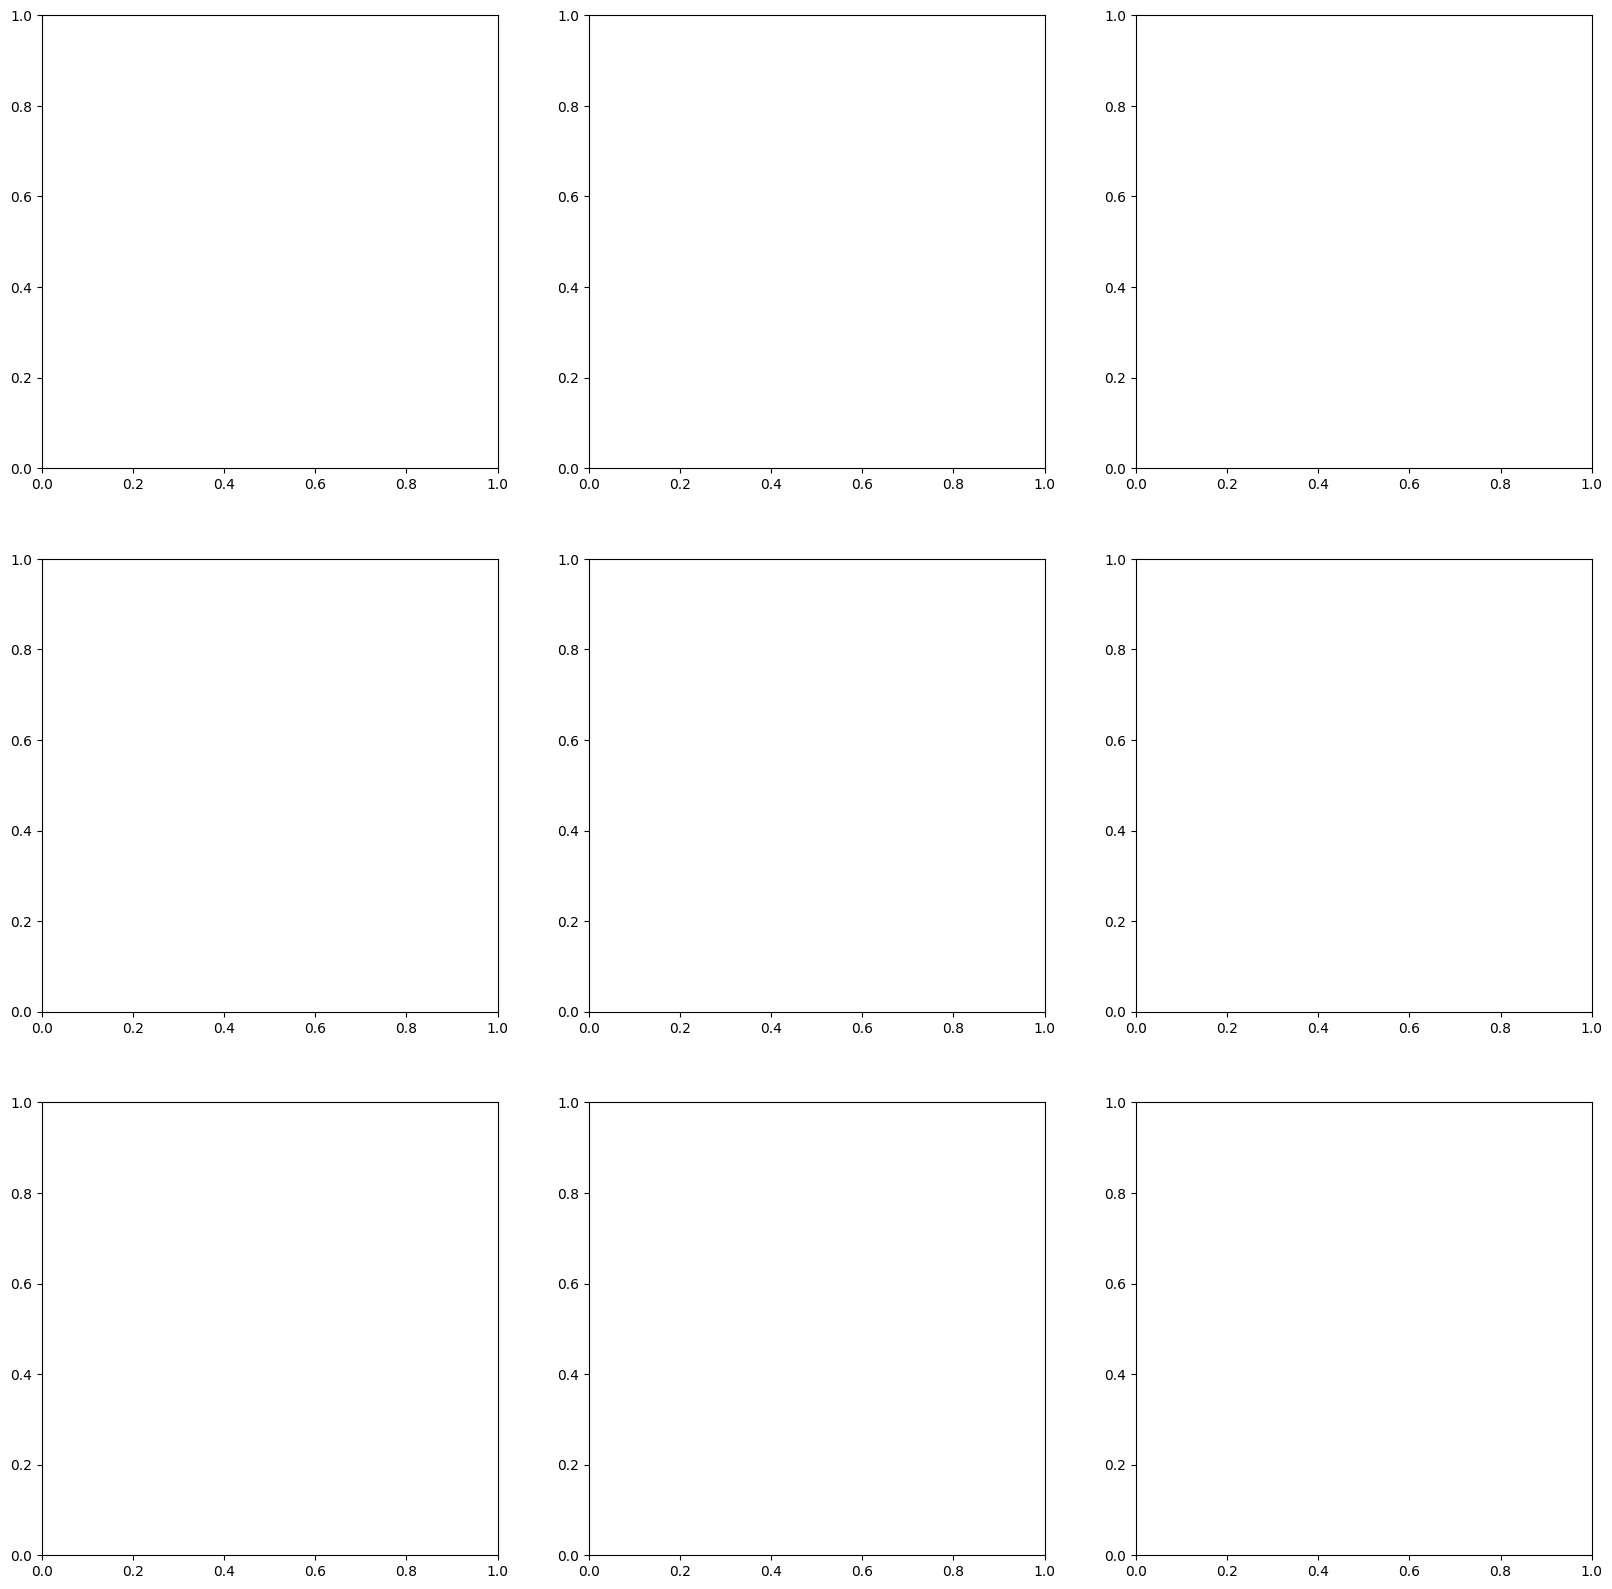

In [166]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [177]:
# you know what to do

params ={'max_depth': np.arange(2,10),
         'min_samples_split':np.arange(2,10,2),
         'min_samples_leaf':np.arange(1,10,2)}

gs = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy')

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([2, 4, 6, 8])},
             scoring='accuracy')

In [ ]:
gs.best_estimator_, gs.best_score_

In [184]:
model = DecisionTreeClassifier(max_depth=9, min_samples_split=8)

model.fit(X_train, y_train)

prediction = model.predict(X_val)

accuracy_score(y_val, prediction)

0.9279925387534572

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь (Logreg)

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

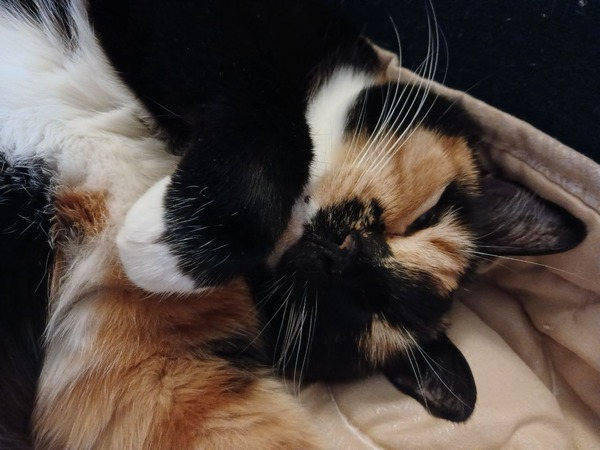

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?